In [1]:
import numpy as np
import math
from scipy.optimize import curve_fit
from copy import deepcopy as dcopy
import matplotlib.pyplot as plt

---------------------------------------GEM 1 : ENCODER AZIMUTH CORRECTION-------------------------------------------

In [2]:
def main():
    
    #Coleta dados de input
    jlist, filelist, jset, jjset, numframes = user_inputs() #ok
    _, Dir1, _, _, Dir4 = directories() #ok
    tag, file_list, file_name_list,file_name = input_files(filelist) #ok
    n_files = len(file_list)
    
    # Para cada arquivo da filelist, faz as correções necessárias nos dados de azimut e
    # escreve os arquivos de output
    
    for file_name_index in range(n_files): 
        jframe, time, azimut = input_datarr(file_name_list[file_name_index],Dir1)#ok
        
        dpfazi,slope,dslope,j = azi_correction(jframe,azimut,time,numframes,tag,file_name_index,file_name)
        
        # Calcula e escreve nos arquivos de output as estatísticas relacionadas a rotação
        write_stat_rot(dpfazi,slope,dslope,j,file_name,Dir4)
        

In [3]:
def user_inputs():
    
    
    jlist = int(input("Single file (1) or Multiple files (2)?: \n"))
    print("\n")
    
    if jlist == 1:
        datetag = int(input("Enter the date of the year [yy_MM_dd] : \n"))
        jfilenum = int(input("Enter the UT time of the day [hhmmssml] : \n"))
        jj = 1
    else:
        filelist = input("ENTER the filelist name: \n")
        print("\n")
        jj = 0

    jset = int(input(" SET Vmax? [1] => yes / [2] => no \n"))
    print("\n")

    if jset == 1:
        Vmax = float(input(" Write Vmax: \n"))
    else:
        Vmax = 9.8993 # 1999 observations

    jjset = int(input("SET slp rate? [1] => yes / [2] => no \n"))
    print("\n")
    if jjset == 1:
        slp = float(input("Write slp rate: \n"))
    else:
        slp = 17.0357 # iterated 1999 Vmax +/- 0.3918

    numframes = int(input("ENTER the expected number of frames/scan sequence :[1994 > 106; 1999 > 105; 2005 > 103,104] \n"))
    
    return jlist, filelist, jset, jjset, numframes

In [4]:
def directories():
    
    " Diretórios."
    
    Dir = "/media/nicolli/eabdalla2012/resultados_nicolli/tradução_gem_modulos/Step_1_files/txt/" 
    Dir1 = "/media/nicolli/eabdalla2012/resultados_nicolli/tradução_gem_modulos/Step_1_files/dat/"
    Dir2 = "/media/nicolli/eabdalla2012/resultados_nicolli/tradução_gem_modulos/Step_2_Part1/rots/"
    Dir3 = "/media/nicolli/eabdalla2012/resultados_nicolli/tradução_gem_modulos/Step_2_Part1/azimuth/"
    Dir4 = "/media/nicolli/eabdalla2012/resultados_nicolli/tradução_gem_modulos/Step_2_Part1/rots/dpf/"
    
    return Dir, Dir1, Dir2, Dir3, Dir4

In [5]:
def input_files(filelist):
    
    " A partir das informações dadas pelo usuário, coleta os arquivos de input."

    Dir, Dir1, Dir2, Dir3, Dir4 = directories()
    with open(Dir + filelist) as arq: 
        filelist = arq.readlines()
        n_files = len(filelist)
        sub_file_list, datetag, tag, file_name_list = [], [], [], []
        for file_name_index in range(n_files):
            s_datetag = str(filelist[file_name_index])
            datetag.append(s_datetag[:8])
            tag.append(s_datetag)
            raw_name = filelist[file_name_index]
            sub_file_list.append(raw_name)
            #----------------------------
            file_name = raw_name
            file_name = file_name.replace("\t", "")
            file_name = file_name.replace("\n", "")
            file_name_list.append(file_name)
#             with open(Dir1 + file_name, "r+") as f: 
#                 input_data = f.readlines()
#                 n_lines = len(input_data)
        
    return tag, sub_file_list, file_name_list, file_name

In [6]:
def input_datarr(file_name,Dir1):
    
    " Coleta dados de input de cada um dos arquivos de uma determinada filelist."
 
    jframe, time, azimut = [],[],[]
    
    with open(Dir1 + file_name, "r+") as f: 
        input_data = f.readlines()
        n_lines = len(input_data)
        
    
    for line in input_data:
        input_line = line.replace(" ", "")
        input_line = line.replace("\n", "")
        input_line = input_line.split(" ")
        input_line = list(filter(None, input_line))
        jjframe = float(input_line[0])
        jtime = float(input_line[1])
        jazimut = float(input_line[4])
                
        jframe.append(jjframe)
        time.append(jtime)
        azimut.append(jazimut)
        
        #print("jframe",jframe)
        #print("time",time)
        #print("azimut",azimut)
        
    return jframe, time, azimut

In [7]:
def azi_correction(jframe,azimut,time,numframes,tag,file_name_index,file_name):
   
    " Para cada frame de um arquivo, verifica e corrige (com auxílio de outras funções) valores" 
    " de azimute incorretos."  
    
    print("Doing file:",tag[file_name_index])
    Dir,Dir1,Dir2,Dir3, Dir4 = directories()
    timemean, aazmean, k, n_rotations, l, j105, j106, j = 0, 0, 0, 0, 0, 0, 0, 0
    aazimut, ttime, jccor, sig, dpfazi, speed, dspeed = [], [], [], [], [], [], []
    first, dangling, ic, new_rotation, first_time = True, False, None, False, True
    i_frames = len(jframe)
    for i in range(i_frames): #for each line in file

        if first: # Get a reference in time and direction.
            compaz = azimut[i]   
            firstime = time[i]
            first = False
            
        #this is the expected behavior (azi-compaz<176), except for the very 
        #last azimut which may differ from the previous one
        #by < 176 and yet show reversal in sense of 
        #direction. The usual is a continuous decrease in 
        #azimut. An unexpected sign reversal can also happen. =>

        if (abs(azimut[i]-compaz)) < 176:
            l,ic,dangling,ttime,timemean,aazmean,sig,aazimut = azi_expected(i,105,aazimut,timemean,aazmean,\
            dangling,ttime,jccor,sig,time,azimut,compaz,l,ic,new_rotation)
            new_rotation = False
        else:
            num_fr_per_rot = len(aazimut)
#             print("num_fr_per_rot",num_fr_per_rot)
            if num_fr_per_rot >= (numframes-1):
                j,slope,dslope,lastazi,midazi,firstazi,dpfazi_in_this_fr,l2,dpfazi = azi_signal_reverse(numframes,\
                dangling,aazimut,timemean,aazmean,ttime,azimut,l,i,ic,j,\
                dpfazi,speed,dspeed,j105,j106,first_time,jccor) 
                
                first_time = False
                
                # write in rot file (descrições dos arq. a escrever aq)
                dat_list_rot = [j,slope,dslope,lastazi,midazi,firstazi,dpfazi_in_this_fr]
                rot_type = "rot.dat"
                mode_rot = True
                aazi_dat = False
                write_output(dat_list_rot,file_name,Dir2,rot_type,mode_rot,aazi_dat)
                
            else:
                slope,dslope,aazi,l2 = azi_incomplete_rotations(timemean,aazmean,ttime,aazimut,azimut,l,ic,i)
                l_incomplete_rot = dcopy(l)
#                 print("l_incomplete_rot",l_incomplete_rot)
                
            aazimut,fpd = frame_p_degree(slope,l,l2,aazimut,ttime) 


            # write in azimut file
            dat_list_aazi = aazimut
            if (n_rotations) == 0: mode_aazi = True
            else: mode_aazi = False
            aazi_type = "azi.dat"
            aazi_dat = True
            write_output(dat_list_aazi,file_name,Dir3,aazi_type,mode_aazi,aazi_dat)
            
            # reset p/ próxima rotação 
            l,timemean,aazmean = 0,0,0 
            ic,dangling,new_rotation = None,False,True
            aazimut,ttime = [],[]
            n_rotations =+ 1
                
        compaz = azimut[i] # definindo compaz para o próximo valor de azimut (prox. linha)
    
    # last incomplete rotation
    aazimut = last_incpl_rotation(l_incomplete_rot,aazimut)
    # write last incomplete rotation
    dat_list_azi = aazimut
    if (n_rotations) == 0: mode_azi = True
    else: mode_azi = False
    azi_type = "azi.dat"
    aazi_dat = True
    write_output(dat_list_azi,file_name,Dir3,azi_type,mode_azi,aazi_dat)
    
    return dpfazi,slope,dslope,j #speed ou slope

In [8]:
def azi_expected(i,numframes,aazimut,timemean,aazmean,dangling,ttime,jccor,sig,time,azimut,compaz,l,ic,new_rotation):
    
    " Verifica se há uma reversão no sinal no último azimut (da rotação),"
    " ou se há uma inversão inesperada "
#     print(len(ttime), len(aazimut), "azi_expected")
    
    if i == 0 or new_rotation == True:# valor de l => contabilização dos azis que decrescem dentro do esperado com o tempo 
        l = 0           # dentro de uma rotação do radiotelescópio.
    else:
        l += 1 
    
    if (l > 0) and (time[i] - ttime[l-1] < 0):
        ttime.append(time[i] + 86400)
    else:
        ttime.append(time[i])
        
    aazimut.append(azimut[i])
    timemean = timemean + ttime[l]
    aazmean = aazmean + azimut[i]

    sig.append(1)
    
    len_aazi = len(aazimut)
    
    if (azimut[i]-compaz) > 0: #
        if l >= (numframes-1):
            dangling = True #sign reversal in last azimut detected 
        else:
            if ic == None: 
                ic = 0 #unexpected sign
            else: 
                ic += 1
            jccor.append(l)

    return l,ic,dangling,ttime,timemean,aazmean,sig,aazimut

In [9]:
def azi_signal_reverse(numframes,dangling,aazimut,timemean,aazmean,ttime,\
                       azimut,l,i,ic,j,dpfazi,speed,dspeed,j105,j106,first_time,jccor):
    " Caso o valor atual de azi tenha decrescido fora do esperado (azi-compaz > 176),"
    " mas o número atual de 'l' contabilizados corresponde a uma rotação completa,"
    " então será feita uma correção nos valores de azi em que ocorreram reversões inesperadas,"
    " a partir do valor calculado de slope (vel./s) na função dpf."
    
    lastazi, midazi, firstazi= 0, 0, 0
    frame_rot_counter = len(aazimut)
                                              #In case the sign reversal had already occured
    if frame_rot_counter == (numframes-1):    #in the previous frame but the magnitude fell 
        j105 += 1                             #short of 176, we delete it from the mean (mm=1)
    if frame_rot_counter == numframes:        #double-dangling forces l to increase by 1. Even
        j106 += 1                             #when lastazi is really only the l-1 element, mid
                                              #azi serves just as well as firstazi to set dpfazi
    
    if first_time == True:
        j = 0  
    else: 
        j+=1 
        
    if dangling:# Se ocorreu reversão no último frame
        mm = 1
        slope,dslope,aazi = dpf(timemean,aazmean,ttime,aazimut,azimut[i],azimut[i+1],l,mm,i)
        lastazi = aazimut[l-2] 
        midazi = aazimut[l-1]
        firstazi = aazimut[l]
        l2 = 1
#         print("l",l)
#         print("lastazi","midazi","firstazi",lastazi,midazi,firstazi)

    else: # Se não
        lastazi = aazimut[l]
        mm = 0
        slope,dslope,aazi = dpf(timemean,aazmean,ttime,aazimut,azimut[i],azimut[i+1],l,mm,i)
        midazi = aazimut[l]
        firstazi = aazimut[l+1]
        l2 = 2
        
    speed.append(slope)
    dspeed.append(dslope)

    #If the Vmax used is correct, then midazi will be
    #spaced evenly from lastazi to firstazi according
    #to the prevailing slope. So we check and correct
    
    dpfazi_value = (360.0 + lastazi - firstazi)/2 # Calculando vel. graus/frame
    dpfazi.append(dpfazi_value)

    dpfazi_in_this_fr = (360.0 + lastazi - firstazi)/2
    
    # ic value = times unexpected signal reverse occurs (first time => ic = 0) 
    if not ic == None : 
    # Substituindo valores de azimute onde aconteceram reversões inesperadas, pelo valor corrigido 
    # de (vel./s * tempo_entre_frames = azi_corrigido)
        count = 0
        while count <= ic:
            aazimut[(jccor[count])] = aazimut[(jccor[count] - 1)] + (slope*0.56002)
            if aazimut[(jccor[count])] < 0: aazimut[(jccor[count])] += 360.0
            count += 1
#     print("speed e dspeed",speed,dspeed)
#     print("dpf_azi_this_frame",dpfazi_in_this_fr)

    return j,slope,dslope,lastazi,midazi,firstazi,dpfazi_in_this_fr,l2,dpfazi # write in rots file

In [10]:
def azi_incomplete_rotations(timemean,aazmean,ttime,aazimut,azimut,l,ic,i):
    
    " Caso 'l' corresponda a uma rotação incompleta, o valor de slope também será calculado. "
    
    print("Incomplete rotation of l frames =>",l)
    
    #print("timemean - azi_inc_rot_func",timemean)
    
    if not ic == None:
        mm = 1
        slope,dslope,aazi = dpf(timemean,aazmean,ttime,aazimut,azimut[i],azimut[i+1],l,mm,i)
        print("azimut[i]",azimut[i])
        print("slope azi_inc_rot",slope)
        l2 = 1
    else:
        mm = 0
        slope,dslope,aazi = dpf(timemean,aazmean,ttime,aazimut,azimut[i],azimut[i+1],l,mm,i)
        l2 = 2
    
    return slope,dslope,aazi,l2

In [11]:
def frame_p_degree(slope,l,l2,aazimut,ttime):
    
    " Calcula fpd (degree/frame), a partir do valor de slope, e realiza uma correção nos "
    " valores de azi que não forem compatíveis, numa margem, com o azimute calculado a partir de (vel*tempo)."
    
    fpd = slope*0.56002 
#     print("fpd",fpd)
    print("len(ttime)",len(ttime))
    print("l+l2",l+l2) 
    print("l2",l2)  
    print("ttime",ttime)
    d = 0
    while d <= (l+l2):
        if d >= (len(ttime)):
            ttime.append(0)
        if d > 0:
            aa_zi = abs(aazimut[d] - aazimut[d-1]) 
            tti_me = (ttime[d] - ttime[d-1])
            
            if (aa_zi < (abs(fpd/2))) or (aa_zi > (3*(abs(fpd/2)))) and (tti_me < (3*0.56002/2)):
                
                aazimut[d] = aazimut[d-1] + fpd 
        d += 1
        
    return aazimut,fpd

In [12]:
def last_incpl_rotation(l,aazimut):
    
    " Correção dos valores da última rotação."
    i = 0
    while i <= l: #last incomplete rotation 
        if i > 0:
            
            if ((aazimut[i] - aazimut[i-1]) < (fpd/2)) or ((aazimut[i] - aazimut[i-1]) > (3*fpd/2))\
            and ((ttime[i] - time[i-1]) < (3*0,56002/2)):
                aazimut[i] = aazimut[i-1] + fpd
        i += 1
        
    return aazimut

In [13]:
def write_output(listt, file_name, dirr, type_file, mode, aazi_dat):
    """
    Escreve os dados processados em seus respectivos arquivos.
    """
    if aazi_dat:
        new_name = file_name.replace(".dat", type_file)
        write_mode = "w" if mode else "a"  # Define o modo de escrita (sobrescrever ou anexar)

        with open(dirr + new_name, write_mode) as arq_output:
            for item in listt:
                arq_output.write(f"{item:.2f}\n")  # Escreve cada item em uma linha, formatado com 2 casas decimais

    else:
        
        data = str(listt[0])
    #     print("listt",listt)
        for item in listt:
            item = f"{item:.2f}"
            data += f"\t{item}\t"
        new_name = file_name.replace(".dat", type_file)

        if mode:
            with open(dirr + new_name,"w") as arq_output:
                arq_output.write(data)
                arq_output.write("\n")
        else:
            with open(dirr + new_name,"a") as arq_output:
                arq_output.write(data)
                arq_output.write("\n")

In [14]:
def write_stat_rot(dpfazi,speed,dspeed,j,file_name,Dir4):
    
    slopmean,sigma,sigint,Z,dZ,dpfmean,sigdpf,fpd,sig_dpf,sigman_dpf,sigint_dpf,\
    mean_per,per_sigman,sigma_per,sigint_per,Vslp = stats_parameters(dpfazi,speed,dspeed,j)
    
    mode_rot_dpf = True
    listt_dpf = [fpd,sig_dpf,dpfmean,sigdpf,(fpd-dpfmean),Vslp]
    type_dpf = "dpf_rots.dat"
    dirr_dpf = Dir4
    write_output(listt_dpf,file_name,Dir4,type_dpf,mode_rot_dpf)
    

In [15]:
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::				
def stats_parameters(dpfazi,speed,dspeed,j):
    """
    Calculates rotation statistics
    """
    wt, slopemean, dpfmean, sigma, sigdpf = 0,0,0,0,0
    for i in range(j):
        w = 1.0/dspeed[i]**2
        slopemean += speed[i]*w
        wt += w 
        dpfmean += dpfazi[i]
    #print("w",w)
    slopemean = slopemean/wt #mean dish rotation speed in deg/sec
    dpfmean = dpfmean/j ##Average dpf speed in deg/frame
    for i in range(j):
        w = 1.0/dspeed[i]**2
        sigma = sigma + w*(speed[i] - slopemean)**2    
        sigdpf = sigdpf + (dpfazi[i] - dpfmean)**2

    sigma = math.sqrt(sigma/wt*j/(j-1)) # sigma dispersion (slopemean) deg/sec
    sigman = sigma/math.sqrt(j*1) # external error (slopemean) deg/sec
    sigint = math.sqrt(1/wt) # internal error (slopemean) deg/sec            
    Z = sigman/sigint # z statistic
    dZ = 1/math.sqrt(2*(j-1))         
    sigdpf = math.sqrt(sigdpf/(j-1))/math.sqrt(j*1)

    fpd = slopemean*0.56002 # frames/degree
    sig_dpf = sigma * 0.56002 # sigma dispersion
    sigman_dpf = sigman * 0.56002 # external error
    sigint_dpf = sigint * 0.56002 # internal error

    mean_per = 360/slopemean # Average rotation period in seconds
    per_sigman = 360*sigman/slopemean**2 # external error
    sigma_per = 360*sigma/slopemean**2 # sigma dispersion
    sigint_per = 360*sigint/slopemean**2 # internal error

    Vslp = Vmax + (fpd - dpfmean)/slp
    return(slopmean,sigma,sigint,Z,dZ,dpfmean,sigdpf,fpd,sig_dpf,sigman_dpf,sigint_dpf,mean_per,per_sigman,sigma_per,sigint_per,Vslp)

In [16]:
#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
def dpf(tmean,zmean,ttim,aazi,azi,next_azi,n,m,i):
    """
    Using the output of the least_sq function and the average values 
    of time and azimuth, calculate the speed in degrees/frame
    """

    if m == 0: #se não há inversão de sinal 
                            ##  tmean é inicialmente a soma de todos os valores de tempo 
        tmean = tmean/(n+1) ##  logo, aqui temos a média do tempo de uma rotação
        zmean = zmean/(n+1) ##  mesma coisa para o azimute
       
    else: #se há
        tmean = (tmean - ttim[n])/n
        zmean = (zmean - aazi[n])/n

    i = 0 ##
    while i <= n-m: ## subtrai valor médio em todos os dados, menos o último (se houver inversão)
        ttim[i] = (ttim[i] - tmean)
        aazi[i] = (aazi[i] - zmean)
        i += 1
    
    if ((n+1)-m) > 2:
        lsq_azi, lsq_tim = dcopy(aazi),dcopy(ttim)
        lsq_azi[-1],lsq_tim[-1] = 0, 0
        slope, zer, dslope, dzer  = least_sq(function, lsq_tim, lsq_azi) # ajuste linear(tempo,azimute)
    else:
        slope, dslope = 0, 0
        
    aazi.append(azi)
    
    print("slope",slope) # vel angular
    print("dslope",dslope) # incerteza
    
    i = 0
    while i <= n-m:
        aazi[i] += zmean
        i += 1
    # Código de ajuste dos valores de azimute corrigidos
    jk = (n + 2) - m
    if jk >= len(aazi):
        aazi.append(0)

    if (aazi[jk] <= next_azi) or (abs(aazi[jk] - next_azi) < (abs(slope * 0.56002 / 8 * 7))):
        dstep = (360 + aazi[n - m] - next_azi) / 3
        for i in range(1, 4):
            if i - m > 0:
                aazi.append(0)  # aazi é estendido para armazenar os valores
            aazi[n + i - m] = aazi[n - m] - i * dstep
            if aazi[n + i - m] < 0:
                aazi[n + i - m] += 360

    else:
        aazi[n + 1 - m] = aazi[n - m] + (360 + aazi[n - m] - aazi[n + 2 - m]) / 2
        if aazi[n + 1 - m] < 0:
            aazi[n + 1 - m] += 360

        # Checa se uma nova posição foi criada na lista
        if (n + 3 - m) >= len(aazi):
            aazi.append(0)  # Adiciona o 0 apenas se a lista tiver um novo elemento

        # Atualiza o valor corrigido
        aazi[n + 3 - m] = azi

    n += 1

#     jk = (n+2)-m
#     if jk >= (len(aazi)):
#         aazi.append(0)
#     if (aazi[jk]<=next_azi) or (abs(aazi[jk]-next_azi))<(abs(slope*0.56002/8*7)):
#         print("aazi[jk]",aazi[jk]) #ok
#         print("next_azi",next_azi)
#         dstep = (360+aazi[n-m]- next_azi)/3
#         print("aazi[n-m]",aazi[n-m])#ok
#         print("dstep",dstep)
#         for i in range(1,4):
#             if i-m > 0: 
#                 aazi.append(0) # aazi é extendido para armazenar os valores de azimute corrigidos
#                 # referentes ao inicio da próxima rotação
#             aazi[n+i-m] = aazi[n-m] - i*dstep
#             if aazi[n+i-m] < 0:
#                 aazi[n+i-m] = aazi[n+i-m] + 360
#     else:    
#         aazi[n+1-m] =  aazi[n-m] - (360 + aazi[n-m] - aazi[n+2-m])/2
#         if aazi[n+1-m] < 0:
#             aazi[n+1-m] = aazi[n+1-m] + 360
#             if (n+3-m) >= (len(aazi)):
#                 aazi.append(0)
#             aazi[n+3-m] =  azi
    
#     n += 1
    
#     print("ttim2",ttim)
#     print("\n")
#     print("aazi saida dpf",aazi)
#     print("\n")
    
    return slope,dslope,aazi

In [17]:
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::	
def least_sq(function,x,y):
    """
    Calculate a linear fit to the azimuth data as a function of time,
    obtaining the speed in degrees/sec and their respective uncertainties
    """
    x = np.array(x, dtype="f8")
    y = np.array(y, dtype="f8")
    param, m_cov = curve_fit(function, x, y) 
    slope, intercept = param

    perr = np.sqrt(np.diag(m_cov)) #siga, sigb
    
    plt.scatter(x, y, color='blue', label='Dados')  
    plt.plot(x, function(x, slope, intercept), color='red',label=f'Ajuste: y = {slope:.2f}x + {intercept:.2f}')  
    plt.xlabel('Eixo X')
    plt.ylabel('Eixo Y')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return param[0],param[1],perr[0],perr[1]
#:::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

In [18]:
def function(x,a,b):
    return a*x + b  

#::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::

Single file (1) or Multiple files (2)?: 
2


ENTER the filelist name: 
fileli001.txt


 SET Vmax? [1] => yes / [2] => no 
2


SET slp rate? [1] => yes / [2] => no 
2


ENTER the expected number of frames/scan sequence :[1994 > 106; 1999 > 105; 2005 > 103,104] 
105
Doing file: 99_05_1820234490.dat

Incomplete rotation of l frames => 59


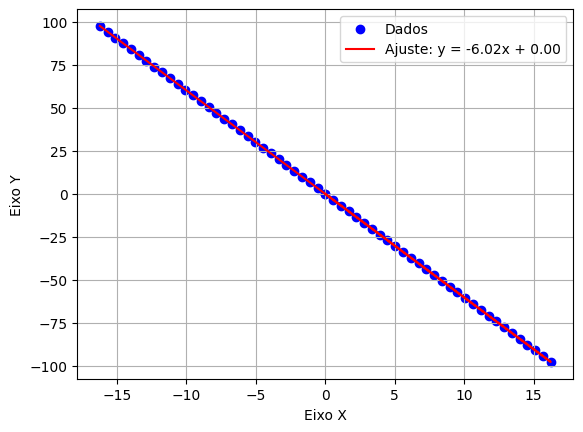

slope -6.020441698489771
dslope 0.0004336907186615813
azimut[i] 343.18
slope azi_inc_rot -6.020441698489771
len(ttime) 60
l+l2 60
l2 1
ttime [-16.240559322046465, -15.680559322034242, -15.12055932203657, -14.560559322038898, -14.000559322041227, -13.440559322043555, -12.880559322045883, -12.32055932203366, -11.760559322035988, -11.200559322038316, -10.640559322040644, -10.080559322042973, -9.520559322045301, -8.96055932204763, -8.400559322035406, -7.840559322037734, -7.280559322040062, -6.720559322042391, -6.160559322044719, -5.600559322047047, -5.040559322034824, -4.480559322037152, -3.9205593220394803, -3.3605593220418086, -2.800559322044137, -2.2405593220464652, -1.6795593220449518, -1.1195593220472801, -0.5595593220350565, 0.0004406779626151547, 0.5604406779602868, 1.1204406779579585, 1.6804406779556302, 2.240440677953302, 2.8004406779655255, 3.3604406779631972, 3.920440677960869, 4.480440677958541, 5.040440677956212, 5.600440677953884, 6.160440677966108, 6.720440677963779, 7.28044

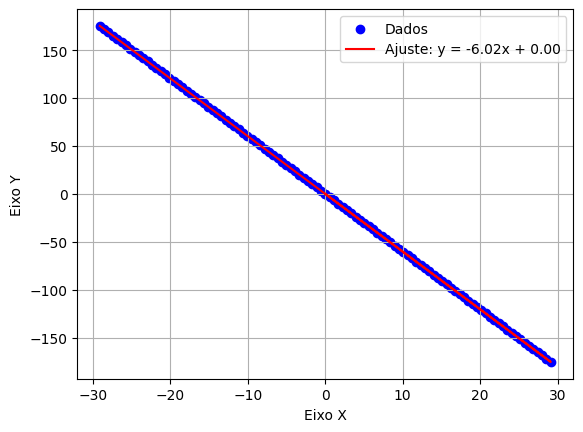

slope -6.018317013352453
dslope 0.00023868329464003514
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121238095249282, -28.56123809525161, -28.00123809525394, -27.441238095256267, -26.881238095244044, -26.321238095246372, -25.7612380952487, -25.20123809525103, -24.641238095253357, -24.081238095255685, -23.521238095258013, -22.96123809524579, -22.401238095248118, -21.841238095250446, -21.281238095252775, -20.72023809525126, -20.16023809525359, -19.600238095255918, -19.040238095243694, -18.480238095246023, -17.92023809524835, -17.36023809525068, -16.800238095253007, -16.240238095255336, -15.680238095257664, -15.12023809524544, -14.560238095247769, -14.000238095250097, -13.440238095252425, -12.880238095254754, -12.320238095257082, -11.760238095244858, -11.200238095247187, -10.640238095249515, -10.080238095251843, -9.520238095254172, -8.9602380952565, -8.400238095244276, -7.840238095246605, -7.280238095248933, -6.720238095251261, -6.16023809525359, -5.600238095255918, -5.040238095243694, -4.48023

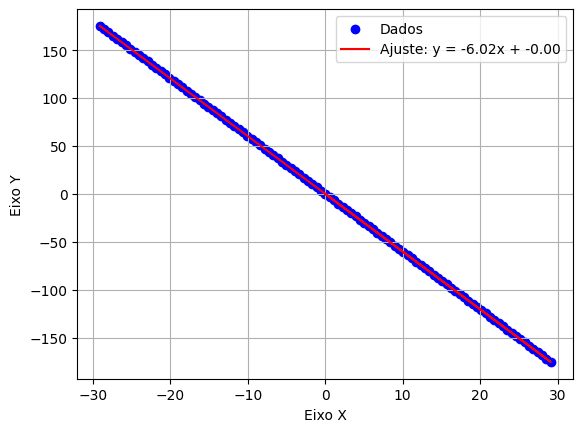

slope -6.018684997881998
dslope 0.00023305449679758623
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121380952376057, -28.561380952363834, -28.001380952366162, -27.44138095236849, -26.88138095237082, -26.321380952373147, -25.761380952375475, -25.200380952373962, -24.64038095236174, -24.080380952364067, -23.520380952366395, -22.960380952368723, -22.40038095237105, -21.84038095237338, -21.280380952375708, -20.720380952363485, -20.160380952365813, -19.60038095236814, -19.04038095237047, -18.480380952372798, -17.920380952375126, -17.360380952362902, -16.80038095236523, -16.24038095236756, -15.680380952369887, -15.120380952372216, -14.560380952374544, -14.00038095236232, -13.440380952364649, -12.880380952366977, -12.320380952369305, -11.760380952371634, -11.200380952373962, -10.640380952361738, -10.080380952364067, -9.520380952366395, -8.960380952368723, -8.400380952371052, -7.84038095237338, -7.280380952375708, -6.7203809523634845, -6.160380952365813, -5.600380952368141, -5.0403809523704695, -4.

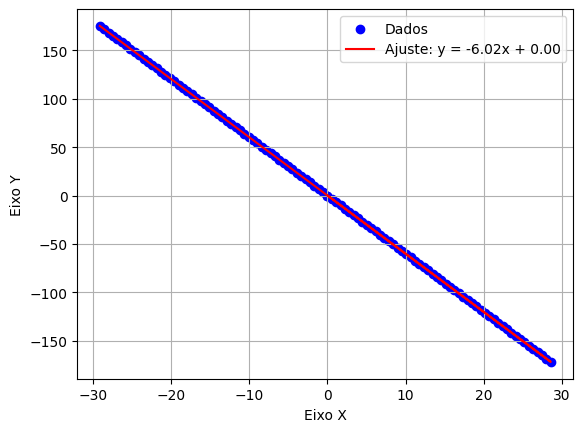

slope -6.01827762340919
dslope 0.0002494869059854625
len(ttime) 105
l+l2 106
l2 2
ttime [-29.12155238095147, -28.560552380949957, -28.000552380952286, -27.440552380954614, -26.880552380956942, -26.32055238094472, -25.760552380947047, -25.200552380949375, -24.640552380951704, -24.080552380954032, -23.52055238095636, -22.960552380944137, -22.400552380946465, -21.840552380948793, -21.28055238095112, -20.72055238095345, -20.160552380955778, -19.600552380943554, -19.040552380945883, -18.48055238094821, -17.92055238095054, -17.360552380952868, -16.800552380955196, -16.240552380957524, -15.6805523809453, -15.120552380947629, -14.560552380949957, -14.000552380952286, -13.440552380954614, -12.880552380956942, -12.320552380944719, -11.760552380947047, -11.200552380949375, -10.640552380951704, -10.080552380954032, -9.52055238095636, -8.960552380944137, -8.400552380946465, -7.840552380948793, -7.2805523809511214, -6.72055238095345, -6.160552380955778, -5.6005523809435545, -5.040552380945883, -4.48

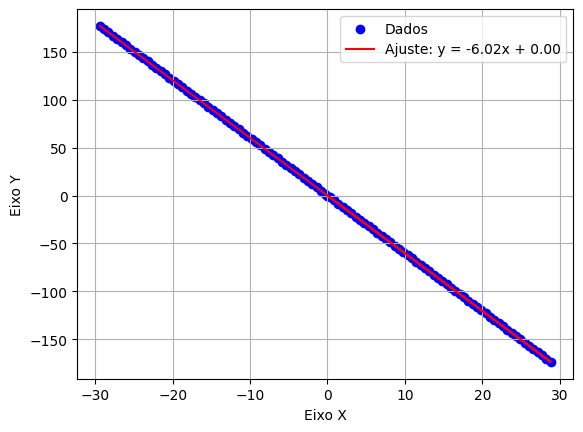

slope -6.018289108816082
dslope 0.0002804402467901249
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400679245285573, -28.8406792452879, -28.280679245275678, -27.720679245278006, -27.160679245280335, -26.600679245282663, -26.04067924528499, -25.48067924528732, -24.920679245275096, -24.360679245277424, -23.800679245279753, -23.24067924528208, -22.68067924528441, -22.120679245286738, -21.560679245289066, -21.000679245276842, -20.44067924527917, -19.8806792452815, -19.320679245283827, -18.760679245286155, -18.200679245288484, -17.64067924527626, -17.08067924527859, -16.520679245280917, -15.960679245283245, -15.400679245285573, -14.840679245287902, -14.280679245275678, -13.720679245278006, -13.160679245280335, -12.600679245282663, -12.040679245284991, -11.48067924528732, -10.920679245275096, -10.360679245277424, -9.800679245279753, -9.240679245282081, -8.68067924528441, -8.120679245286738, -7.560679245289066, -7.000679245276842, -6.440679245279171, -5.880679245281499, -5.320679245283827, -4.76067

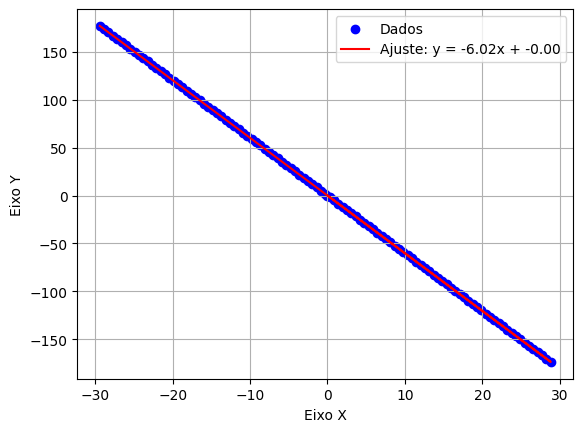

slope -6.018894710998352
dslope 0.0002344561865166705
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400811320738285, -28.840811320740613, -28.28081132074294, -27.72081132074527, -27.160811320747598, -26.600811320735374, -26.040811320737703, -25.48081132074003, -24.92081132074236, -24.360811320744688, -23.800811320747016, -23.240811320734792, -22.68081132073712, -22.12081132073945, -21.560811320741777, -21.000811320744106, -20.440811320746434, -19.88081132073421, -19.32081132073654, -18.760811320738867, -18.200811320741195, -17.640811320743524, -17.080811320745852, -16.52081132073363, -15.960811320735957, -15.400811320738285, -14.840811320740613, -14.280811320742941, -13.72081132074527, -13.160811320747598, -12.600811320735374, -12.040811320737703, -11.480811320740031, -10.92081132074236, -10.360811320744688, -9.800811320747016, -9.240811320734792, -8.68081132073712, -8.119811320735607, -7.559811320737936, -6.999811320740264, -6.439811320742592, -5.8798113207449205, -5.319811320747249, -4.759

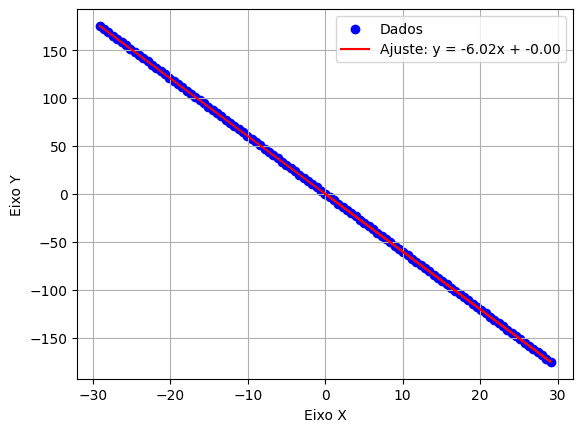

slope -6.019800826823085
dslope 0.0002482598556226016
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120933333339053, -28.56093333332683, -28.000933333329158, -27.440933333331486, -26.880933333333815, -26.320933333336143, -25.76093333333847, -25.200933333326248, -24.640933333328576, -24.080933333330904, -23.520933333333232, -22.96093333333556, -22.40093333333789, -21.840933333325665, -21.280933333327994, -20.720933333330322, -20.16093333333265, -19.60093333333498, -19.040933333337307, -18.480933333339635, -17.92093333332741, -17.36093333332974, -16.80093333333207, -16.240933333334397, -15.680933333336725, -15.120933333339053, -14.56093333332683, -14.000933333329158, -13.440933333331486, -12.880933333333815, -12.320933333336143, -11.75993333333463, -11.199933333336958, -10.639933333339286, -10.079933333327062, -9.51993333332939, -8.959933333331719, -8.399933333334047, -7.839933333336376, -7.279933333338704, -6.71993333332648, -6.159933333328809, -5.599933333331137, -5.039933333333465, -4.47993

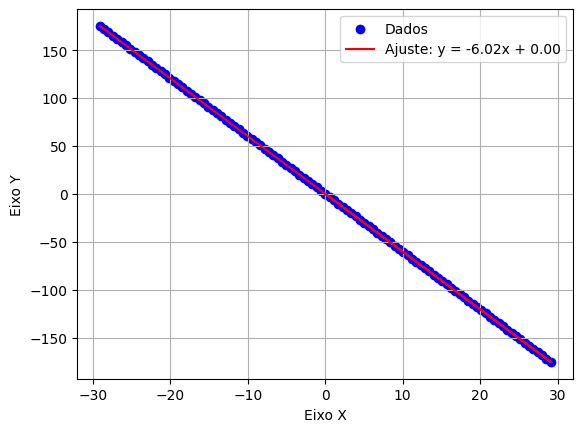

slope -6.020364114178904
dslope 0.00021621875204536043
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12106666667387, -28.561066666676197, -28.001066666678526, -27.441066666666302, -26.88106666666863, -26.32106666667096, -25.761066666673287, -25.201066666675615, -24.641066666677943, -24.08106666668027, -23.521066666668048, -22.961066666670376, -22.401066666672705, -21.841066666675033, -21.28106666667736, -20.72106666667969, -20.161066666667466, -19.601066666669794, -19.041066666672123, -18.48106666667445, -17.92106666667678, -17.361066666679108, -16.801066666666884, -16.241066666669212, -15.680066666667699, -15.120066666670027, -14.560066666672355, -14.000066666674684, -13.440066666677012, -12.88006666667934, -12.320066666667117, -11.760066666669445, -11.200066666671773, -10.640066666674102, -10.08006666667643, -9.520066666678758, -8.960066666666535, -8.400066666668863, -7.840066666671191, -7.28006666667352, -6.720066666675848, -6.160066666678176, -5.600066666680505, -5.040066666668281, -4.48

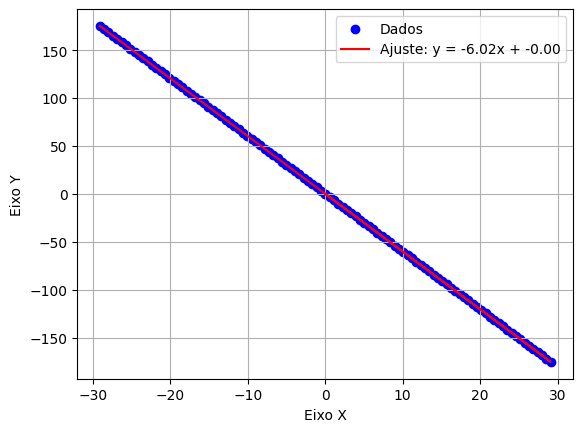

slope -6.020177105210026
dslope 0.00021912935397412322
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121200000008685, -28.561200000011013, -28.00120000001334, -27.44120000001567, -26.881200000017998, -26.321200000020326, -25.761200000008103, -25.20120000001043, -24.64120000001276, -24.081200000015087, -23.521200000017416, -22.961200000019744, -22.40120000000752, -21.84120000000985, -21.281200000012177, -20.721200000014505, -20.161200000016834, -19.60020000001532, -19.04020000001765, -18.480200000019977, -17.920200000007753, -17.36020000001008, -16.80020000001241, -16.240200000014738, -15.680200000017066, -15.120200000019395, -14.560200000007171, -14.0002000000095, -13.440200000011828, -12.880200000014156, -12.320200000016484, -11.760200000018813, -11.200200000021141, -10.640200000008917, -10.080200000011246, -9.520200000013574, -8.960200000015902, -8.40020000001823, -7.840200000020559, -7.280200000008335, -6.720200000010664, -6.160200000012992, -5.60020000001532, -5.040200000017649, -4.48020

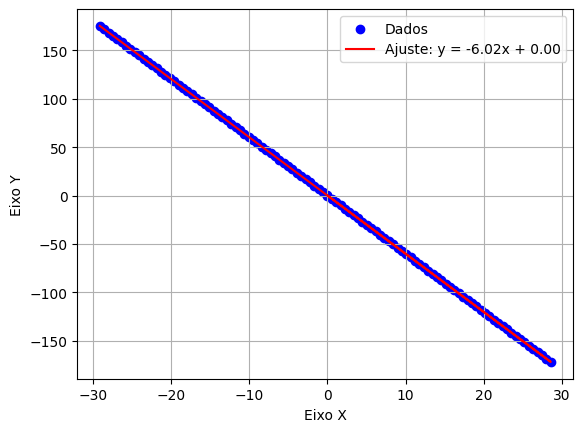

slope -6.019611061417718
dslope 0.00023625840985905063
len(ttime) 105
l+l2 106
l2 2
ttime [-29.12133333332895, -28.561333333331277, -28.001333333319053, -27.44133333332138, -26.88133333332371, -26.321333333326038, -25.761333333328366, -25.201333333330695, -24.641333333333023, -24.0813333333208, -23.520333333319286, -22.960333333321614, -22.400333333323942, -21.84033333332627, -21.2803333333286, -20.720333333330927, -20.160333333318704, -19.600333333321032, -19.04033333332336, -18.48033333332569, -17.920333333328017, -17.360333333330345, -16.800333333332674, -16.24033333332045, -15.680333333322778, -15.120333333325107, -14.560333333327435, -14.000333333329763, -13.440333333332092, -12.880333333319868, -12.320333333322196, -11.760333333324525, -11.200333333326853, -10.640333333329181, -10.08033333333151, -9.520333333319286, -8.960333333321614, -8.400333333323942, -7.840333333326271, -7.280333333328599, -6.720333333330927, -6.160333333318704, -5.600333333321032, -5.04033333332336, -4.4803

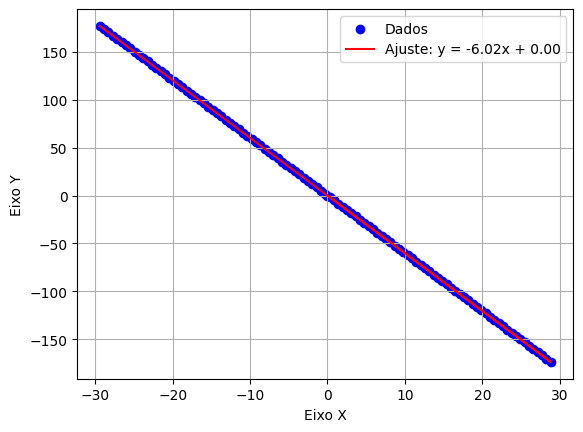

slope -6.0195420116517875
dslope 0.00026582946553626105
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401481132066692, -28.84148113206902, -28.28148113207135, -27.721481132073677, -27.160481132072164, -26.600481132074492, -26.04048113207682, -25.48048113207915, -24.920481132066925, -24.360481132069253, -23.80048113207158, -23.24048113207391, -22.68048113207624, -22.120481132078567, -21.560481132066343, -21.00048113206867, -20.440481132071, -19.880481132073328, -19.320481132075656, -18.760481132077985, -18.20048113206576, -17.64048113206809, -17.080481132070418, -16.520481132072746, -15.960481132075074, -15.400481132077402, -14.840481132065179, -14.280481132067507, -13.720481132069835, -13.160481132072164, -12.600481132074492, -12.04048113207682, -11.480481132079149, -10.920481132066925, -10.360481132069253, -9.800481132071582, -9.24048113207391, -8.680481132076238, -8.120481132078567, -7.560481132066343, -7.000481132068671, -6.440481132071, -5.880481132073328, -5.320481132075656, -4.76048113

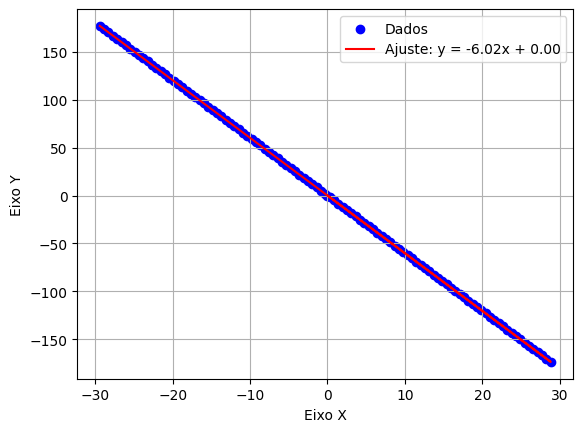

slope -6.019912269346362
dslope 0.0002563954403235142
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400641509433626, -28.840641509435955, -28.280641509438283, -27.72064150944061, -27.160641509428388, -26.600641509430716, -26.040641509433044, -25.480641509435372, -24.9206415094377, -24.36064150944003, -23.800641509427805, -23.240641509430134, -22.680641509432462, -22.12064150943479, -21.56064150943712, -21.000641509439447, -20.440641509427223, -19.88064150942955, -19.32064150943188, -18.76064150943421, -18.200641509436537, -17.640641509438865, -17.080641509441193, -16.52064150942897, -15.960641509431298, -15.400641509433626, -14.840641509435955, -14.280641509438283, -13.720641509440611, -13.160641509428388, -12.600641509430716, -12.040641509433044, -11.480641509435372, -10.9206415094377, -10.360641509440029, -9.800641509427805, -9.240641509430134, -8.680641509432462, -8.12064150943479, -7.560641509437119, -7.000641509439447, -6.440641509427223, -5.880641509429552, -5.32064150943188, -4.760641

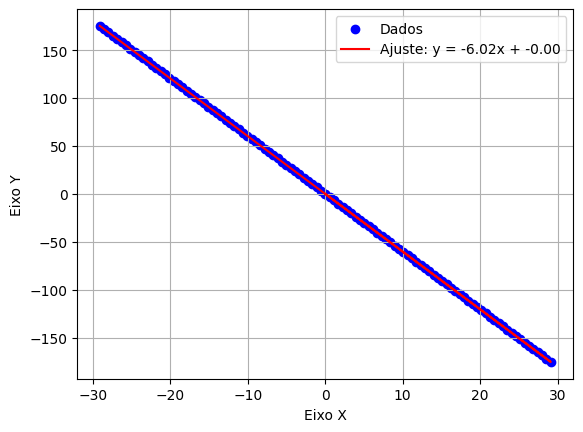

slope -6.020339239888144
dslope 0.0002475736053282014
len(ttime) 106
l+l2 106
l2 1
ttime [-29.1207714285556, -28.560771428557928, -28.000771428560256, -27.440771428562584, -26.880771428564913, -26.32077142856724, -25.760771428555017, -25.200771428557346, -24.640771428559674, -24.080771428562002, -23.52077142856433, -22.96077142856666, -22.400771428568987, -21.840771428556764, -21.280771428559092, -20.72077142856142, -20.16077142856375, -19.600771428566077, -19.040771428568405, -18.48077142855618, -17.92077142855851, -17.360771428560838, -16.800771428563166, -16.240771428565495, -15.680771428567823, -15.1207714285556, -14.560771428557928, -14.000771428560256, -13.440771428562584, -12.880771428564913, -12.320771428567241, -11.760771428555017, -11.200771428557346, -10.640771428559674, -10.080771428562002, -9.52077142856433, -8.960771428566659, -8.400771428568987, -7.840771428556764, -7.280771428559092, -6.7197714285575785, -6.159771428559907, -5.599771428562235, -5.039771428564563, -4.479

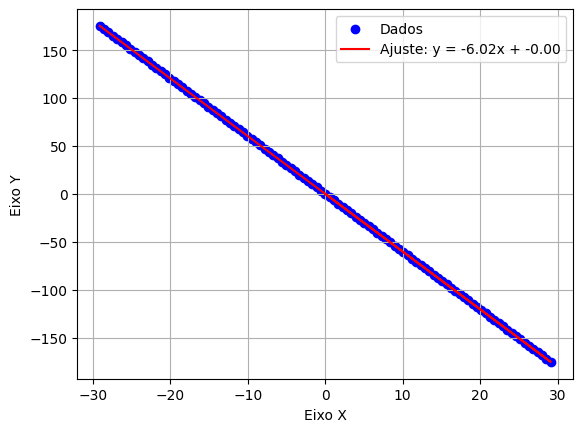

slope -6.020560479360867
dslope 0.00022514836121084711
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120895238098456, -28.560895238100784, -28.000895238103112, -27.44089523809089, -26.880895238093217, -26.320895238095545, -25.760895238097874, -25.200895238100202, -24.64089523810253, -24.080895238090307, -23.520895238092635, -22.960895238094963, -22.40089523809729, -21.84089523809962, -21.280895238101948, -20.720895238089724, -20.160895238092053, -19.60089523809438, -19.04089523809671, -18.480895238099038, -17.920895238101366, -17.360895238089142, -16.80089523809147, -16.2408952380938, -15.680895238096127, -15.120895238098456, -14.560895238100784, -14.000895238103112, -13.440895238090889, -12.880895238093217, -12.320895238095545, -11.760895238097874, -11.200895238100202, -10.639895238098688, -10.079895238101017, -9.519895238103345, -8.959895238091121, -8.39989523809345, -7.839895238095778, -7.279895238098106, -6.719895238100435, -6.159895238102763, -5.599895238090539, -5.039895238092868, -4.4

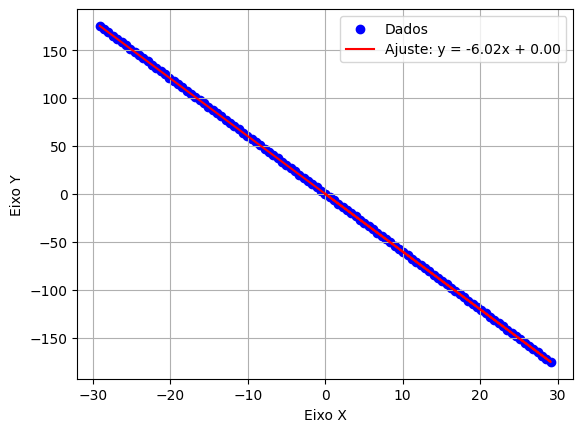

slope -6.020350690264463
dslope 0.00023505962414399942
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12102857141872, -28.561028571421048, -28.001028571423376, -27.441028571425704, -26.881028571428033, -26.32102857141581, -25.761028571418137, -25.201028571420466, -24.641028571422794, -24.081028571425122, -23.52102857142745, -22.961028571415227, -22.401028571417555, -21.841028571419884, -21.281028571422212, -20.72102857142454, -20.16102857142687, -19.601028571429197, -19.041028571416973, -18.4810285714193, -17.92102857142163, -17.361028571423958, -16.801028571426286, -16.241028571428615, -15.681028571416391, -15.12102857141872, -14.560028571417206, -14.000028571419534, -13.440028571421863, -12.88002857142419, -12.32002857142652, -11.760028571428847, -11.200028571416624, -10.640028571418952, -10.08002857142128, -9.520028571423609, -8.960028571425937, -8.400028571428265, -7.840028571416042, -7.28002857141837, -6.720028571420698, -6.160028571423027, -5.600028571425355, -5.040028571427683, -4.4800

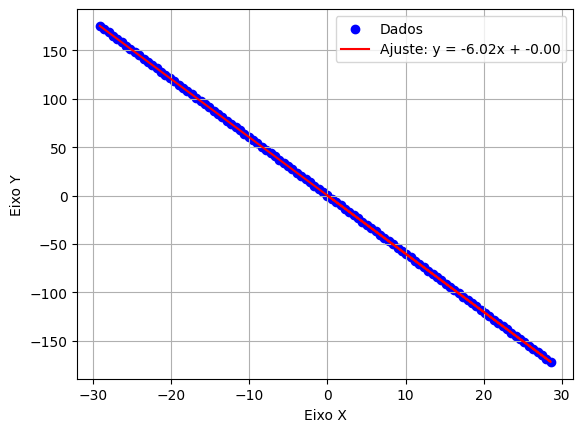

slope -6.020045051510568
dslope 0.00022468750782970762
len(ttime) 105
l+l2 106
l2 2
ttime [-29.12116190478264, -28.561161904784967, -28.001161904772744, -27.441161904775072, -26.8811619047774, -26.32116190477973, -25.761161904782057, -25.201161904784385, -24.64116190477216, -24.08116190477449, -23.521161904776818, -22.961161904779146, -22.401161904781475, -21.841161904783803, -21.28116190477158, -20.721161904773908, -20.161161904776236, -19.601161904778564, -19.041161904780893, -18.48016190477938, -17.920161904781708, -17.360161904784036, -16.800161904771812, -16.24016190477414, -15.680161904776469, -15.120161904778797, -14.560161904781125, -14.000161904783454, -13.44016190477123, -12.880161904773558, -12.320161904775887, -11.760161904778215, -11.200161904780543, -10.640161904782872, -10.080161904770648, -9.520161904772976, -8.960161904775305, -8.400161904777633, -7.840161904779961, -7.28016190478229, -6.720161904784618, -6.160161904772394, -5.600161904774723, -5.040161904777051, -4.48

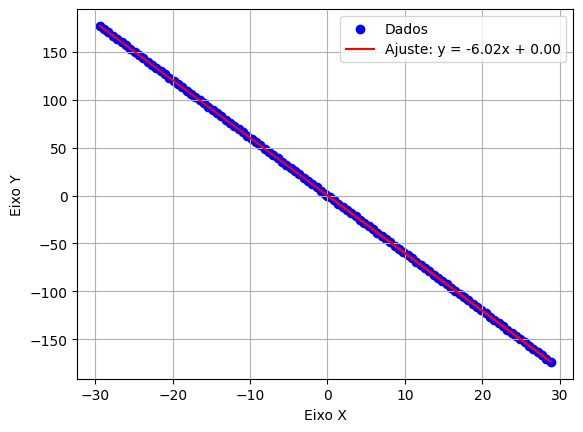

slope -6.019885429091839
dslope 0.0002527611179145839
len(ttime) 106
l+l2 107
l2 2
ttime [-29.40128301885852, -28.84128301886085, -28.281283018863178, -27.721283018865506, -27.161283018867834, -26.60128301885561, -26.04128301885794, -25.481283018860267, -24.921283018862596, -24.361283018864924, -23.801283018867252, -23.24128301885503, -22.681283018857357, -22.120283018855844, -21.560283018858172, -21.0002830188605, -20.44028301886283, -19.880283018865157, -19.320283018867485, -18.76028301885526, -18.20028301885759, -17.64028301885992, -17.080283018862247, -16.520283018864575, -15.960283018866903, -15.40028301885468, -14.840283018857008, -14.280283018859336, -13.720283018861664, -13.160283018863993, -12.600283018866321, -12.04028301886865, -11.480283018856426, -10.920283018858754, -10.360283018861082, -9.80028301886341, -9.240283018865739, -8.680283018868067, -8.120283018855844, -7.560283018858172, -7.0002830188605, -6.440283018862829, -5.880283018865157, -5.320283018867485, -4.76028301

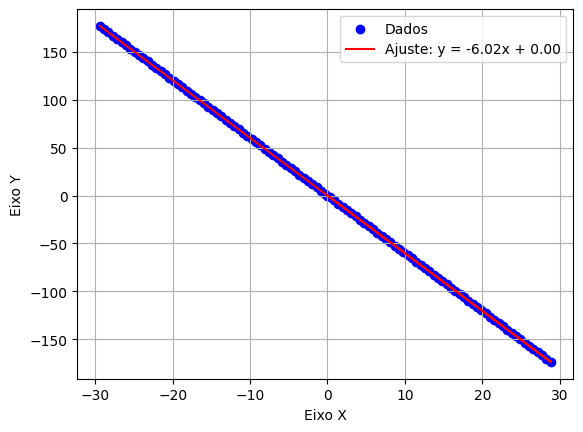

slope -6.019766008274477
dslope 0.00023938640820958808
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401424528317875, -28.84142452830565, -28.28142452830798, -27.72142452831031, -27.161424528312637, -26.601424528314965, -26.04042452831345, -25.48042452831578, -24.920424528318108, -24.360424528305884, -23.800424528308213, -23.24042452831054, -22.68042452831287, -22.120424528315198, -21.560424528317526, -21.000424528319854, -20.44042452830763, -19.88042452830996, -19.320424528312287, -18.760424528314616, -18.200424528316944, -17.640424528319272, -17.08042452830705, -16.520424528309377, -15.960424528311705, -15.400424528314034, -14.840424528316362, -14.28042452831869, -13.720424528306467, -13.160424528308795, -12.600424528311123, -12.040424528313451, -11.48042452831578, -10.920424528318108, -10.360424528305884, -9.800424528308213, -9.240424528310541, -8.68042452831287, -8.120424528315198, -7.560424528317526, -7.000424528319854, -6.440424528307631, -5.880424528309959, -5.320424528312287, -4.7604

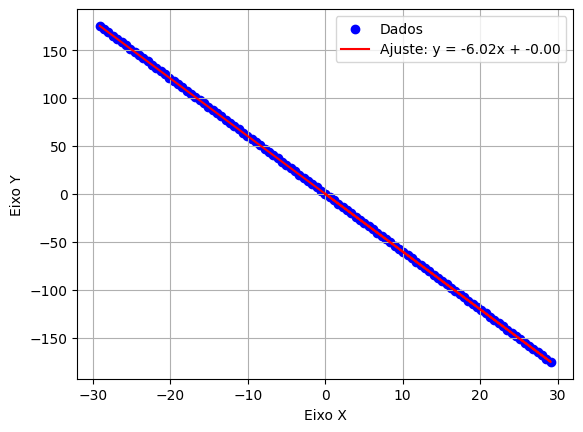

slope -6.020130700669711
dslope 0.00022721837684655668
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120590476188227, -28.560590476190555, -28.000590476192883, -27.44059047619521, -26.88059047619754, -26.320590476199868, -25.760590476187645, -25.200590476189973, -24.6405904761923, -24.08059047619463, -23.520590476196958, -22.960590476199286, -22.400590476187062, -21.84059047618939, -21.28059047619172, -20.720590476194047, -20.160590476196376, -19.600590476198704, -19.04059047618648, -18.48059047618881, -17.920590476191137, -17.360590476193465, -16.800590476195794, -16.240590476198122, -15.680590476185898, -15.120590476188227, -14.560590476190555, -14.000590476192883, -13.440590476195212, -12.88059047619754, -12.320590476199868, -11.760590476187645, -11.200590476189973, -10.640590476192301, -10.08059047619463, -9.520590476196958, -8.960590476199286, -8.400590476187062, -7.840590476189391, -7.280590476191719, -6.720590476194047, -6.160590476196376, -5.600590476198704, -5.04059047618648, -4.480

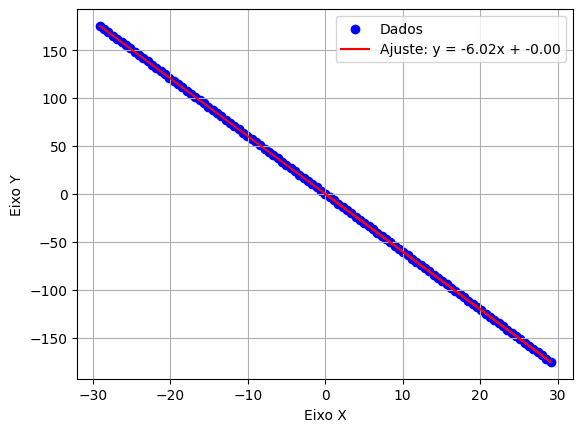

slope -6.020671916272626
dslope 0.0002193208151161046
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120733333344106, -28.560733333346434, -28.00073333333421, -27.44073333333654, -26.880733333338867, -26.320733333341195, -25.760733333343524, -25.200733333345852, -24.64073333333363, -24.080733333335957, -23.520733333338285, -22.960733333340613, -22.40073333334294, -21.84073333334527, -21.280733333333046, -20.720733333335374, -20.160733333337703, -19.60073333334003, -19.04073333334236, -18.480733333344688, -17.920733333347016, -17.360733333334792, -16.80073333333712, -16.24073333333945, -15.680733333341777, -15.120733333344106, -14.560733333346434, -14.00073333333421, -13.440733333336539, -12.880733333338867, -12.320733333341195, -11.760733333343524, -11.200733333345852, -10.640733333333628, -10.080733333335957, -9.520733333338285, -8.960733333340613, -8.400733333342941, -7.84073333334527, -7.280733333333046, -6.7207333333353745, -6.160733333337703, -5.599733333336189, -5.039733333338518, -4.47

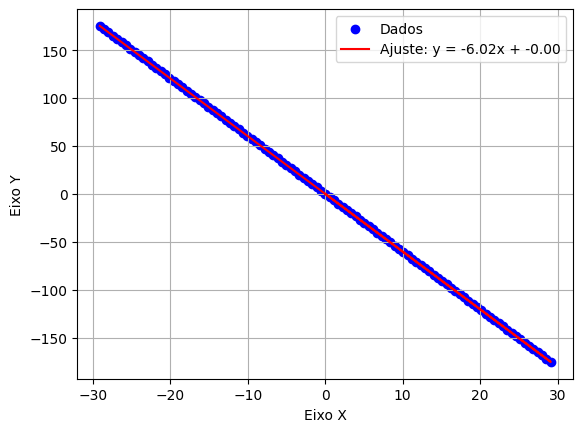

slope -6.0203316579271595
dslope 0.00023444282914590917
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12085714287241, -28.560857142874738, -28.000857142877067, -27.440857142879395, -26.88085714286717, -26.3208571428695, -25.760857142871828, -25.200857142874156, -24.640857142876484, -24.080857142878813, -23.52085714288114, -22.960857142868917, -22.400857142871246, -21.840857142873574, -21.280857142875902, -20.72085714287823, -20.16085714288056, -19.600857142868335, -19.040857142870664, -18.480857142872992, -17.92085714287532, -17.36085714287765, -16.800857142879977, -16.240857142867753, -15.680857142870082, -15.12085714287241, -14.560857142874738, -14.000857142877067, -13.440857142879395, -12.880857142867171, -12.3208571428695, -11.760857142871828, -11.200857142874156, -10.640857142876484, -10.080857142878813, -9.5198571428773, -8.959857142879628, -8.399857142867404, -7.839857142869732, -7.279857142872061, -6.719857142874389, -6.159857142876717, -5.599857142879046, -5.039857142881374, -4.4798

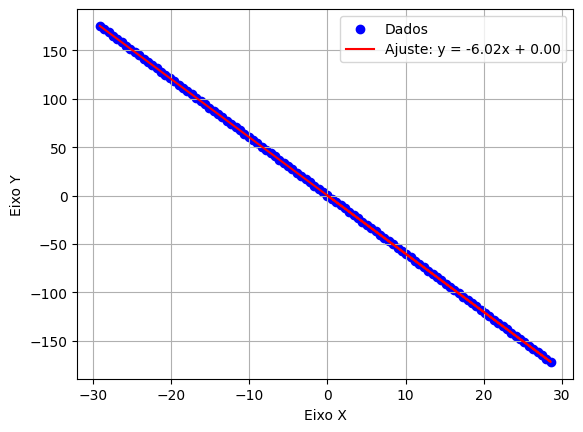

slope -6.020189769763303
dslope 0.00024712911487529896
len(ttime) 105
l+l2 106
l2 2
ttime [-29.120990476207226, -28.560990476195002, -28.00099047619733, -27.44099047619966, -26.880990476201987, -26.320990476204315, -25.760990476206644, -25.20099047619442, -24.640990476196748, -24.080990476199077, -23.520990476201405, -22.960990476203733, -22.40099047620606, -21.840990476193838, -21.280990476196166, -20.720990476198494, -20.160990476200823, -19.60099047620315, -19.04099047620548, -18.480990476193256, -17.920990476195584, -17.360990476197912, -16.80099047620024, -16.24099047620257, -15.680990476204897, -15.120990476207226, -14.560990476195002, -14.00099047619733, -13.439990476195817, -12.879990476198145, -12.319990476200473, -11.759990476202802, -11.19999047620513, -10.639990476207458, -10.079990476195235, -9.519990476197563, -8.959990476199891, -8.39999047620222, -7.839990476204548, -7.279990476206876, -6.719990476194653, -6.159990476196981, -5.599990476199309, -5.039990476201638, -4.47

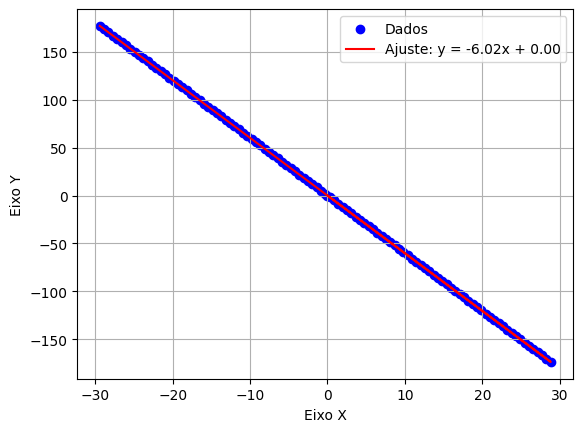

slope -6.02101253727466
dslope 0.0002504775405890851
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401113207553863, -28.84111320755619, -28.28111320755852, -27.721113207560848, -27.161113207548624, -26.601113207550952, -26.04111320755328, -25.48111320755561, -24.921113207557937, -24.361113207560265, -23.801113207562594, -23.24111320755037, -22.6811132075527, -22.121113207555027, -21.561113207557355, -21.001113207559683, -20.44111320756201, -19.881113207549788, -19.321113207552116, -18.761113207554445, -18.201113207556773, -17.6411132075591, -17.080113207557588, -16.520113207559916, -15.960113207562244, -15.400113207550021, -14.84011320755235, -14.280113207554678, -13.720113207557006, -13.160113207559334, -12.600113207561662, -12.040113207549439, -11.480113207551767, -10.920113207554095, -10.360113207556424, -9.800113207558752, -9.24011320756108, -8.680113207548857, -8.120113207551185, -7.560113207553513, -7.000113207555842, -6.44011320755817, -5.880113207560498, -5.320113207548275, -4.760113

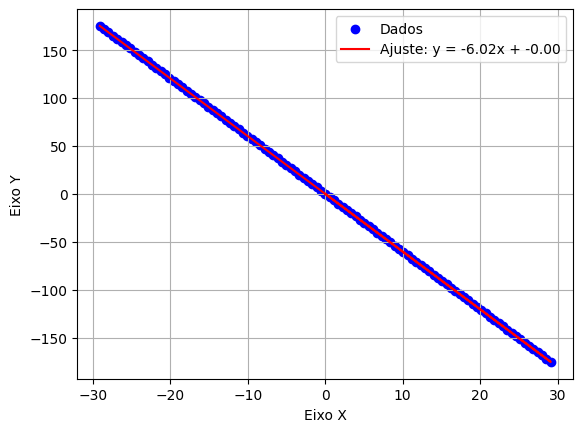

slope -6.021011580055984
dslope 0.00023790087250924753
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121238095249282, -28.56123809523706, -28.001238095239387, -27.441238095241715, -26.881238095244044, -26.321238095246372, -25.7612380952487, -25.201238095236477, -24.641238095238805, -24.081238095241133, -23.52123809524346, -22.96123809524579, -22.401238095248118, -21.841238095235894, -21.281238095238223, -20.72023809523671, -20.160238095239038, -19.600238095241366, -19.040238095243694, -18.480238095246023, -17.92023809524835, -17.360238095236127, -16.800238095238456, -16.240238095240784, -15.680238095243112, -15.12023809524544, -14.560238095247769, -14.000238095235545, -13.440238095237873, -12.880238095240202, -12.32023809524253, -11.760238095244858, -11.200238095247187, -10.640238095234963, -10.080238095237291, -9.52023809523962, -8.960238095241948, -8.400238095244276, -7.840238095246605, -7.280238095248933, -6.720238095236709, -6.160238095239038, -5.600238095241366, -5.040238095243694, -4.4

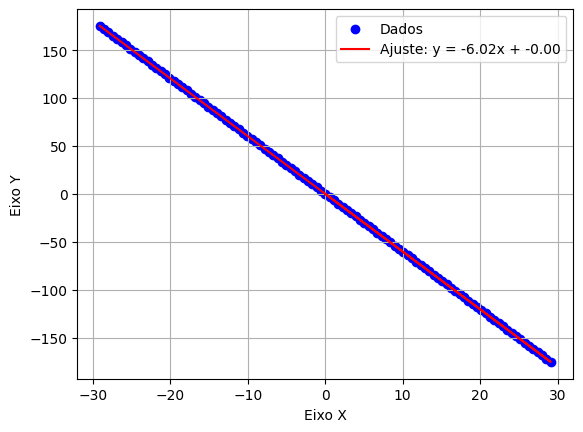

slope -6.020776493178615
dslope 0.00022448401064144316
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121371428569546, -28.561371428571874, -28.001371428574203, -27.44137142856198, -26.881371428564307, -26.321371428566636, -25.761371428568964, -25.201371428571292, -24.64037142856978, -24.080371428572107, -23.520371428574435, -22.960371428562212, -22.40037142856454, -21.84037142856687, -21.280371428569197, -20.720371428571525, -20.160371428573853, -19.60037142856163, -19.040371428563958, -18.480371428566286, -17.920371428568615, -17.360371428570943, -16.80037142857327, -16.2403714285756, -15.680371428563376, -15.120371428565704, -14.560371428568033, -14.00037142857036, -13.44037142857269, -12.880371428575017, -12.320371428562794, -11.760371428565122, -11.20037142856745, -10.640371428569779, -10.080371428572107, -9.520371428574435, -8.960371428562212, -8.40037142856454, -7.840371428566868, -7.280371428569197, -6.720371428571525, -6.160371428573853, -5.60037142856163, -5.040371428563958, -4.4803

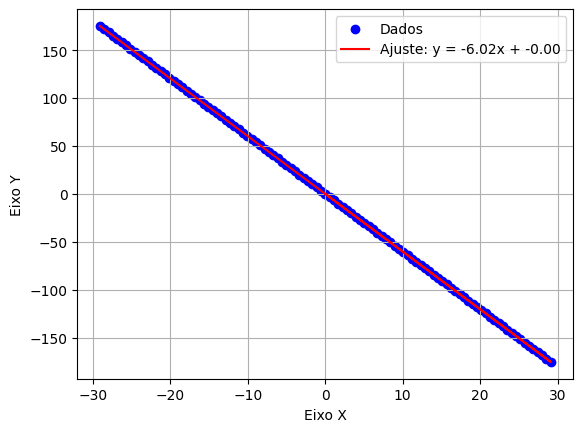

slope -6.0219815552259846
dslope 0.00023052239816760415
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12154285714496, -28.560542857143446, -28.000542857145774, -27.440542857148102, -26.88054285715043, -26.32054285715276, -25.760542857155087, -25.200542857142864, -24.640542857145192, -24.08054285714752, -23.52054285714985, -22.960542857152177, -22.400542857154505, -21.840542857156834, -21.28054285714461, -20.72054285714694, -20.160542857149267, -19.600542857151595, -19.040542857153923, -18.48054285715625, -17.920542857144028, -17.360542857146356, -16.800542857148685, -16.240542857151013, -15.680542857153341, -15.12054285715567, -14.560542857143446, -14.000542857145774, -13.440542857148102, -12.88054285715043, -12.320542857152759, -11.760542857155087, -11.200542857142864, -10.640542857145192, -10.08054285714752, -9.520542857149849, -8.960542857152177, -8.400542857154505, -7.840542857156834, -7.28054285714461, -6.720542857146938, -6.160542857149267, -5.600542857151595, -5.040542857153923, -4.48

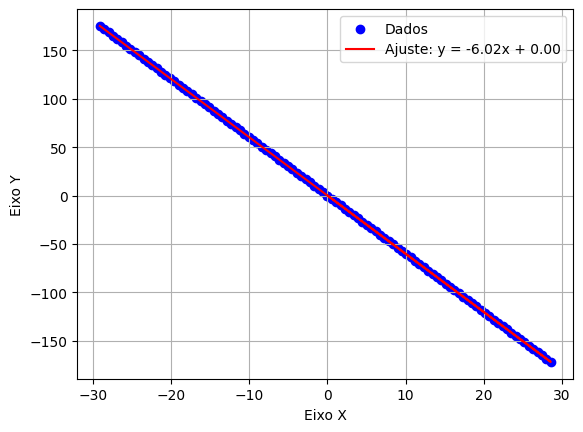

slope -6.021764671185965
dslope 0.0002369814752784361
len(ttime) 105
l+l2 106
l2 2
ttime [-29.120695238103508, -28.560695238105836, -28.000695238108165, -27.440695238110493, -26.88069523809827, -26.320695238100598, -25.760695238102926, -25.200695238105254, -24.640695238107583, -24.08069523810991, -23.520695238097687, -22.960695238100016, -22.400695238102344, -21.840695238104672, -21.280695238107, -20.72069523810933, -20.160695238097105, -19.600695238099433, -19.040695238101762, -18.48069523810409, -17.92069523810642, -17.360695238108747, -16.800695238096523, -16.24069523809885, -15.68069523810118, -15.120695238103508, -14.560695238105836, -14.000695238108165, -13.440695238110493, -12.88069523809827, -12.320695238100598, -11.760695238102926, -11.200695238105254, -10.640695238107583, -10.08069523810991, -9.520695238097687, -8.960695238100016, -8.400695238102344, -7.840695238104672, -7.2806952381070005, -6.720695238109329, -6.160695238097105, -5.6006952380994335, -5.040695238101762, -4.47

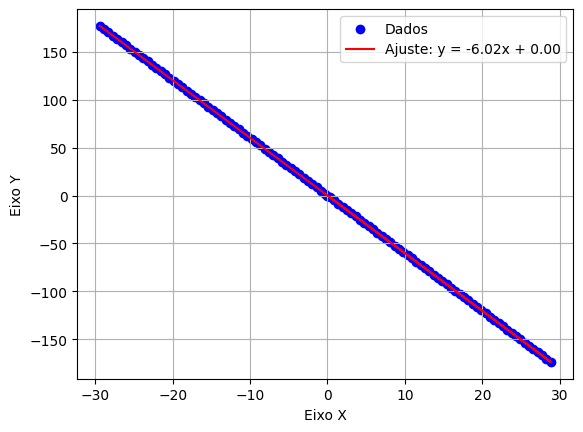

slope -6.021165750808969
dslope 0.0002516407630762837
len(ttime) 106
l+l2 107
l2 2
ttime [-29.40081132076739, -28.840811320755165, -28.280811320757493, -27.72081132075982, -27.16081132076215, -26.60081132076448, -26.040811320766807, -25.480811320754583, -24.92081132075691, -24.36081132075924, -23.800811320761568, -23.240811320763896, -22.680811320766225, -22.120811320754, -21.56081132075633, -21.000811320758658, -20.440811320760986, -19.880811320763314, -19.320811320765642, -18.76081132076797, -18.200811320755747, -17.640811320758075, -17.080811320760404, -16.520811320762732, -15.96081132076506, -15.400811320767389, -14.840811320755165, -14.280811320757493, -13.720811320759822, -13.16081132076215, -12.600811320764478, -12.040811320766807, -11.480811320754583, -10.920811320756911, -10.36081132075924, -9.800811320761568, -9.240811320763896, -8.680811320766225, -8.119811320764711, -7.559811320767039, -6.999811320754816, -6.439811320757144, -5.879811320759472, -5.319811320761801, -4.759811

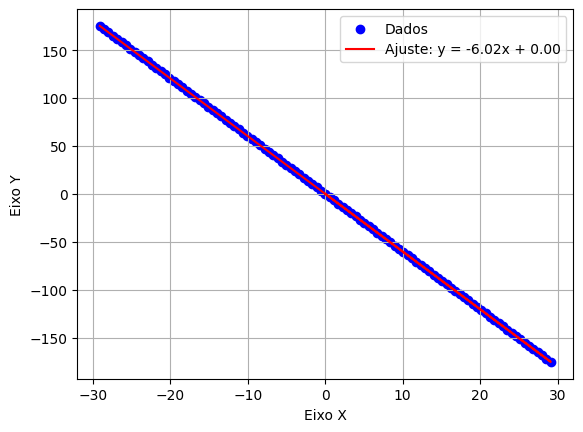

slope -6.021099541263859
dslope 0.00024541292370832795
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120942857145565, -28.560942857147893, -28.00094285715022, -27.440942857137998, -26.880942857140326, -26.320942857142654, -25.760942857144983, -25.20094285714731, -24.64094285714964, -24.080942857151967, -23.520942857139744, -22.960942857142072, -22.4009428571444, -21.84094285714673, -21.280942857149057, -20.720942857151385, -20.160942857139162, -19.60094285714149, -19.04094285714382, -18.480942857146147, -17.920942857148475, -17.360942857150803, -16.80094285713858, -16.240942857140908, -15.680942857143236, -15.120942857145565, -14.560942857147893, -14.000942857150221, -13.440942857137998, -12.880942857140326, -12.320942857142654, -11.75994285714114, -11.19994285714347, -10.639942857145797, -10.079942857148126, -9.519942857150454, -8.95994285713823, -8.399942857140559, -7.839942857142887, -7.279942857145215, -6.719942857147544, -6.159942857149872, -5.5999428571522, -5.039942857139977, -4.47994

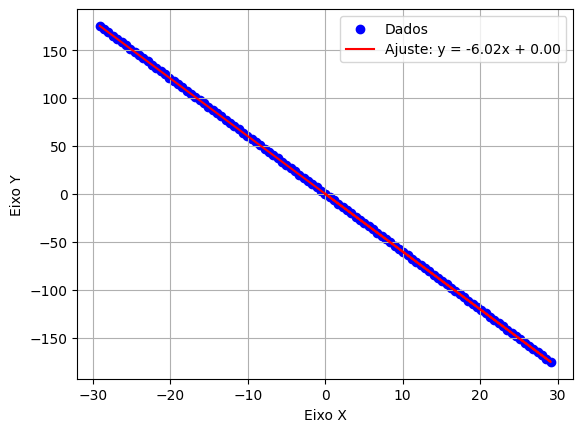

slope -6.021715076456762
dslope 0.0002408294881947303
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121066666659317, -28.561066666661645, -28.001066666663974, -27.441066666666302, -26.88106666666863, -26.32106666667096, -25.761066666658735, -25.201066666661063, -24.64106666666339, -24.08106666666572, -23.521066666668048, -22.961066666670376, -22.401066666658153, -21.84106666666048, -21.28106666666281, -20.721066666665138, -20.161066666667466, -19.601066666669794, -19.041066666672123, -18.4810666666599, -17.921066666662227, -17.361066666664556, -16.801066666666884, -16.241066666669212, -15.680066666667699, -15.120066666670027, -14.560066666657804, -14.000066666660132, -13.44006666666246, -12.880066666664788, -12.320066666667117, -11.760066666669445, -11.200066666671773, -10.64006666665955, -10.080066666661878, -9.520066666664206, -8.960066666666535, -8.400066666668863, -7.840066666671191, -7.280066666658968, -6.720066666661296, -6.160066666663624, -5.600066666665953, -5.040066666668281, -4.48

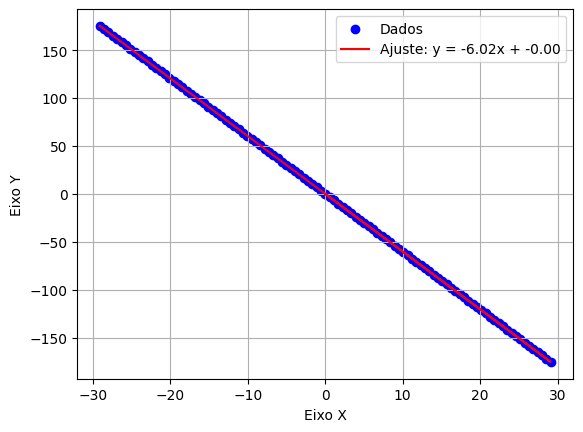

slope -6.021628466405937
dslope 0.00023264601684039204
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121199999994133, -28.56119999999646, -28.001199999984237, -27.441199999986566, -26.881199999988894, -26.321199999991222, -25.76119999999355, -25.20119999999588, -24.641199999998207, -24.081199999985984, -23.521199999988312, -22.96119999999064, -22.40119999999297, -21.841199999995297, -21.281199999997625, -20.7211999999854, -20.16119999998773, -19.600199999986216, -19.040199999988545, -18.480199999990873, -17.9201999999932, -17.36019999999553, -16.800199999997858, -16.240199999985634, -15.680199999987963, -15.120199999990291, -14.56019999999262, -14.000199999994948, -13.440199999997276, -12.880199999985052, -12.32019999998738, -11.760199999989709, -11.200199999992037, -10.640199999994365, -10.080199999996694, -9.52019999998447, -8.960199999986799, -8.400199999989127, -7.840199999991455, -7.280199999993783, -6.720199999996112, -6.160199999983888, -5.600199999986216, -5.040199999988545, -4.48019

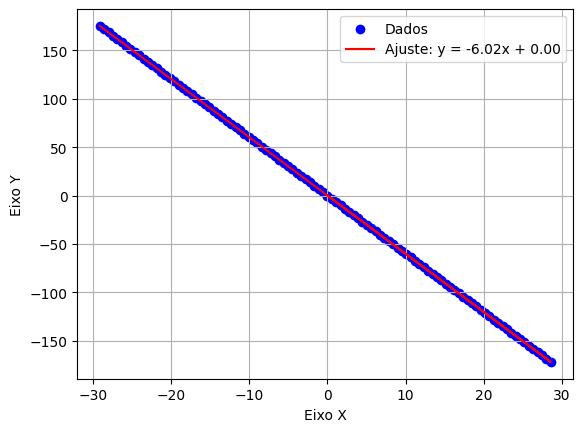

slope -6.02148793977759
dslope 0.00021909682308478778
len(ttime) 105
l+l2 106
l2 2
ttime [-29.1213333333435, -28.56133333334583, -28.001333333348157, -27.441333333350485, -26.881333333352813, -26.32133333334059, -25.761333333342918, -25.201333333345247, -24.641333333347575, -24.081333333349903, -23.52033333334839, -22.960333333350718, -22.400333333353046, -21.840333333340823, -21.28033333334315, -20.72033333334548, -20.160333333347808, -19.600333333350136, -19.040333333352464, -18.48033333334024, -17.92033333334257, -17.360333333344897, -16.800333333347226, -16.240333333349554, -15.680333333351882, -15.120333333339659, -14.560333333341987, -14.000333333344315, -13.440333333346643, -12.880333333348972, -12.3203333333513, -11.760333333353628, -11.200333333341405, -10.640333333343733, -10.080333333346061, -9.52033333334839, -8.960333333350718, -8.400333333353046, -7.840333333340823, -7.280333333343151, -6.720333333345479, -6.160333333347808, -5.600333333350136, -5.040333333352464, -4.4803

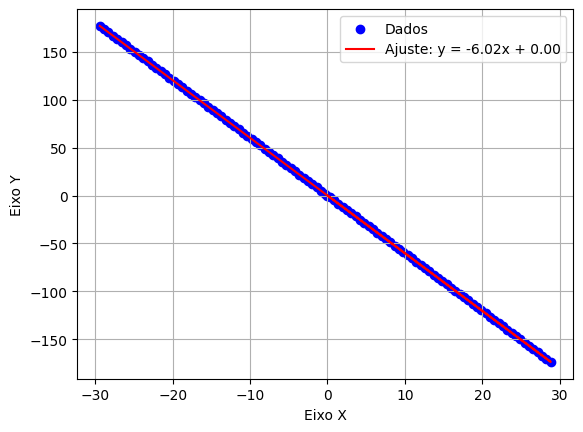

slope -6.021684429412921
dslope 0.00028122948710551546
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401471698118257, -28.841471698120586, -28.281471698108362, -27.72147169811069, -27.160471698109177, -26.600471698111505, -26.040471698113834, -25.480471698116162, -24.92047169811849, -24.36047169812082, -23.800471698108595, -23.240471698110923, -22.68047169811325, -22.12047169811558, -21.560471698117908, -21.000471698120236, -20.440471698108013, -19.88047169811034, -19.32047169811267, -18.760471698114998, -18.200471698117326, -17.640471698119654, -17.080471698121983, -16.52047169810976, -15.960471698112087, -15.400471698114416, -14.840471698116744, -14.280471698119072, -13.7204716981214, -13.160471698109177, -12.600471698111505, -12.040471698113834, -11.480471698116162, -10.92047169811849, -10.360471698120818, -9.800471698108595, -9.240471698110923, -8.680471698113251, -8.12047169811558, -7.560471698117908, -7.000471698120236, -6.440471698108013, -5.880471698110341, -5.320471698112669, -4.760

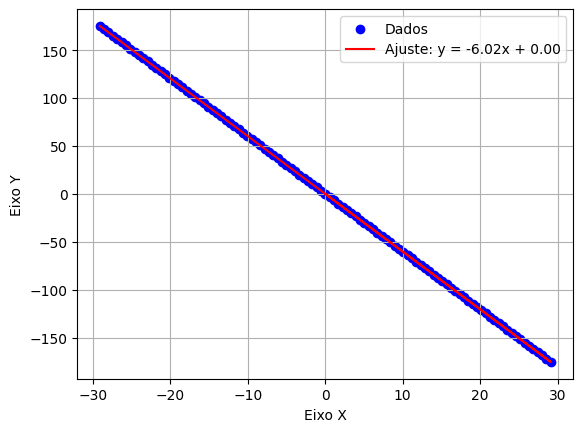

slope -6.022032305650834
dslope 0.0002530829032667372
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120628571428824, -28.560628571431153, -28.00062857143348, -27.44062857143581, -26.880628571438137, -26.320628571440466, -25.760628571428242, -25.20062857143057, -24.6406285714329, -24.080628571435227, -23.520628571437555, -22.960628571439884, -22.400628571442212, -21.84062857142999, -21.280628571432317, -20.720628571434645, -20.160628571436973, -19.6006285714393, -19.04062857144163, -18.480628571429406, -17.920628571431735, -17.360628571434063, -16.80062857143639, -16.24062857143872, -15.680628571441048, -15.120628571428824, -14.560628571431153, -14.00062857143348, -13.44062857143581, -12.880628571438137, -12.320628571440466, -11.760628571428242, -11.20062857143057, -10.640628571432899, -10.080628571435227, -9.520628571437555, -8.960628571439884, -8.400628571442212, -7.840628571429988, -7.280628571432317, -6.720628571434645, -6.160628571436973, -5.600628571439302, -5.04062857144163, -4.4806285

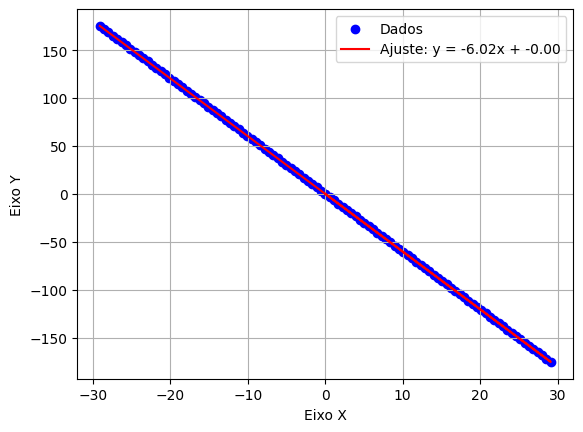

slope -6.021362448510458
dslope 0.00022410705004615459
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12076190476364, -28.560761904765968, -28.000761904768297, -27.440761904756073, -26.8807619047584, -26.32076190476073, -25.760761904763058, -25.200761904765386, -24.640761904767714, -24.08076190475549, -23.52076190475782, -22.960761904760147, -22.400761904762476, -21.840761904764804, -21.280761904767132, -20.72076190475491, -20.160761904757237, -19.600761904759565, -19.040761904761894, -18.480761904764222, -17.92076190476655, -17.360761904754327, -16.800761904756655, -16.240761904758983, -15.680761904761312, -15.12076190476364, -14.560761904765968, -14.000761904768297, -13.440761904756073, -12.880761904758401, -12.32076190476073, -11.760761904763058, -11.200761904765386, -10.640761904767714, -10.08076190475549, -9.52076190475782, -8.960761904760147, -8.400761904762476, -7.840761904764804, -7.280761904767132, -6.719761904765619, -6.159761904767947, -5.599761904755724, -5.039761904758052, -4.479

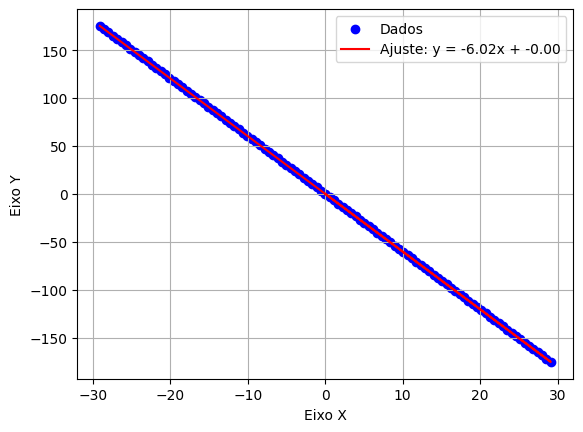

slope -6.021340734946451
dslope 0.00021656512745948022
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120904761904967, -28.560904761907295, -28.000904761909624, -27.440904761911952, -26.88090476191428, -26.320904761902057, -25.760904761904385, -25.200904761906713, -24.64090476190904, -24.08090476191137, -23.520904761913698, -22.960904761901475, -22.400904761903803, -21.84090476190613, -21.28090476190846, -20.720904761910788, -20.160904761913116, -19.600904761915444, -19.04090476190322, -18.48090476190555, -17.920904761907877, -17.360904761910206, -16.800904761912534, -16.240904761914862, -15.680904761902639, -15.120904761904967, -14.560904761907295, -14.000904761909624, -13.440904761911952, -12.88090476191428, -12.320904761902057, -11.760904761904385, -11.200904761906713, -10.6399047619052, -10.079904761907528, -9.519904761909856, -8.959904761912185, -8.399904761914513, -7.8399047619022895, -7.279904761904618, -6.719904761906946, -6.159904761909274, -5.599904761911603, -5.039904761913931, -4.

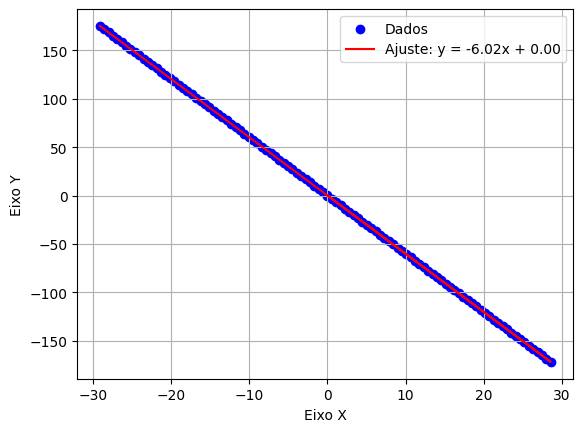

slope -6.021247153271156
dslope 0.00021164519544776376
len(ttime) 105
l+l2 106
l2 2
ttime [-29.121028571447823, -28.56102857145015, -28.001028571437928, -27.441028571440256, -26.881028571442585, -26.321028571444913, -25.76102857144724, -25.20102857144957, -24.641028571437346, -24.081028571439674, -23.521028571442002, -22.96102857144433, -22.40102857144666, -21.841028571448987, -21.281028571436764, -20.721028571439092, -20.16102857144142, -19.60102857144375, -19.041028571446077, -18.481028571448405, -17.92102857143618, -17.36102857143851, -16.80102857144084, -16.241028571443167, -15.681028571445495, -15.121028571447823, -14.56002857144631, -14.000028571448638, -13.440028571436414, -12.880028571438743, -12.320028571441071, -11.7600285714434, -11.200028571445728, -10.640028571448056, -10.080028571435832, -9.52002857143816, -8.960028571440489, -8.400028571442817, -7.840028571445146, -7.280028571447474, -6.720028571449802, -6.160028571437579, -5.600028571439907, -5.040028571442235, -4.48002

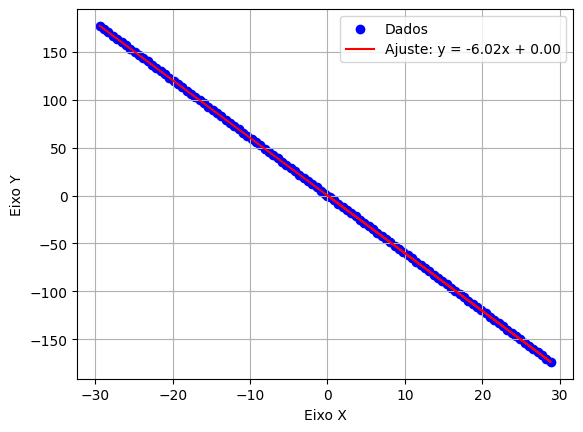

slope -6.021476359640232
dslope 0.00024008526048477176
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401150943376706, -28.841150943379034, -28.281150943381363, -27.72115094338369, -27.16115094338602, -26.601150943373796, -26.041150943376124, -25.481150943378452, -24.92115094338078, -24.36115094338311, -23.801150943385437, -23.241150943373214, -22.681150943375542, -22.12115094337787, -21.5611509433802, -21.001150943382527, -20.441150943384855, -19.881150943387183, -19.32115094337496, -18.761150943377288, -18.200150943375775, -17.640150943378103, -17.08015094338043, -16.52015094338276, -15.960150943385088, -15.400150943372864, -14.840150943375193, -14.280150943377521, -13.72015094337985, -13.160150943382178, -12.600150943384506, -12.040150943386834, -11.48015094337461, -10.920150943376939, -10.360150943379267, -9.800150943381595, -9.240150943383924, -8.680150943386252, -8.120150943374028, -7.560150943376357, -7.000150943378685, -6.440150943381013, -5.880150943383342, -5.32015094338567, -4.7601

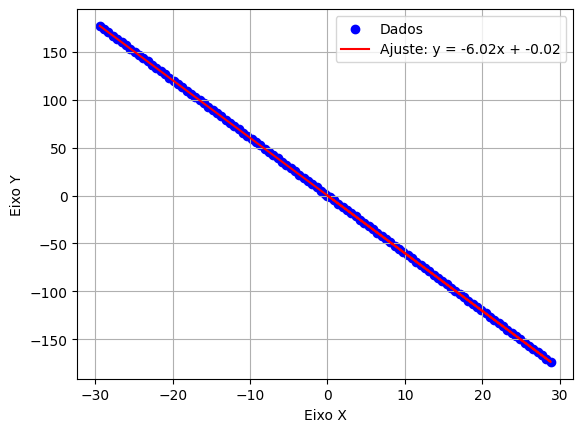

slope -6.020663318267234
dslope 0.00021445764800127575
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401283018873073, -28.84128301886085, -28.281283018863178, -27.721283018865506, -27.161283018867834, -26.601283018870163, -26.04128301887249, -25.48128301887482, -24.921283018862596, -24.361283018864924, -23.801283018867252, -23.24128301886958, -22.68128301887191, -22.120283018870396, -21.560283018872724, -21.000283018875052, -20.44028301886283, -19.880283018865157, -19.320283018867485, -18.760283018869814, -18.200283018872142, -17.64028301887447, -17.080283018862247, -16.520283018864575, -15.960283018866903, -15.400283018869231, -14.84028301887156, -14.280283018873888, -13.720283018861664, -13.160283018863993, -12.600283018866321, -12.04028301886865, -11.480283018870978, -10.920283018873306, -10.360283018861082, -9.80028301886341, -9.240283018865739, -8.680283018868067, -8.120283018870396, -7.560283018872724, -7.000283018875052, -6.440283018862829, -5.880283018865157, -5.320283018867485, -4.7

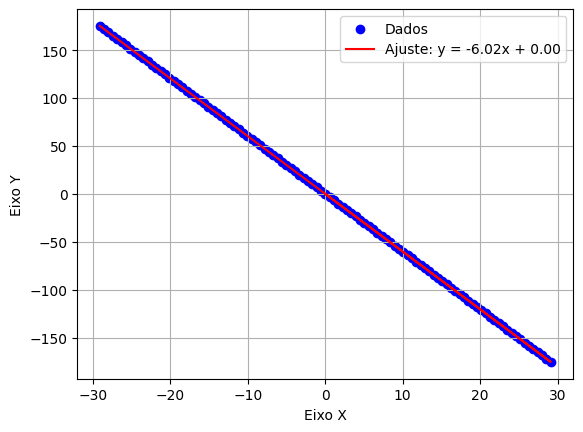

slope -6.0212735264966275
dslope 0.00022675052379024727
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121409523810144, -28.561409523812472, -28.0014095238148, -27.44140952381713, -26.881409523804905, -26.321409523807233, -25.76040952380572, -25.200409523808048, -24.640409523810376, -24.080409523812705, -23.520409523815033, -22.96040952381736, -22.400409523805138, -21.840409523807466, -21.280409523809794, -20.720409523812123, -20.16040952381445, -19.60040952381678, -19.040409523804556, -18.480409523806884, -17.920409523809212, -17.36040952381154, -16.80040952381387, -16.240409523816197, -15.680409523803974, -15.120409523806302, -14.56040952380863, -14.000409523810958, -13.440409523813287, -12.880409523815615, -12.320409523817943, -11.76040952380572, -11.200409523808048, -10.640409523810376, -10.080409523812705, -9.520409523815033, -8.960409523817361, -8.400409523805138, -7.840409523807466, -7.280409523809794, -6.720409523812123, -6.160409523814451, -5.600409523816779, -5.040409523804556, -4.4

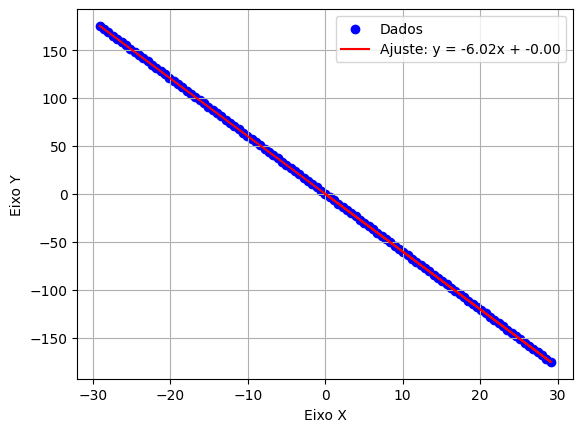

slope -6.021004170126701
dslope 0.00020334180519607212
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12059047620278, -28.560590476205107, -28.000590476192883, -27.44059047619521, -26.88059047619754, -26.320590476199868, -25.760590476202196, -25.200590476204525, -24.6405904761923, -24.08059047619463, -23.520590476196958, -22.960590476199286, -22.400590476201614, -21.840590476203943, -21.28059047619172, -20.720590476194047, -20.160590476196376, -19.600590476198704, -19.040590476201032, -18.48059047620336, -17.92059047620569, -17.360590476193465, -16.800590476195794, -16.240590476198122, -15.68059047620045, -15.120590476202779, -14.560590476205107, -14.000590476192883, -13.440590476195212, -12.88059047619754, -12.320590476199868, -11.760590476202196, -11.200590476204525, -10.640590476192301, -10.08059047619463, -9.520590476196958, -8.960590476199286, -8.400590476201614, -7.840590476203943, -7.280590476191719, -6.720590476194047, -6.160590476196376, -5.600590476198704, -5.040590476201032, -4.480

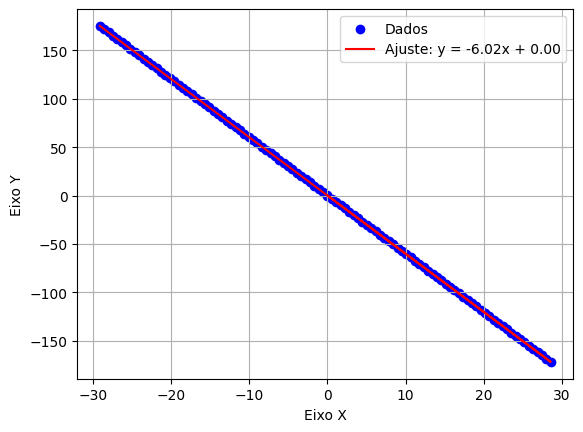

slope -6.02077669235091
dslope 0.00023203148630435407
len(ttime) 105
l+l2 106
l2 2
ttime [-29.120723809523042, -28.56072380952537, -28.0007238095277, -27.440723809530027, -26.880723809517804, -26.320723809520132, -25.76072380952246, -25.20072380952479, -24.640723809527117, -24.080723809529445, -23.520723809531773, -22.96072380951955, -22.400723809521878, -21.840723809524206, -21.280723809526535, -20.720723809528863, -20.16072380953119, -19.600723809518968, -19.040723809521296, -18.480723809523624, -17.920723809525953, -17.36072380952828, -16.80072380953061, -16.240723809518386, -15.680723809520714, -15.120723809523042, -14.56072380952537, -14.000723809527699, -13.440723809530027, -12.880723809517804, -12.320723809520132, -11.76072380952246, -11.200723809524789, -10.640723809527117, -10.080723809529445, -9.520723809531773, -8.96072380951955, -8.400723809521878, -7.8407238095242064, -7.280723809526535, -6.720723809528863, -6.160723809531191, -5.599723809529678, -5.039723809532006, -4.479

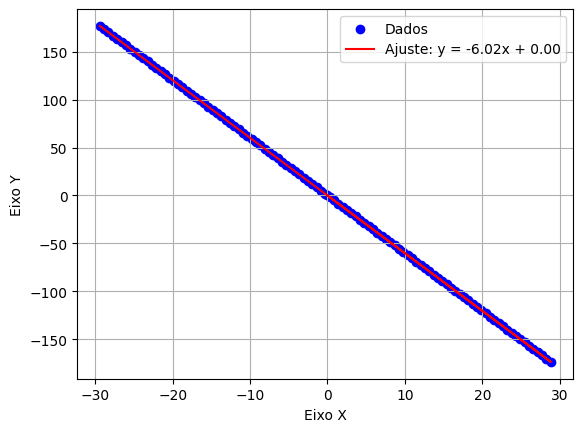

slope -6.021216248107127
dslope 0.00027078825200301036
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400849056590232, -28.84084905659256, -28.280849056580337, -27.720849056582665, -27.160849056584993, -26.60084905658732, -26.04084905658965, -25.48084905659198, -24.920849056579755, -24.360849056582083, -23.80084905658441, -23.24084905658674, -22.680849056589068, -22.120849056591396, -21.560849056579173, -21.0008490565815, -20.44084905658383, -19.880849056586158, -19.320849056588486, -18.760849056590814, -18.20084905657859, -17.64084905658092, -17.080849056583247, -16.520849056585575, -15.960849056587904, -15.400849056590232, -14.84084905659256, -14.280849056580337, -13.720849056582665, -13.160849056584993, -12.600849056587322, -12.04084905658965, -11.480849056591978, -10.920849056579755, -10.360849056582083, -9.800849056584411, -9.239849056582898, -8.679849056585226, -8.119849056587555, -7.559849056589883, -6.999849056592211, -6.4398490565799875, -5.879849056582316, -5.319849056584644, -4.759

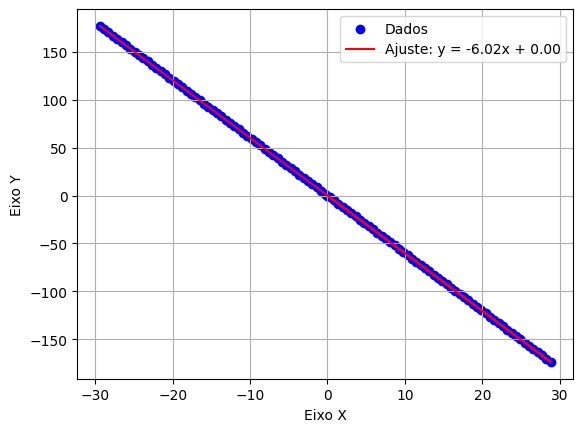

slope -6.020703376788329
dslope 0.0002576540927171128
len(ttime) 106
l+l2 107
l2 2
ttime [-29.4009811320866, -28.840981132088928, -28.280981132091256, -27.720981132093584, -27.16098113208136, -26.60098113208369, -26.040981132086017, -25.480981132088345, -24.920981132090674, -24.360981132093002, -23.80098113209533, -23.240981132083107, -22.680981132085435, -22.120981132087763, -21.56098113209009, -21.00098113209242, -20.44098113209475, -19.880981132082525, -19.320981132084853, -18.76098113208718, -18.20098113208951, -17.640981132091838, -17.080981132094166, -16.520981132081943, -15.960981132084271, -15.4009811320866, -14.840981132088928, -14.280981132091256, -13.720981132093584, -13.15998113209207, -12.599981132094399, -12.039981132082175, -11.479981132084504, -10.919981132086832, -10.35998113208916, -9.799981132091489, -9.239981132093817, -8.679981132081593, -8.119981132083922, -7.55998113208625, -6.999981132088578, -6.439981132090907, -5.879981132093235, -5.319981132081011, -4.7599811

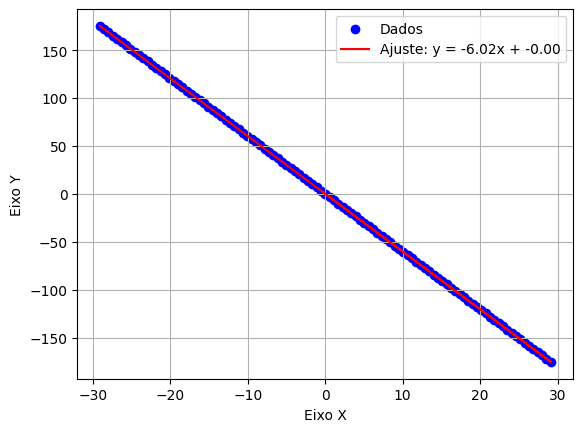

slope -6.021917323699438
dslope 0.00021628709328906567
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121114285720978, -28.561114285708754, -28.001114285711083, -27.44111428571341, -26.88111428571574, -26.321114285718068, -25.761114285720396, -25.201114285708172, -24.6411142857105, -24.08111428571283, -23.521114285715157, -22.961114285717485, -22.401114285719814, -21.84111428570759, -21.28111428570992, -20.721114285712247, -20.161114285714575, -19.601114285716903, -19.04111428571923, -18.481114285707008, -17.921114285709336, -17.361114285711665, -16.80011428571015, -16.24011428571248, -15.680114285714808, -15.120114285717136, -14.560114285719465, -14.000114285707241, -13.44011428570957, -12.880114285711898, -12.320114285714226, -11.760114285716554, -11.200114285718882, -10.640114285706659, -10.080114285708987, -9.520114285711315, -8.960114285713644, -8.400114285715972, -7.8401142857183, -7.280114285720629, -6.720114285708405, -6.160114285710733, -5.600114285713062, -5.04011428571539, -4.48011

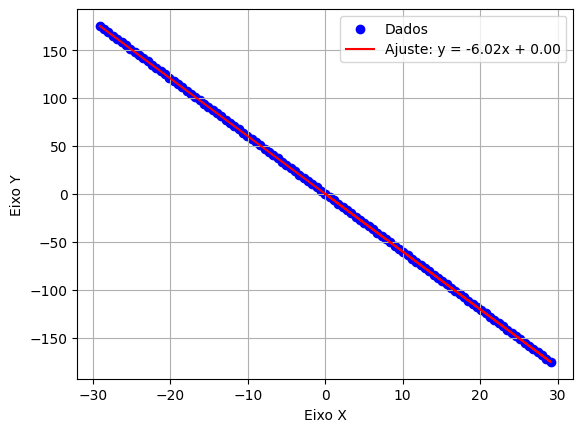

slope -6.020829063702252
dslope 0.00021034251915137217
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12123809523473, -28.56123809523706, -28.001238095239387, -27.441238095227163, -26.88123809522949, -26.32123809523182, -25.761238095234148, -25.201238095236477, -24.641238095238805, -24.08123809522658, -23.52123809522891, -22.961238095231238, -22.401238095233566, -21.841238095235894, -21.281238095238223, -20.72023809523671, -20.160238095239038, -19.600238095226814, -19.040238095229142, -18.48023809523147, -17.9202380952338, -17.360238095236127, -16.800238095238456, -16.240238095240784, -15.68023809522856, -15.120238095230889, -14.560238095233217, -14.000238095235545, -13.440238095237873, -12.880238095240202, -12.320238095227978, -11.760238095230306, -11.200238095232635, -10.640238095234963, -10.080238095237291, -9.52023809523962, -8.960238095227396, -8.400238095229724, -7.840238095232053, -7.280238095234381, -6.720238095236709, -6.160238095239038, -5.600238095226814, -5.040238095229142, -4.480

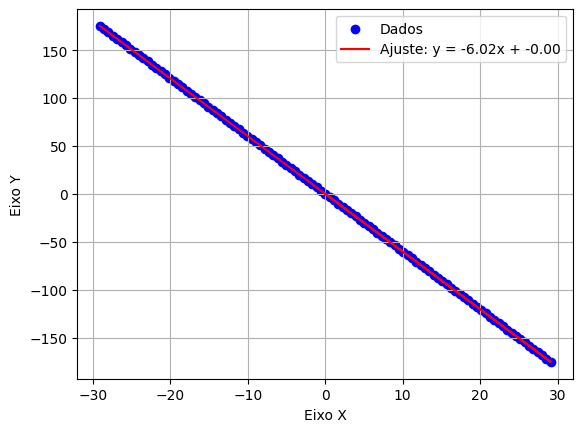

slope -6.019540007763683
dslope 0.00023255636995033323
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121371428554994, -28.561371428557322, -28.00137142855965, -27.44137142856198, -26.881371428564307, -26.321371428566636, -25.761371428554412, -25.20137142855674, -24.640371428555227, -24.080371428557555, -23.520371428559883, -22.960371428562212, -22.40037142856454, -21.84037142856687, -21.280371428554645, -20.720371428556973, -20.1603714285593, -19.60037142856163, -19.040371428563958, -18.480371428566286, -17.920371428554063, -17.36037142855639, -16.80037142855872, -16.240371428561048, -15.680371428563376, -15.120371428565704, -14.56037142855348, -14.000371428555809, -13.440371428558137, -12.880371428560466, -12.320371428562794, -11.760371428565122, -11.200371428552899, -10.640371428555227, -10.080371428557555, -9.520371428559883, -8.960371428562212, -8.40037142856454, -7.840371428566868, -7.280371428554645, -6.720371428556973, -6.160371428559301, -5.60037142856163, -5.040371428563958, -4.4803

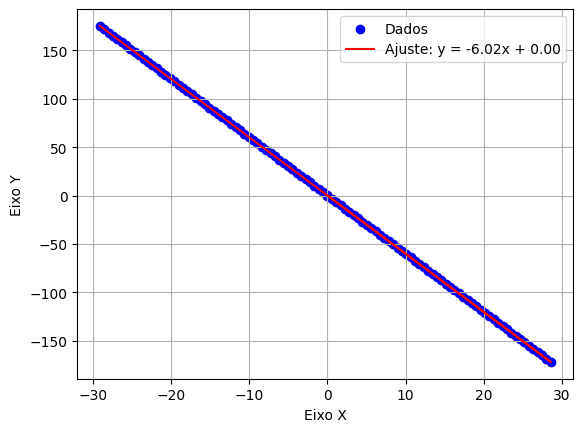

slope -6.020768657365777
dslope 0.00023094791915119026
len(ttime) 105
l+l2 106
l2 2
ttime [-29.12154285714496, -28.560542857143446, -28.000542857145774, -27.440542857148102, -26.88054285713588, -26.320542857138207, -25.760542857140535, -25.200542857142864, -24.640542857145192, -24.08054285714752, -23.520542857135297, -22.960542857137625, -22.400542857139953, -21.84054285714228, -21.28054285714461, -20.72054285714694, -20.160542857134715, -19.600542857137043, -19.04054285713937, -18.4805428571417, -17.920542857144028, -17.360542857146356, -16.800542857134133, -16.24054285713646, -15.68054285713879, -15.120542857141118, -14.560542857143446, -14.000542857145774, -13.440542857148102, -12.880542857135879, -12.320542857138207, -11.760542857140535, -11.200542857142864, -10.640542857145192, -10.08054285714752, -9.520542857135297, -8.960542857137625, -8.400542857139953, -7.840542857142282, -7.28054285714461, -6.720542857146938, -6.160542857134715, -5.600542857137043, -5.040542857139371, -4.4805

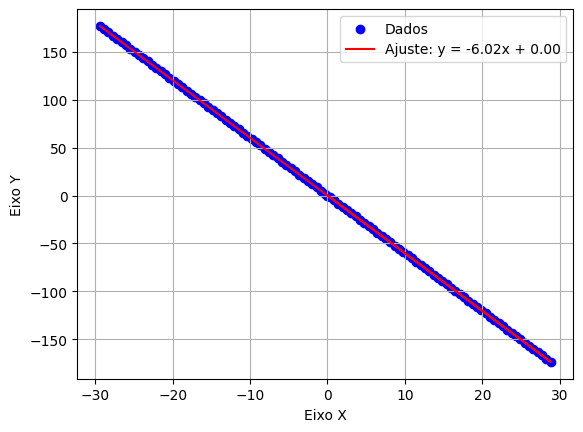

slope -6.020543787298691
dslope 0.00023585007990642643
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400679245285573, -28.84067924527335, -28.280679245275678, -27.720679245278006, -27.160679245280335, -26.600679245282663, -26.04067924528499, -25.480679245272768, -24.920679245275096, -24.360679245277424, -23.800679245279753, -23.24067924528208, -22.68067924528441, -22.120679245272186, -21.560679245274514, -21.000679245276842, -20.44067924527917, -19.8806792452815, -19.320679245283827, -18.760679245286155, -18.200679245273932, -17.64067924527626, -17.08067924527859, -16.520679245280917, -15.960679245283245, -15.400679245285573, -14.84067924527335, -14.280679245275678, -13.720679245278006, -13.160679245280335, -12.600679245282663, -12.040679245284991, -11.480679245272768, -10.920679245275096, -10.360679245277424, -9.800679245279753, -9.240679245282081, -8.68067924528441, -8.120679245272186, -7.560679245274514, -7.000679245276842, -6.440679245279171, -5.880679245281499, -5.320679245283827, -4.76

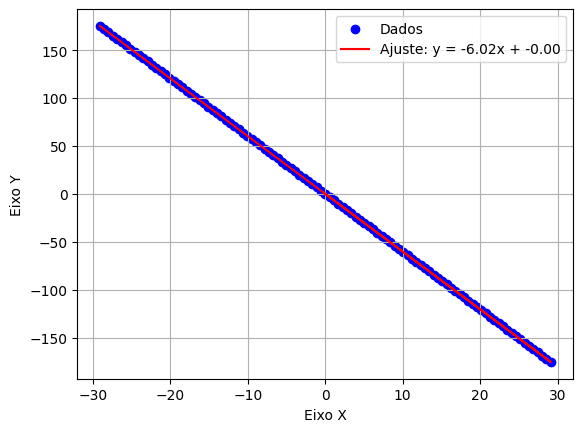

slope -6.0202052487644
dslope 0.00021581453848537008
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120800000004238, -28.560800000006566, -28.000800000008894, -27.44079999999667, -26.880799999999, -26.320800000001327, -25.760800000003655, -25.200800000005984, -24.640800000008312, -24.08080000001064, -23.520799999998417, -22.960800000000745, -22.400800000003073, -21.8408000000054, -21.28080000000773, -20.72080000001006, -20.160799999997835, -19.600800000000163, -19.04080000000249, -18.48080000000482, -17.920800000007148, -17.360800000009476, -16.800799999997253, -16.24079999999958, -15.68080000000191, -15.120800000004238, -14.560800000006566, -14.000800000008894, -13.44079999999667, -12.880799999998999, -12.320800000001327, -11.760800000003655, -11.200800000005984, -10.640800000008312, -10.08080000001064, -9.520799999998417, -8.960800000000745, -8.400800000003073, -7.83980000000156, -7.279800000003888, -6.719800000006217, -6.159800000008545, -5.599800000010873, -5.03979999999865, -4.4798000000

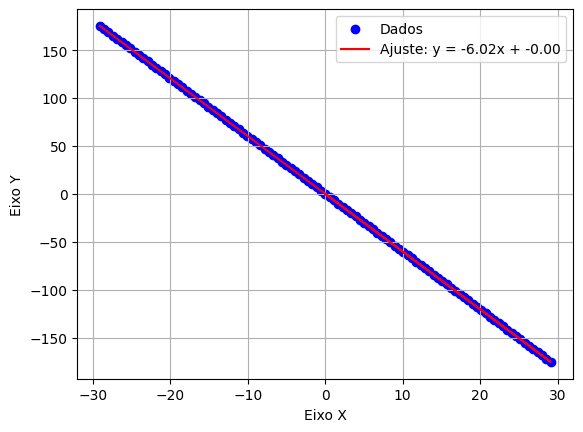

slope -6.020463035148768
dslope 0.00022162777470414424
len(ttime) 106
l+l2 106
l2 1
ttime [-29.1209333333245, -28.56093333332683, -28.000933333329158, -27.440933333331486, -26.880933333333815, -26.320933333336143, -25.76093333332392, -25.200933333326248, -24.640933333328576, -24.080933333330904, -23.520933333333232, -22.96093333333556, -22.400933333323337, -21.840933333325665, -21.280933333327994, -20.720933333330322, -20.16093333333265, -19.60093333333498, -19.040933333337307, -18.480933333325083, -17.92093333332741, -17.36093333332974, -16.80093333333207, -16.240933333334397, -15.680933333336725, -15.120933333324501, -14.56093333332683, -14.000933333329158, -13.440933333331486, -12.880933333333815, -12.320933333336143, -11.75993333333463, -11.199933333336958, -10.639933333324734, -10.079933333327062, -9.51993333332939, -8.959933333331719, -8.399933333334047, -7.839933333336376, -7.279933333324152, -6.71993333332648, -6.159933333328809, -5.599933333331137, -5.039933333333465, -4.47993

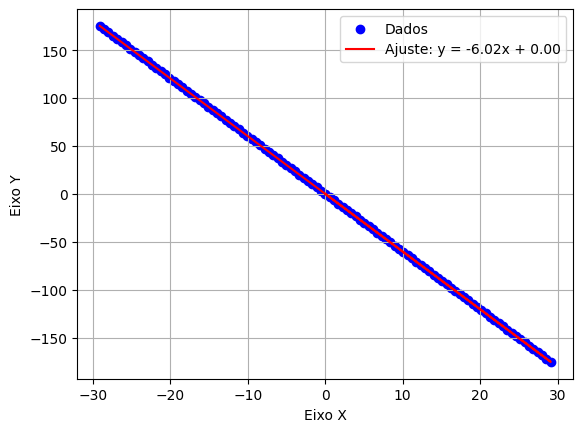

slope -6.019886514712295
dslope 0.00021944664428723564
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12107619048038, -28.56107619048271, -28.001076190470485, -27.441076190472813, -26.88107619047514, -26.32107619047747, -25.7610761904798, -25.201076190482127, -24.641076190484455, -24.08107619047223, -23.52107619047456, -22.961076190476888, -22.401076190479216, -21.841076190481544, -21.281076190483873, -20.72107619047165, -20.161076190473977, -19.601076190476306, -19.041076190478634, -18.481076190480962, -17.92107619048329, -17.361076190471067, -16.801076190473395, -16.241076190475724, -15.68007619047421, -15.120076190476539, -14.560076190478867, -14.000076190481195, -13.440076190483524, -12.8800761904713, -12.320076190473628, -11.760076190475957, -11.200076190478285, -10.640076190480613, -10.080076190482941, -9.520076190470718, -8.960076190473046, -8.400076190475374, -7.840076190477703, -7.280076190480031, -6.720076190482359, -6.160076190470136, -5.600076190472464, -5.040076190474792, -4.4800

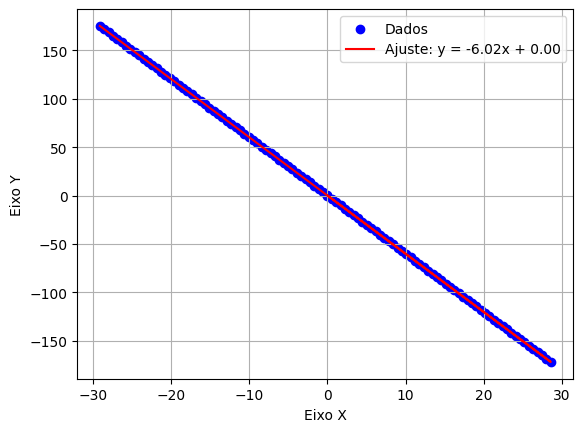

slope -6.019336179324094
dslope 0.00022245640370496334
len(ttime) 105
l+l2 106
l2 2
ttime [-29.121200000008685, -28.561200000011013, -28.00120000001334, -27.44120000001567, -26.881200000017998, -26.321200000005774, -25.761200000008103, -25.20120000001043, -24.64120000001276, -24.081200000015087, -23.521200000017416, -22.961200000005192, -22.40120000000752, -21.84120000000985, -21.281200000012177, -20.721200000014505, -20.161200000016834, -19.60020000001532, -19.04020000001765, -18.480200000005425, -17.920200000007753, -17.36020000001008, -16.80020000001241, -16.240200000014738, -15.680200000017066, -15.120200000004843, -14.560200000007171, -14.0002000000095, -13.440200000011828, -12.880200000014156, -12.320200000016484, -11.760200000018813, -11.200200000006589, -10.640200000008917, -10.080200000011246, -9.520200000013574, -8.960200000015902, -8.40020000001823, -7.840200000006007, -7.280200000008335, -6.720200000010664, -6.160200000012992, -5.60020000001532, -5.040200000017649, -4.48020

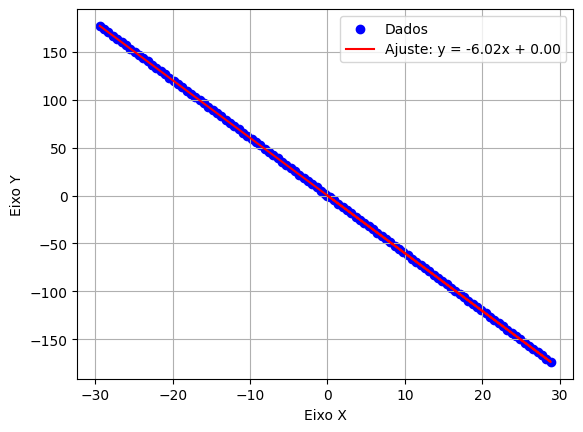

slope -6.0198867323445
dslope 0.00025877160344690825
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401330188673455, -28.841330188675784, -28.28133018866356, -27.72133018866589, -27.161330188668217, -26.601330188670545, -26.041330188672873, -25.4813301886752, -24.921330188662978, -24.361330188665306, -23.801330188667635, -23.24033018866612, -22.68033018866845, -22.120330188670778, -21.560330188673106, -21.000330188675434, -20.44033018866321, -19.88033018866554, -19.320330188667867, -18.760330188670196, -18.200330188672524, -17.640330188674852, -17.08033018867718, -16.520330188664957, -15.960330188667285, -15.400330188669614, -14.840330188671942, -14.28033018867427, -13.720330188676598, -13.160330188664375, -12.600330188666703, -12.040330188669031, -11.48033018867136, -10.920330188673688, -10.360330188676016, -9.800330188663793, -9.240330188666121, -8.68033018866845, -8.120330188670778, -7.560330188673106, -7.000330188675434, -6.440330188663211, -5.880330188665539, -5.320330188667867, -4.76033

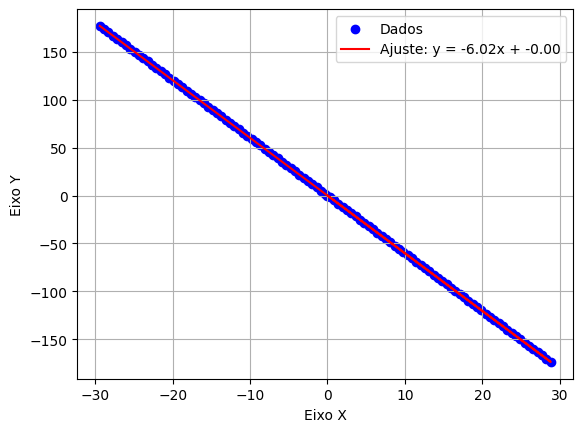

slope -6.019755786606606
dslope 0.0002318600630250119
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401471698103705, -28.841471698106034, -28.281471698108362, -27.72147169811069, -27.160471698109177, -26.600471698111505, -26.04047169809928, -25.48047169810161, -24.92047169810394, -24.360471698106267, -23.800471698108595, -23.240471698110923, -22.68047169811325, -22.120471698101028, -21.560471698103356, -21.000471698105684, -20.440471698108013, -19.88047169811034, -19.32047169811267, -18.760471698100446, -18.200471698102774, -17.640471698105102, -17.08047169810743, -16.52047169810976, -15.960471698112087, -15.400471698099864, -14.840471698102192, -14.28047169810452, -13.720471698106849, -13.160471698109177, -12.600471698111505, -12.040471698099282, -11.48047169810161, -10.920471698103938, -10.360471698106267, -9.800471698108595, -9.240471698110923, -8.680471698113251, -8.120471698101028, -7.560471698103356, -7.0004716981056845, -6.440471698108013, -5.880471698110341, -5.320471698112669, -4.76

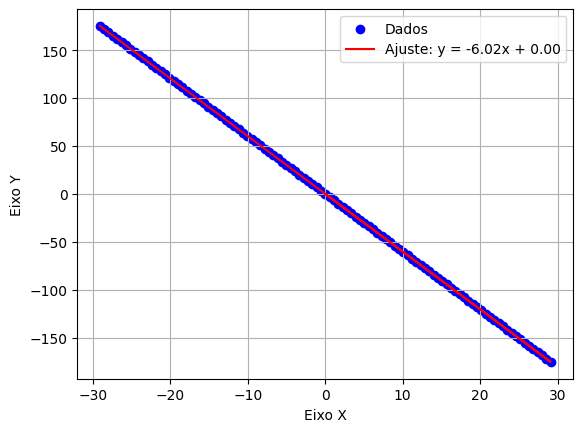

slope -6.02001520800237
dslope 0.00022556481692009533
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120628571428824, -28.560628571431153, -28.00062857143348, -27.440628571421257, -26.880628571423586, -26.320628571425914, -25.760628571428242, -25.20062857143057, -24.6406285714329, -24.080628571420675, -23.520628571423003, -22.96062857142533, -22.40062857142766, -21.84062857142999, -21.280628571432317, -20.720628571420093, -20.16062857142242, -19.60062857142475, -19.040628571427078, -18.480628571429406, -17.920628571431735, -17.36062857141951, -16.80062857142184, -16.240628571424168, -15.680628571426496, -15.120628571428824, -14.560628571431153, -14.00062857143348, -13.440628571421257, -12.880628571423586, -12.320628571425914, -11.760628571428242, -11.20062857143057, -10.640628571432899, -10.080628571420675, -9.520628571423003, -8.960628571425332, -8.40062857142766, -7.840628571429988, -7.280628571432317, -6.720628571420093, -6.160628571422421, -5.60062857142475, -5.040628571427078, -4.4806285

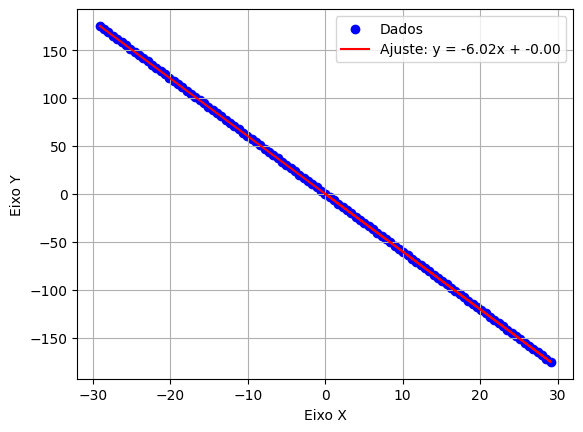

slope -6.020161920816492
dslope 0.0002114959388764843
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120761904749088, -28.560761904751416, -28.000761904753745, -27.440761904756073, -26.8807619047584, -26.320761904746178, -25.760761904748506, -25.200761904750834, -24.640761904753163, -24.08076190475549, -23.52076190475782, -22.960761904745596, -22.400761904747924, -21.840761904750252, -21.28076190475258, -20.72076190475491, -20.160761904757237, -19.600761904759565, -19.04076190474734, -18.48076190474967, -17.920761904752, -17.360761904754327, -16.800761904756655, -16.240761904758983, -15.68076190474676, -15.120761904749088, -14.560761904751416, -14.000761904753745, -13.440761904756073, -12.880761904758401, -12.320761904746178, -11.760761904748506, -11.200761904750834, -10.640761904753163, -10.08076190475549, -9.52076190475782, -8.960761904745596, -8.400761904747924, -7.840761904750252, -7.2807619047525804, -6.719761904751067, -6.159761904753395, -5.599761904755724, -5.039761904758052, -4.47976

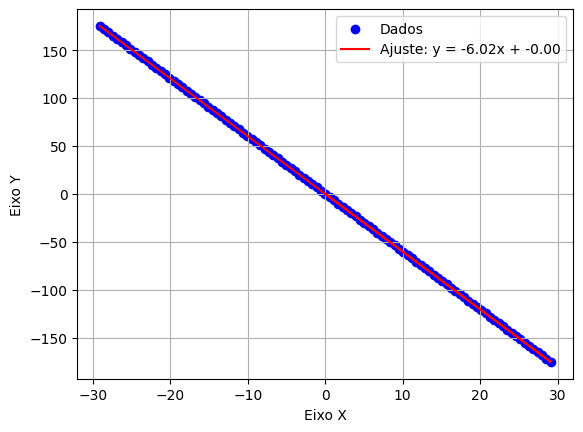

slope -6.019886726841602
dslope 0.00022469710903736152
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120895238098456, -28.560895238100784, -28.00089523808856, -27.44089523809089, -26.880895238093217, -26.320895238095545, -25.760895238097874, -25.200895238100202, -24.640895238087978, -24.080895238090307, -23.520895238092635, -22.960895238094963, -22.40089523809729, -21.84089523809962, -21.280895238087396, -20.720895238089724, -20.160895238092053, -19.60089523809438, -19.04089523809671, -18.480895238099038, -17.920895238086814, -17.360895238089142, -16.80089523809147, -16.2408952380938, -15.680895238096127, -15.120895238098456, -14.560895238100784, -14.00089523808856, -13.440895238090889, -12.880895238093217, -12.320895238095545, -11.760895238097874, -11.200895238100202, -10.639895238098688, -10.079895238086465, -9.519895238088793, -8.959895238091121, -8.39989523809345, -7.839895238095778, -7.279895238098106, -6.719895238100435, -6.159895238088211, -5.599895238090539, -5.039895238092868, -4.47

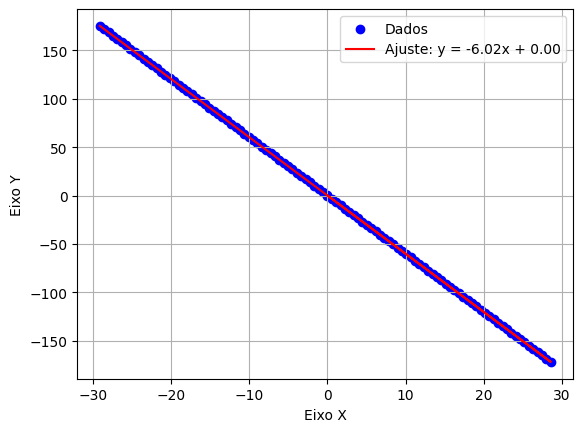

slope -6.019349718967907
dslope 0.00023024745982711895
len(ttime) 105
l+l2 106
l2 2
ttime [-29.121028571404167, -28.561028571406496, -28.001028571408824, -27.441028571411152, -26.88102857139893, -26.321028571401257, -25.761028571403585, -25.201028571405914, -24.641028571408242, -24.08102857141057, -23.521028571398347, -22.961028571400675, -22.401028571403003, -21.84102857140533, -21.28102857140766, -20.721028571409988, -20.161028571412317, -19.601028571400093, -19.04102857140242, -18.48102857140475, -17.921028571407078, -17.361028571409406, -16.801028571411734, -16.24102857139951, -15.68102857140184, -15.121028571404167, -14.560028571402654, -14.000028571404982, -13.44002857140731, -12.880028571409639, -12.320028571411967, -11.760028571399744, -11.200028571402072, -10.6400285714044, -10.080028571406729, -9.520028571409057, -8.960028571411385, -8.400028571399162, -7.84002857140149, -7.280028571403818, -6.7200285714061465, -6.160028571408475, -5.600028571410803, -5.0400285713985795, -4.4

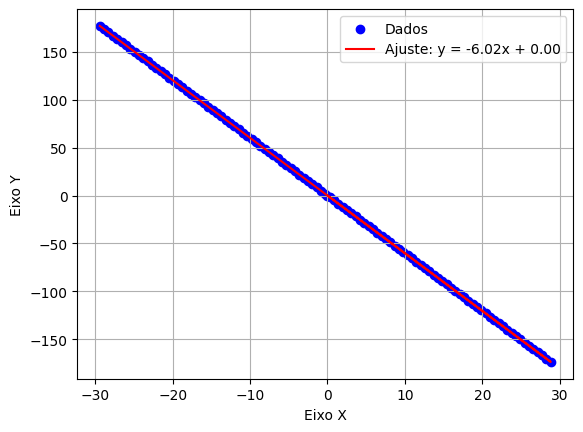

slope -6.019878900036498
dslope 0.0002226060365580877
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401150943391258, -28.841150943379034, -28.281150943381363, -27.72115094338369, -27.16115094338602, -26.601150943388348, -26.041150943390676, -25.481150943393004, -24.92115094338078, -24.36115094338311, -23.801150943385437, -23.241150943387765, -22.681150943390094, -22.121150943392422, -21.5611509433802, -21.001150943382527, -20.441150943384855, -19.881150943387183, -19.32115094338951, -18.76115094339184, -18.200150943390327, -17.640150943392655, -17.08015094338043, -16.52015094338276, -15.960150943385088, -15.400150943387416, -14.840150943389744, -14.280150943392073, -13.72015094337985, -13.160150943382178, -12.600150943384506, -12.040150943386834, -11.480150943389162, -10.92015094339149, -10.360150943379267, -9.800150943381595, -9.240150943383924, -8.680150943386252, -8.12015094338858, -7.560150943390909, -7.000150943393237, -6.440150943381013, -5.880150943383342, -5.32015094338567, -4.760150

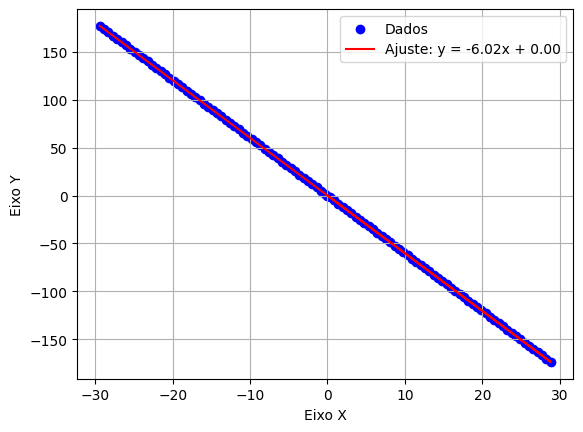

slope -6.020295581017396
dslope 0.0002218725306447583
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401292452821508, -28.841292452823836, -28.281292452826165, -27.721292452828493, -27.16129245281627, -26.601292452818598, -26.041292452820926, -25.481292452823254, -24.921292452825583, -24.36129245282791, -23.801292452815687, -23.241292452818016, -22.681292452820344, -22.12029245281883, -21.56029245282116, -21.000292452823487, -20.440292452825815, -19.880292452828144, -19.32029245281592, -18.76029245281825, -18.200292452820577, -17.640292452822905, -17.080292452825233, -16.52029245282756, -15.960292452815338, -15.400292452817666, -14.840292452819995, -14.280292452822323, -13.720292452824651, -13.16029245282698, -12.600292452829308, -12.040292452817084, -11.480292452819413, -10.92029245282174, -10.36029245282407, -9.800292452826397, -9.240292452828726, -8.680292452816502, -8.12029245281883, -7.560292452821159, -7.000292452823487, -6.440292452825815, -5.880292452828144, -5.32029245281592, -4.7602

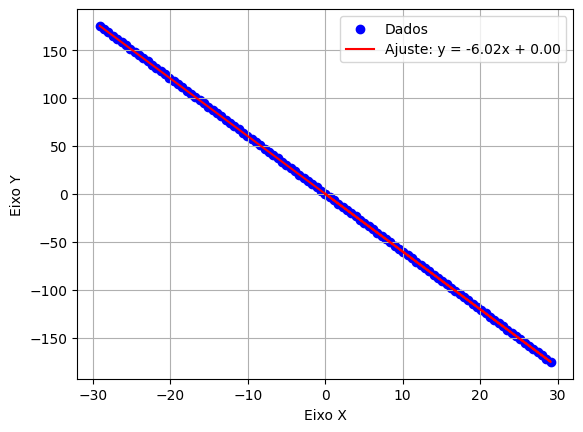

slope -6.020414684152739
dslope 0.00022481150227492987
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121409523810144, -28.561409523812472, -28.0014095238148, -27.44140952381713, -26.881409523819457, -26.321409523821785, -25.76040952382027, -25.2004095238226, -24.640409523810376, -24.080409523812705, -23.520409523815033, -22.96040952381736, -22.40040952381969, -21.840409523822018, -21.280409523809794, -20.720409523812123, -20.16040952381445, -19.60040952381678, -19.040409523819108, -18.480409523821436, -17.920409523823764, -17.36040952381154, -16.80040952381387, -16.240409523816197, -15.680409523818525, -15.120409523820854, -14.560409523823182, -14.000409523810958, -13.440409523813287, -12.880409523815615, -12.320409523817943, -11.760409523820272, -11.2004095238226, -10.640409523810376, -10.080409523812705, -9.520409523815033, -8.960409523817361, -8.40040952381969, -7.840409523822018, -7.280409523809794, -6.720409523812123, -6.160409523814451, -5.600409523816779, -5.040409523819108, -4.480409

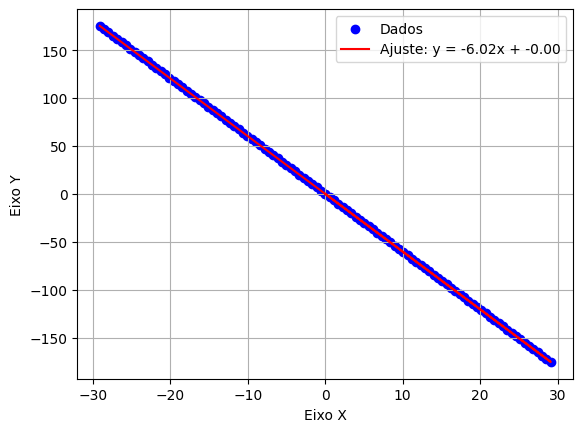

slope -6.0204180227911985
dslope 0.00023416109294858802
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120599999994738, -28.560599999997066, -28.000599999999395, -27.440600000001723, -26.8805999999895, -26.320599999991828, -25.760599999994156, -25.200599999996484, -24.640599999998813, -24.08060000000114, -23.52060000000347, -22.960599999991246, -22.400599999993574, -21.840599999995902, -21.28059999999823, -20.72060000000056, -20.160600000002887, -19.600599999990663, -19.040599999992992, -18.48059999999532, -17.92059999999765, -17.360599999999977, -16.800600000002305, -16.24059999999008, -15.68059999999241, -15.120599999994738, -14.560599999997066, -14.000599999999395, -13.440600000001723, -12.8805999999895, -12.320599999991828, -11.760599999994156, -11.200599999996484, -10.640599999998813, -10.08060000000114, -9.52060000000347, -8.960599999991246, -8.400599999993574, -7.840599999995902, -7.2805999999982305, -6.720600000000559, -6.160600000002887, -5.6005999999906635, -5.040599999992992, -4.48

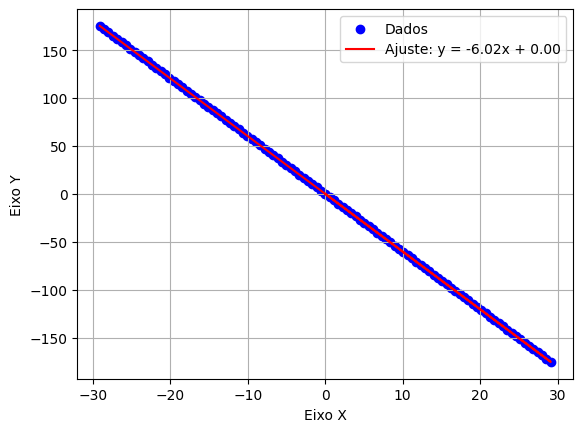

slope -6.021690092514235
dslope 0.00022684010630025483
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120723809523042, -28.56072380951082, -28.000723809513147, -27.440723809515475, -26.880723809517804, -26.320723809520132, -25.76072380952246, -25.200723809510237, -24.640723809512565, -24.080723809514893, -23.52072380951722, -22.96072380951955, -22.400723809521878, -21.840723809509655, -21.280723809511983, -20.72072380951431, -20.16072380951664, -19.600723809518968, -19.040723809521296, -18.480723809509072, -17.9207238095114, -17.36072380951373, -16.800723809516057, -16.240723809518386, -15.680723809520714, -15.120723809523042, -14.560723809510819, -14.000723809513147, -13.440723809515475, -12.880723809517804, -12.320723809520132, -11.76072380952246, -11.200723809510237, -10.640723809512565, -10.080723809514893, -9.520723809517222, -8.96072380951955, -8.400723809521878, -7.8407238095096545, -7.280723809511983, -6.720723809514311, -6.1607238095166394, -5.599723809515126, -5.039723809517454, -4.

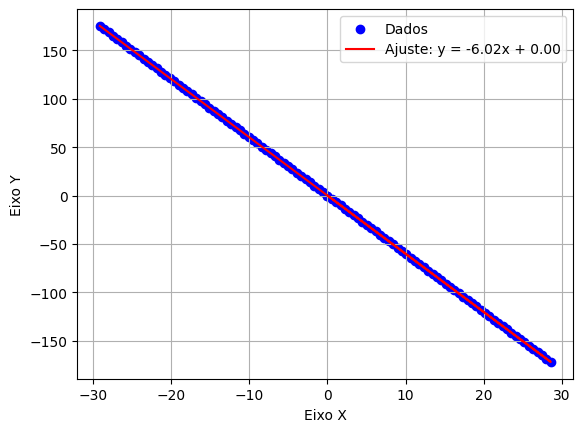

slope -6.0207599286387214
dslope 0.00019931874345367629
len(ttime) 105
l+l2 106
l2 2
ttime [-29.120857142857858, -28.560857142860186, -28.000857142862515, -27.44085714285029, -26.88085714285262, -26.320857142854948, -25.760857142857276, -25.200857142859604, -24.640857142861933, -24.08085714286426, -23.520857142852037, -22.960857142854366, -22.400857142856694, -21.840857142859022, -21.28085714286135, -20.72085714286368, -20.160857142851455, -19.600857142853783, -19.04085714285611, -18.48085714285844, -17.92085714286077, -17.360857142863097, -16.800857142850873, -16.2408571428532, -15.68085714285553, -15.120857142857858, -14.560857142860186, -14.000857142862515, -13.440857142850291, -12.88085714285262, -12.320857142854948, -11.760857142857276, -11.200857142859604, -10.640857142861933, -10.08085714286426, -9.519857142862747, -8.959857142850524, -8.399857142852852, -7.83985714285518, -7.279857142857509, -6.719857142859837, -6.159857142862165, -5.599857142849942, -5.03985714285227, -4.47985

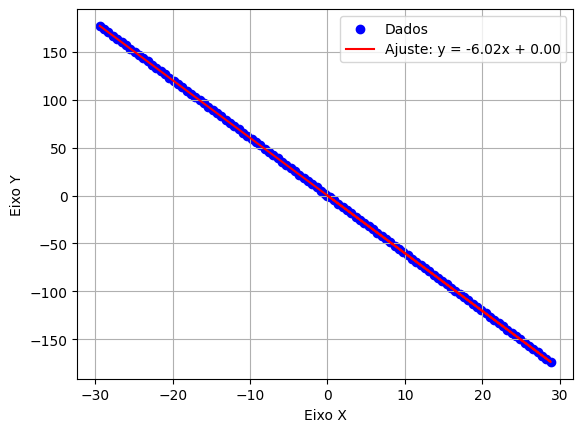

slope -6.021044569713685
dslope 0.00024043855886342422
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400981132072047, -28.840981132059824, -28.280981132062152, -27.72098113206448, -27.16098113206681, -26.600981132069137, -26.040981132071465, -25.48098113205924, -24.92098113206157, -24.3609811320639, -23.800981132066227, -23.240981132068555, -22.680981132070883, -22.12098113205866, -21.560981132060988, -21.000981132063316, -20.440981132065644, -19.880981132067973, -19.3209811320703, -18.760981132058077, -18.200981132060406, -17.640981132062734, -17.080981132065062, -16.52098113206739, -15.960981132069719, -15.400981132072047, -14.840981132059824, -14.280981132062152, -13.72098113206448, -13.159981132062967, -12.599981132065295, -12.039981132067624, -11.479981132069952, -10.919981132057728, -10.359981132060057, -9.799981132062385, -9.239981132064713, -8.679981132067041, -8.11998113206937, -7.559981132071698, -6.9999811320594745, -6.439981132061803, -5.879981132064131, -5.319981132066459, -4.75

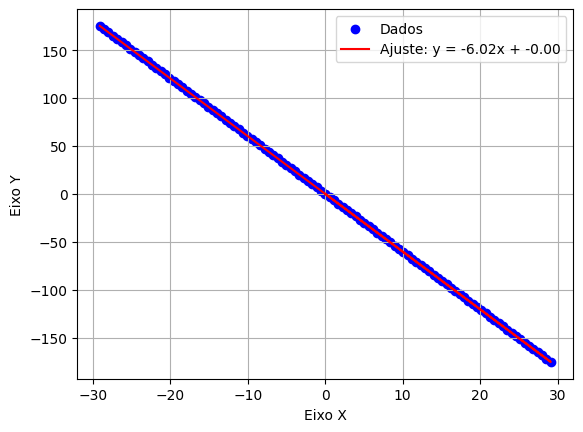

slope -6.021064796766164
dslope 0.00020752728040725763
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121104761899915, -28.561104761902243, -28.00110476190457, -27.441104761892348, -26.881104761894676, -26.321104761897004, -25.761104761899333, -25.20110476190166, -24.64110476190399, -24.081104761891766, -23.521104761894094, -22.961104761896422, -22.40110476189875, -21.84110476190108, -21.281104761903407, -20.721104761905735, -20.16110476189351, -19.60110476189584, -19.04110476189817, -18.481104761900497, -17.921104761902825, -17.361104761905153, -16.80010476190364, -16.240104761905968, -15.680104761893745, -15.120104761896073, -14.560104761898401, -14.00010476190073, -13.440104761903058, -12.880104761905386, -12.320104761893163, -11.76010476189549, -11.20010476189782, -10.640104761900147, -10.080104761902476, -9.520104761904804, -8.96010476189258, -8.400104761894909, -7.840104761897237, -7.280104761899565, -6.720104761901894, -6.160104761904222, -5.600104761891998, -5.040104761894327, -4.4801

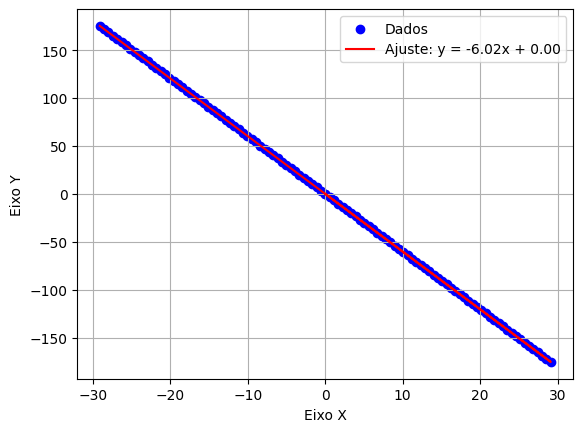

slope -6.02063625952829
dslope 0.00020598095189180483
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12123809523473, -28.56123809523706, -28.001238095239387, -27.441238095241715, -26.881238095244044, -26.321238095246372, -25.761238095234148, -25.201238095236477, -24.641238095238805, -24.081238095241133, -23.52123809524346, -22.96123809524579, -22.401238095233566, -21.841238095235894, -21.281238095238223, -20.72023809523671, -20.160238095239038, -19.600238095241366, -19.040238095243694, -18.480238095246023, -17.9202380952338, -17.360238095236127, -16.800238095238456, -16.240238095240784, -15.680238095243112, -15.12023809524544, -14.560238095233217, -14.000238095235545, -13.440238095237873, -12.880238095240202, -12.32023809524253, -11.760238095244858, -11.200238095232635, -10.640238095234963, -10.080238095237291, -9.52023809523962, -8.960238095241948, -8.400238095244276, -7.840238095246605, -7.280238095234381, -6.720238095236709, -6.160238095239038, -5.600238095241366, -5.040238095243694, -4.48

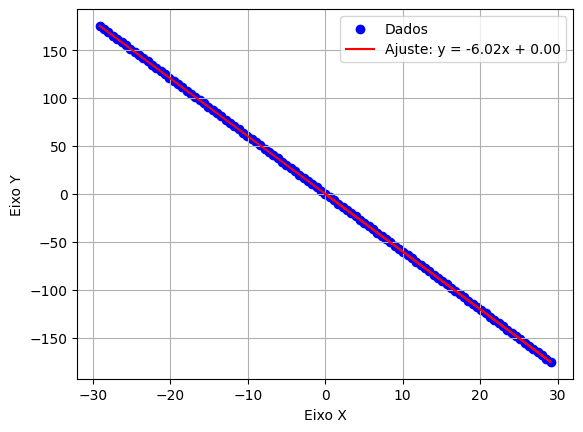

slope -6.020922880000177
dslope 0.0002376138006137779
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121371428584098, -28.561371428586426, -28.001371428574203, -27.44137142857653, -26.88137142857886, -26.321371428581188, -25.761371428583516, -25.201371428585844, -24.64037142858433, -24.08037142858666, -23.520371428574435, -22.960371428576764, -22.400371428579092, -21.84037142858142, -21.28037142858375, -20.720371428586077, -20.160371428573853, -19.60037142857618, -19.04037142857851, -18.48037142858084, -17.920371428583167, -17.360371428585495, -16.80037142857327, -16.2403714285756, -15.680371428577928, -15.120371428580256, -14.560371428582584, -14.000371428584913, -13.440371428587241, -12.880371428575017, -12.320371428577346, -11.760371428579674, -11.200371428582002, -10.64037142858433, -10.080371428586659, -9.520371428574435, -8.960371428576764, -8.400371428579092, -7.84037142858142, -7.280371428583749, -6.720371428586077, -6.160371428573853, -5.600371428576182, -5.04037142857851, -4.4803714

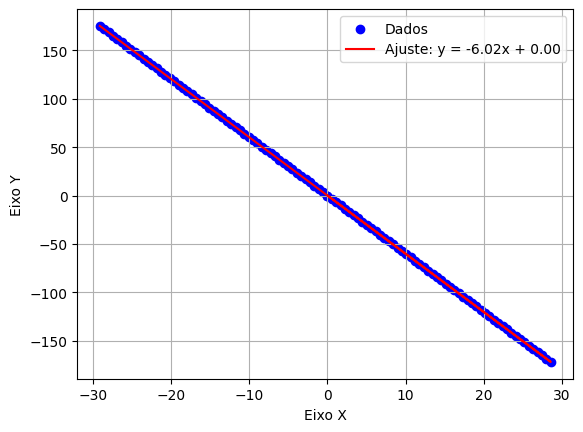

slope -6.0207961386334325
dslope 0.00022555988344403154
len(ttime) 105
l+l2 106
l2 2
ttime [-29.121552380966023, -28.56055238096451, -28.000552380966838, -27.440552380969166, -26.880552380971494, -26.320552380973822, -25.7605523809616, -25.200552380963927, -24.640552380966255, -24.080552380968584, -23.520552380970912, -22.96055238097324, -22.400552380961017, -21.840552380963345, -21.280552380965673, -20.720552380968, -20.16055238097033, -19.60055238097266, -19.040552380974987, -18.480552380962763, -17.92055238096509, -17.36055238096742, -16.800552380969748, -16.240552380972076, -15.680552380974405, -15.120552380962181, -14.56055238096451, -14.000552380966838, -13.440552380969166, -12.880552380971494, -12.320552380973822, -11.760552380961599, -11.200552380963927, -10.640552380966255, -10.080552380968584, -9.520552380970912, -8.96055238097324, -8.400552380961017, -7.840552380963345, -7.280552380965673, -6.720552380968002, -6.16055238097033, -5.600552380972658, -5.040552380974987, -4.4805

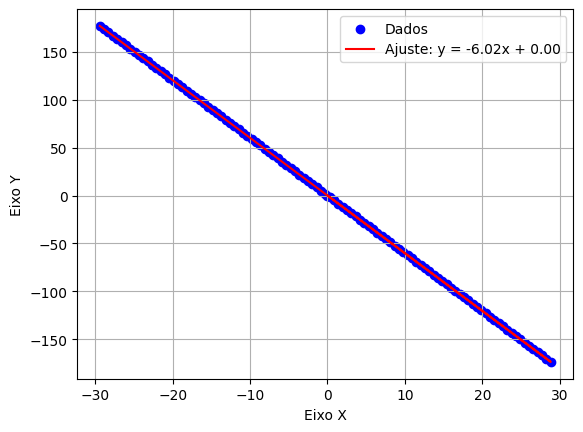

slope -6.020943807758397
dslope 0.0002451720052819336
len(ttime) 106
l+l2 107
l2 2
ttime [-29.40067924527102, -28.84067924527335, -28.280679245275678, -27.720679245263455, -27.160679245265783, -26.60067924526811, -26.04067924527044, -25.480679245272768, -24.920679245275096, -24.360679245277424, -23.8006792452652, -23.24067924526753, -22.680679245269857, -22.120679245272186, -21.560679245274514, -21.000679245276842, -20.44067924526462, -19.880679245266947, -19.320679245269275, -18.760679245271604, -18.200679245273932, -17.64067924527626, -17.080679245264037, -16.520679245266365, -15.960679245268693, -15.400679245271022, -14.84067924527335, -14.280679245275678, -13.720679245263455, -13.160679245265783, -12.600679245268111, -12.04067924527044, -11.480679245272768, -10.920679245275096, -10.360679245277424, -9.8006792452652, -9.240679245267529, -8.680679245269857, -8.120679245272186, -7.560679245274514, -7.000679245276842, -6.440679245264619, -5.880679245266947, -5.320679245269275, -4.76067

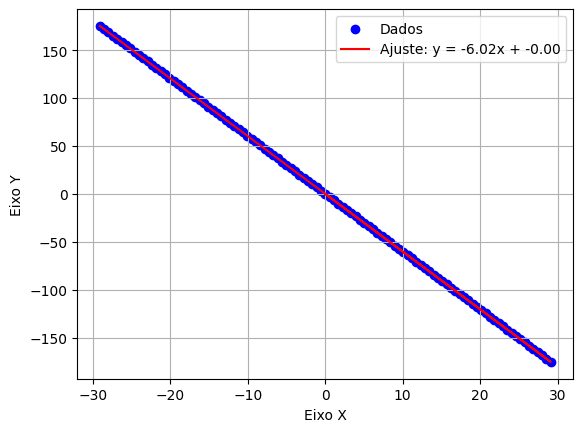

slope -6.020483160442335
dslope 0.0002129173001999295
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12080952381075, -28.560809523813077, -28.000809523815406, -27.440809523817734, -26.880809523820062, -26.32080952382239, -25.760809523810167, -25.200809523812495, -24.640809523814823, -24.080809523817152, -23.52080952381948, -22.96080952382181, -22.400809523809585, -21.840809523811913, -21.28080952381424, -20.72080952381657, -20.160809523818898, -19.600809523821226, -19.040809523823555, -18.48080952381133, -17.92080952381366, -17.360809523815988, -16.800809523818316, -16.240809523820644, -15.680809523822973, -15.120809523810749, -14.560809523813077, -14.000809523815406, -13.440809523817734, -12.880809523820062, -12.32080952382239, -11.760809523810167, -11.200809523812495, -10.640809523814823, -10.080809523817152, -9.52080952381948, -8.960809523821808, -8.399809523820295, -7.839809523822623, -7.2798095238104, -6.719809523812728, -6.159809523815056, -5.599809523817385, -5.039809523819713, -4.4798

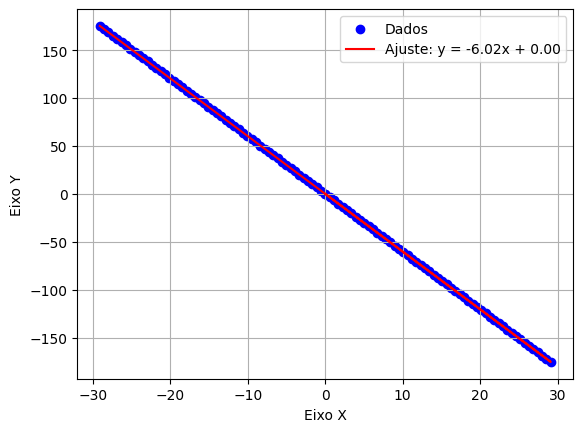

slope -6.0207628958952695
dslope 0.00020464624965410078
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120933333339053, -28.56093333334138, -28.000933333329158, -27.440933333331486, -26.880933333333815, -26.320933333336143, -25.76093333333847, -25.2009333333408, -24.640933333343128, -24.080933333330904, -23.520933333333232, -22.96093333333556, -22.40093333333789, -21.840933333340217, -21.280933333342546, -20.720933333330322, -20.16093333333265, -19.60093333333498, -19.040933333337307, -18.480933333339635, -17.920933333341964, -17.36093333332974, -16.80093333333207, -16.240933333334397, -15.680933333336725, -15.120933333339053, -14.560933333341382, -14.000933333329158, -13.440933333331486, -12.880933333333815, -12.320933333336143, -11.75993333333463, -11.199933333336958, -10.639933333339286, -10.079933333341614, -9.51993333332939, -8.959933333331719, -8.399933333334047, -7.839933333336376, -7.279933333338704, -6.719933333341032, -6.159933333328809, -5.599933333331137, -5.039933333333465, -4.47

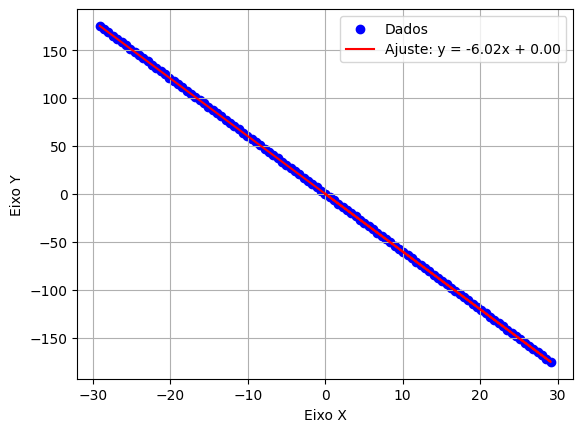

slope -6.01989436293904
dslope 0.00020200947711905508
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121066666659317, -28.561066666661645, -28.001066666663974, -27.441066666666302, -26.88106666666863, -26.321066666656407, -25.761066666658735, -25.201066666661063, -24.64106666666339, -24.08106666666572, -23.521066666668048, -22.961066666655825, -22.401066666658153, -21.84106666666048, -21.28106666666281, -20.721066666665138, -20.161066666667466, -19.601066666655242, -19.04106666665757, -18.4810666666599, -17.921066666662227, -17.361066666664556, -16.801066666666884, -16.241066666669212, -15.680066666667699, -15.120066666655475, -14.560066666657804, -14.000066666660132, -13.44006666666246, -12.880066666664788, -12.320066666667117, -11.760066666669445, -11.200066666657222, -10.64006666665955, -10.080066666661878, -9.520066666664206, -8.960066666666535, -8.400066666668863, -7.840066666656639, -7.280066666658968, -6.720066666661296, -6.160066666663624, -5.600066666665953, -5.040066666668281, -4.48

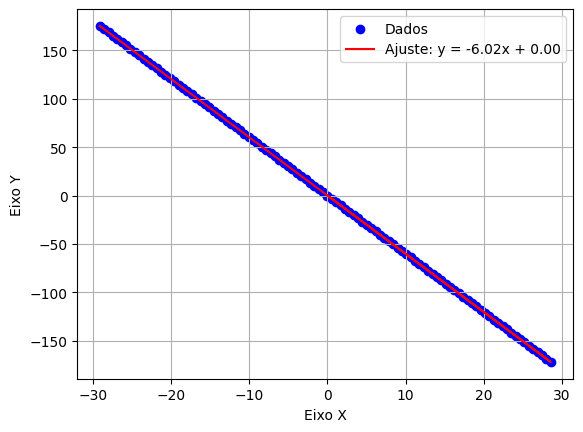

slope -6.020116821461519
dslope 0.00021468275688721187
len(ttime) 105
l+l2 106
l2 2
ttime [-29.121199999994133, -28.56119999998191, -28.001199999984237, -27.441199999986566, -26.881199999988894, -26.321199999991222, -25.76119999999355, -25.201199999981327, -24.641199999983655, -24.081199999985984, -23.521199999988312, -22.96119999999064, -22.40119999999297, -21.841199999995297, -21.281199999983073, -20.7211999999854, -20.16119999998773, -19.600199999986216, -19.040199999988545, -18.480199999990873, -17.9201999999932, -17.36019999999553, -16.800199999983306, -16.240199999985634, -15.680199999987963, -15.120199999990291, -14.56019999999262, -14.000199999994948, -13.440199999982724, -12.880199999985052, -12.32019999998738, -11.760199999989709, -11.200199999992037, -10.640199999994365, -10.080199999982142, -9.52019999998447, -8.960199999986799, -8.400199999989127, -7.840199999991455, -7.280199999993783, -6.72019999998156, -6.160199999983888, -5.600199999986216, -5.040199999988545, -4.48019

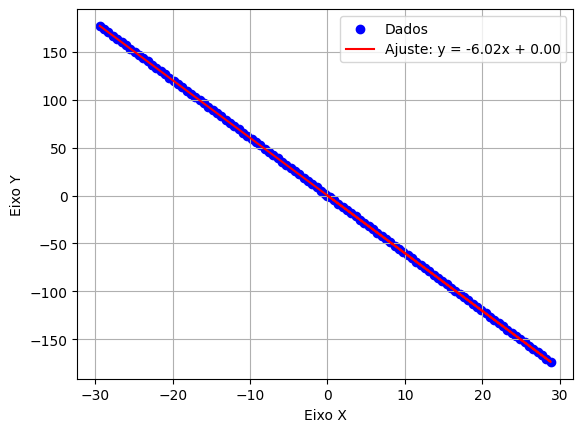

slope -6.019822556076556
dslope 0.0002477767994438547
len(ttime) 106
l+l2 107
l2 2
ttime [-29.40132075471047, -28.841320754712797, -28.281320754715125, -27.721320754717453, -27.16132075471978, -26.601320754707558, -26.041320754709886, -25.481320754712215, -24.921320754714543, -24.36132075471687, -23.8013207547192, -23.240320754717686, -22.680320754720015, -22.12032075470779, -21.56032075471012, -21.000320754712448, -20.440320754714776, -19.880320754717104, -19.320320754719432, -18.76032075470721, -18.200320754709537, -17.640320754711865, -17.080320754714194, -16.520320754716522, -15.96032075471885, -15.400320754706627, -14.840320754708955, -14.280320754711283, -13.720320754713612, -13.16032075471594, -12.600320754718268, -12.040320754706045, -11.480320754708373, -10.920320754710701, -10.36032075471303, -9.800320754715358, -9.240320754717686, -8.680320754720015, -8.120320754707791, -7.560320754710119, -7.0003207547124475, -6.440320754714776, -5.880320754717104, -5.320320754719432, -4.76

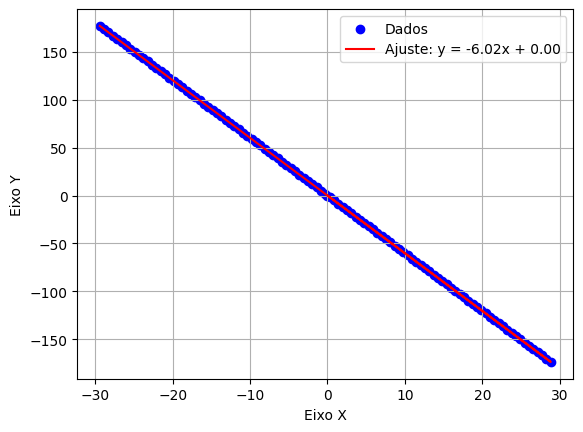

slope -6.020460170659359
dslope 0.00024337763931968028
len(ttime) 106
l+l2 107
l2 2
ttime [-29.40147169813281, -28.841471698120586, -28.281471698122914, -27.721471698125242, -27.16047169812373, -26.600471698126057, -26.040471698128385, -25.480471698130714, -24.920471698133042, -24.36047169812082, -23.800471698123147, -23.240471698125475, -22.680471698127803, -22.12047169813013, -21.56047169813246, -21.000471698120236, -20.440471698122565, -19.880471698124893, -19.32047169812722, -18.76047169812955, -18.200471698131878, -17.640471698119654, -17.080471698121983, -16.52047169812431, -15.96047169812664, -15.400471698128968, -14.840471698131296, -14.280471698133624, -13.7204716981214, -13.160471698123729, -12.600471698126057, -12.040471698128385, -11.480471698130714, -10.920471698133042, -10.360471698120818, -9.800471698123147, -9.240471698125475, -8.680471698127803, -8.120471698130132, -7.56047169813246, -7.000471698120236, -6.440471698122565, -5.880471698124893, -5.320471698127221, -4.760

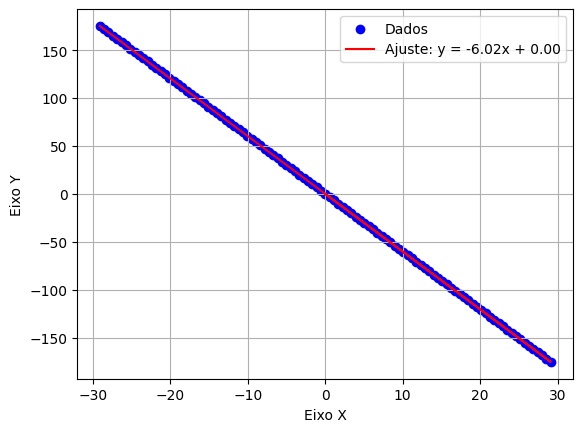

slope -6.020350114988452
dslope 0.00018076236960178725
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120628571428824, -28.560628571431153, -28.00062857143348, -27.44062857143581, -26.880628571438137, -26.320628571425914, -25.760628571428242, -25.20062857143057, -24.6406285714329, -24.080628571435227, -23.520628571437555, -22.96062857142533, -22.40062857142766, -21.84062857142999, -21.280628571432317, -20.720628571434645, -20.160628571436973, -19.6006285714393, -19.040628571427078, -18.480628571429406, -17.920628571431735, -17.360628571434063, -16.80062857143639, -16.24062857143872, -15.680628571426496, -15.120628571428824, -14.560628571431153, -14.00062857143348, -13.44062857143581, -12.880628571438137, -12.320628571425914, -11.760628571428242, -11.20062857143057, -10.640628571432899, -10.080628571435227, -9.520628571437555, -8.960628571425332, -8.40062857142766, -7.840628571429988, -7.280628571432317, -6.720628571434645, -6.160628571436973, -5.600628571439302, -5.040628571427078, -4.4806285

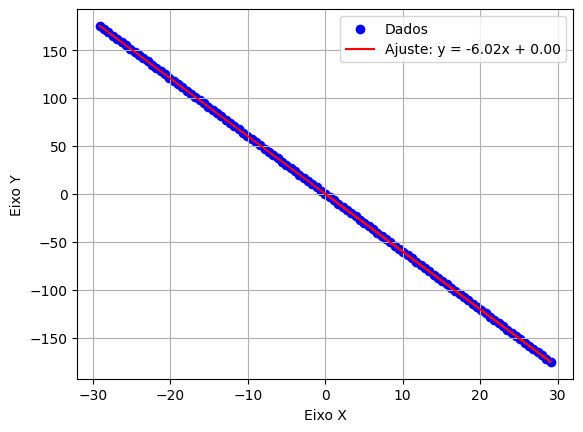

slope -6.020491803286465
dslope 0.00021528821777475215
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12076190476364, -28.560761904765968, -28.000761904753745, -27.440761904756073, -26.8807619047584, -26.32076190476073, -25.760761904763058, -25.200761904765386, -24.640761904753163, -24.08076190475549, -23.52076190475782, -22.960761904760147, -22.400761904762476, -21.840761904764804, -21.28076190475258, -20.72076190475491, -20.160761904757237, -19.600761904759565, -19.040761904761894, -18.480761904764222, -17.920761904752, -17.360761904754327, -16.800761904756655, -16.240761904758983, -15.680761904761312, -15.12076190476364, -14.560761904765968, -14.000761904753745, -13.440761904756073, -12.880761904758401, -12.32076190476073, -11.760761904763058, -11.200761904765386, -10.640761904753163, -10.08076190475549, -9.52076190475782, -8.960761904760147, -8.400761904762476, -7.840761904764804, -7.2807619047525804, -6.719761904765619, -6.159761904753395, -5.599761904755724, -5.039761904758052, -4.47976

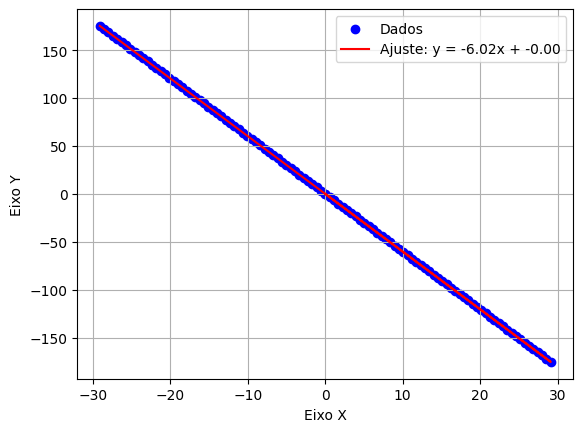

slope -6.021118181382896
dslope 0.00020732618739026663
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120895238083904, -28.560895238086232, -28.00089523808856, -27.44089523809089, -26.880895238078665, -26.320895238080993, -25.76089523808332, -25.20089523808565, -24.640895238087978, -24.080895238090307, -23.520895238078083, -22.96089523808041, -22.40089523808274, -21.840895238085068, -21.280895238087396, -20.720895238089724, -20.160895238092053, -19.60089523807983, -19.040895238082157, -18.480895238084486, -17.920895238086814, -17.360895238089142, -16.80089523809147, -16.240895238079247, -15.680895238081575, -15.120895238083904, -14.560895238086232, -14.00089523808856, -13.440895238090889, -12.880895238078665, -12.320895238080993, -11.760895238083322, -11.20089523808565, -10.639895238084137, -10.079895238086465, -9.519895238088793, -8.959895238091121, -8.399895238078898, -7.839895238081226, -7.279895238083554, -6.719895238085883, -6.159895238088211, -5.599895238090539, -5.039895238078316, -4.4

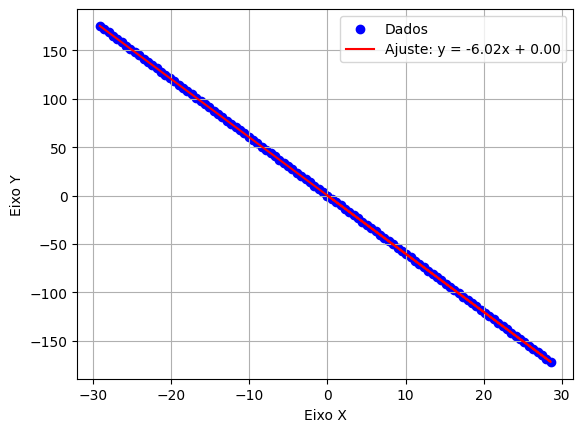

slope -6.020626261466337
dslope 0.00022208671737982677
len(ttime) 105
l+l2 106
l2 2
ttime [-29.12102857141872, -28.561028571421048, -28.001028571423376, -27.441028571425704, -26.881028571428033, -26.32102857143036, -25.76102857143269, -25.201028571420466, -24.641028571422794, -24.081028571425122, -23.52102857142745, -22.96102857142978, -22.401028571432107, -21.841028571419884, -21.281028571422212, -20.72102857142454, -20.16102857142687, -19.601028571429197, -19.041028571431525, -18.4810285714193, -17.92102857142163, -17.361028571423958, -16.801028571426286, -16.241028571428615, -15.681028571430943, -15.12102857141872, -14.560028571431758, -14.000028571419534, -13.440028571421863, -12.88002857142419, -12.32002857142652, -11.760028571428847, -11.200028571431176, -10.640028571418952, -10.08002857142128, -9.520028571423609, -8.960028571425937, -8.400028571428265, -7.840028571430594, -7.280028571432922, -6.720028571420698, -6.160028571423027, -5.600028571425355, -5.040028571427683, -4.48002

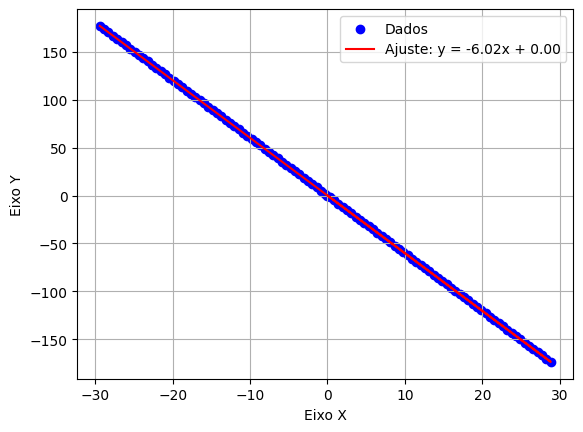

slope -6.020688823939774
dslope 0.00023958222117236304
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401150943391258, -28.841150943393586, -28.281150943395915, -27.721150943398243, -27.16115094338602, -26.601150943388348, -26.041150943390676, -25.481150943393004, -24.921150943395332, -24.36115094339766, -23.801150943385437, -23.241150943387765, -22.681150943390094, -22.121150943392422, -21.56115094339475, -21.00115094339708, -20.441150943384855, -19.881150943387183, -19.32115094338951, -18.76115094339184, -18.200150943390327, -17.640150943392655, -17.080150943394983, -16.52015094339731, -15.960150943385088, -15.400150943387416, -14.840150943389744, -14.280150943392073, -13.720150943394401, -13.16015094339673, -12.600150943399058, -12.040150943386834, -11.480150943389162, -10.92015094339149, -10.360150943393819, -9.800150943396147, -9.240150943398476, -8.680150943386252, -8.12015094338858, -7.560150943390909, -7.000150943393237, -6.440150943395565, -5.880150943397894, -5.32015094338567, -4.76

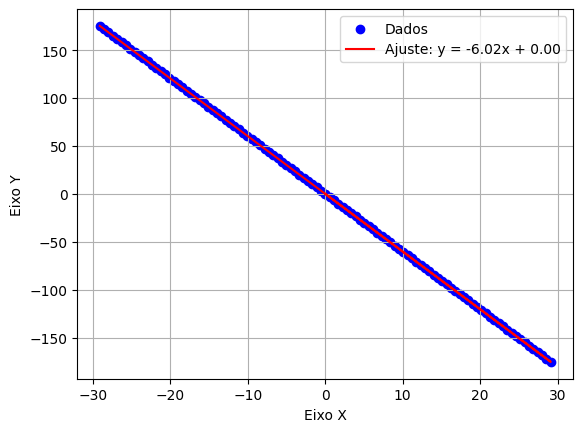

slope -6.020698822692017
dslope 0.0002159251774248375
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121276190475328, -28.561276190477656, -28.001276190479985, -27.441276190482313, -26.88127619048464, -26.32127619048697, -25.761276190474746, -25.201276190477074, -24.641276190479402, -24.08127619048173, -23.52127619048406, -22.961276190486387, -22.401276190488716, -21.840276190487202, -21.28027619047498, -20.720276190477307, -20.160276190479635, -19.600276190481964, -19.040276190484292, -18.48027619048662, -17.92027619048895, -17.360276190476725, -16.800276190479053, -16.24027619048138, -15.68027619048371, -15.120276190486038, -14.560276190488366, -14.000276190476143, -13.440276190478471, -12.8802761904808, -12.320276190483128, -11.760276190485456, -11.200276190487784, -10.64027619047556, -10.080276190477889, -9.520276190480217, -8.960276190482546, -8.400276190484874, -7.840276190487202, -7.280276190474979, -6.720276190477307, -6.160276190479635, -5.600276190481964, -5.040276190484292, -4.4802

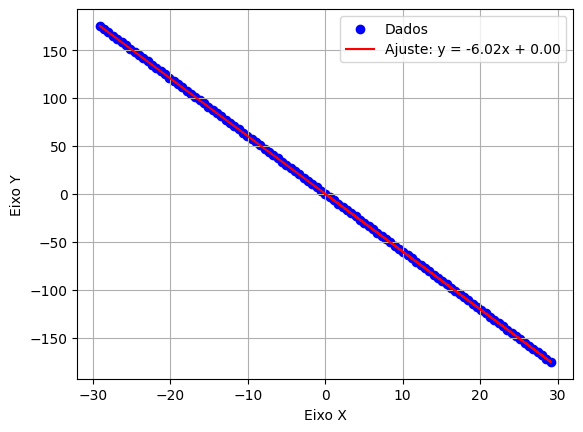

slope -6.020667840135267
dslope 0.0002052550929995999
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121409523810144, -28.561409523812472, -28.0014095238148, -27.441409523802577, -26.881409523804905, -26.321409523807233, -25.76040952380572, -25.200409523808048, -24.640409523810376, -24.080409523812705, -23.520409523815033, -22.96040952380281, -22.400409523805138, -21.840409523807466, -21.280409523809794, -20.720409523812123, -20.16040952381445, -19.600409523802227, -19.040409523804556, -18.480409523806884, -17.920409523809212, -17.36040952381154, -16.80040952381387, -16.240409523801645, -15.680409523803974, -15.120409523806302, -14.56040952380863, -14.000409523810958, -13.440409523813287, -12.880409523801063, -12.320409523803391, -11.76040952380572, -11.200409523808048, -10.640409523810376, -10.080409523812705, -9.520409523815033, -8.96040952380281, -8.400409523805138, -7.840409523807466, -7.280409523809794, -6.720409523812123, -6.160409523814451, -5.600409523802227, -5.040409523804556, -4.48

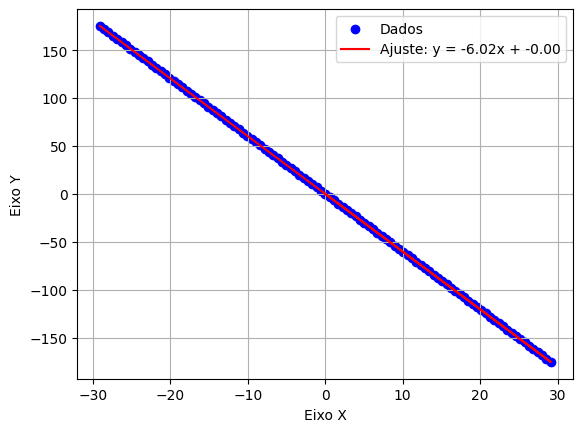

slope -6.020262959855124
dslope 0.00019254884899435525
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12059047620278, -28.560590476190555, -28.000590476192883, -27.44059047619521, -26.88059047619754, -26.320590476199868, -25.760590476202196, -25.200590476189973, -24.6405904761923, -24.08059047619463, -23.520590476196958, -22.960590476199286, -22.400590476201614, -21.84059047618939, -21.28059047619172, -20.720590476194047, -20.160590476196376, -19.600590476198704, -19.040590476201032, -18.48059047618881, -17.920590476191137, -17.360590476193465, -16.800590476195794, -16.240590476198122, -15.68059047620045, -15.120590476202779, -14.560590476190555, -14.000590476192883, -13.440590476195212, -12.88059047619754, -12.320590476199868, -11.760590476202196, -11.200590476189973, -10.640590476192301, -10.08059047619463, -9.520590476196958, -8.960590476199286, -8.400590476201614, -7.840590476189391, -7.280590476191719, -6.720590476194047, -6.160590476196376, -5.600590476198704, -5.040590476201032, -4.480

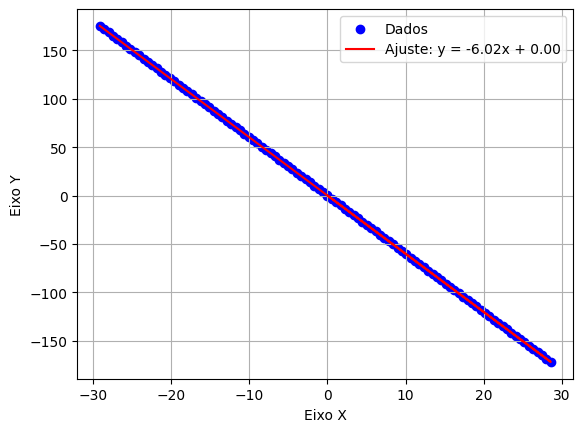

slope -6.020734379056422
dslope 0.00018156866695154673
len(ttime) 105
l+l2 106
l2 2
ttime [-29.120733333329554, -28.560733333331882, -28.00073333333421, -27.440733333321987, -26.880733333324315, -26.320733333326643, -25.76073333332897, -25.2007333333313, -24.64073333333363, -24.080733333335957, -23.520733333323733, -22.96073333332606, -22.40073333332839, -21.840733333330718, -21.280733333333046, -20.720733333335374, -20.16073333332315, -19.60073333332548, -19.040733333327807, -18.480733333330136, -17.920733333332464, -17.360733333334792, -16.80073333332257, -16.240733333324897, -15.680733333327225, -15.120733333329554, -14.560733333331882, -14.00073333333421, -13.440733333321987, -12.880733333324315, -12.320733333326643, -11.760733333328972, -11.2007333333313, -10.640733333333628, -10.080733333335957, -9.520733333323733, -8.960733333326061, -8.40073333332839, -7.840733333330718, -7.280733333333046, -6.7207333333353745, -6.159733333333861, -5.5997333333216375, -5.039733333323966, -4.479

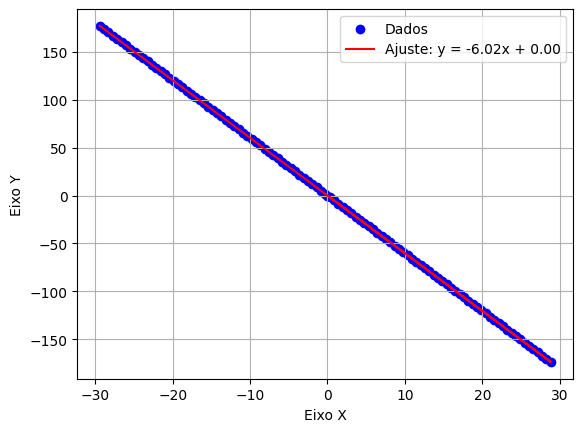

slope -6.020523369580111
dslope 0.00023812006276869332
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400849056604784, -28.84084905659256, -28.28084905659489, -27.720849056597217, -27.160849056599545, -26.600849056601874, -26.040849056604202, -25.48084905659198, -24.920849056594307, -24.360849056596635, -23.800849056598963, -23.24084905660129, -22.68084905660362, -22.120849056591396, -21.560849056593725, -21.000849056596053, -20.44084905659838, -19.88084905660071, -19.320849056603038, -18.760849056590814, -18.200849056593142, -17.64084905659547, -17.0808490565978, -16.520849056600127, -15.960849056602456, -15.400849056604784, -14.84084905659256, -14.280849056594889, -13.720849056597217, -13.160849056599545, -12.600849056601874, -12.040849056604202, -11.480849056591978, -10.920849056594307, -10.360849056596635, -9.800849056598963, -9.23984905659745, -8.679849056599778, -8.119849056602106, -7.559849056604435, -6.999849056592211, -6.439849056594539, -5.879849056596868, -5.319849056599196, -4.759

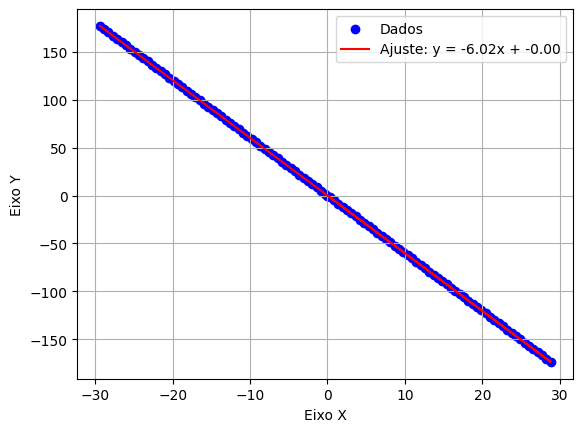

slope -6.021344075120315
dslope 0.0002037944224513988
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400981132072047, -28.840981132074376, -28.280981132076704, -27.72098113206448, -27.16098113206681, -26.600981132069137, -26.040981132071465, -25.480981132073794, -24.920981132076122, -24.3609811320639, -23.800981132066227, -23.240981132068555, -22.680981132070883, -22.12098113207321, -21.56098113207554, -21.000981132077868, -20.440981132065644, -19.880981132067973, -19.3209811320703, -18.76098113207263, -18.200981132074958, -17.640981132077286, -17.080981132065062, -16.52098113206739, -15.960981132069719, -15.400981132072047, -14.840981132074376, -14.280981132076704, -13.72098113206448, -13.159981132077519, -12.599981132065295, -12.039981132067624, -11.479981132069952, -10.91998113207228, -10.359981132074608, -9.799981132076937, -9.239981132064713, -8.679981132067041, -8.11998113206937, -7.559981132071698, -6.999981132074026, -6.439981132076355, -5.879981132064131, -5.319981132066459, -4.75998

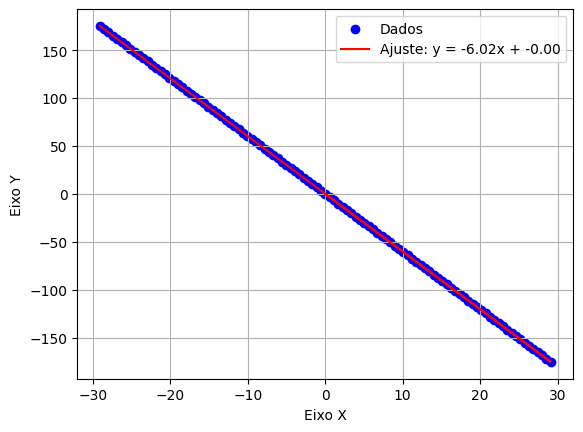

slope -6.020561053147791
dslope 0.00020886141490453712
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121104761899915, -28.561104761902243, -28.00110476190457, -27.4411047619069, -26.881104761909228, -26.321104761911556, -25.761104761899333, -25.20110476190166, -24.64110476190399, -24.081104761906317, -23.521104761908646, -22.961104761910974, -22.40110476189875, -21.84110476190108, -21.281104761903407, -20.721104761905735, -20.161104761908064, -19.601104761910392, -19.04110476189817, -18.481104761900497, -17.921104761902825, -17.361104761905153, -16.80010476190364, -16.240104761905968, -15.680104761908296, -15.120104761910625, -14.560104761898401, -14.00010476190073, -13.440104761903058, -12.880104761905386, -12.320104761907714, -11.760104761910043, -11.20010476189782, -10.640104761900147, -10.080104761902476, -9.520104761904804, -8.960104761907132, -8.40010476190946, -7.840104761911789, -7.280104761899565, -6.720104761901894, -6.160104761904222, -5.60010476190655, -5.040104761908879, -4.4801

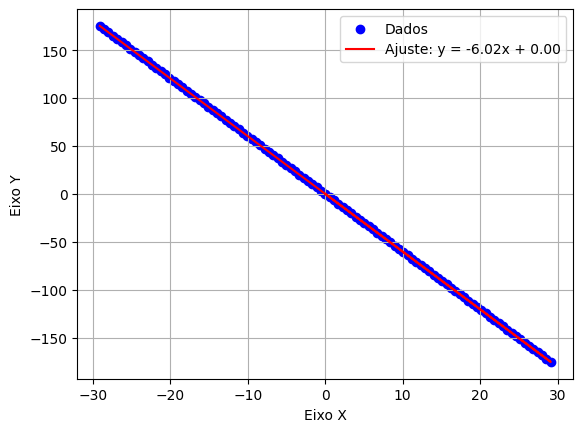

slope -6.02074560363812
dslope 0.00018659934188886243
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121238095249282, -28.56123809525161, -28.001238095239387, -27.441238095241715, -26.881238095244044, -26.321238095246372, -25.7612380952487, -25.20123809525103, -24.641238095238805, -24.081238095241133, -23.52123809524346, -22.96123809524579, -22.401238095248118, -21.841238095250446, -21.281238095238223, -20.72023809525126, -20.160238095239038, -19.600238095241366, -19.040238095243694, -18.480238095246023, -17.92023809524835, -17.36023809525068, -16.800238095238456, -16.240238095240784, -15.680238095243112, -15.12023809524544, -14.560238095247769, -14.000238095250097, -13.440238095252425, -12.880238095240202, -12.32023809524253, -11.760238095244858, -11.200238095247187, -10.640238095249515, -10.080238095251843, -9.52023809523962, -8.960238095241948, -8.400238095244276, -7.840238095246605, -7.280238095248933, -6.720238095251261, -6.160238095239038, -5.600238095241366, -5.040238095243694, -4.4802

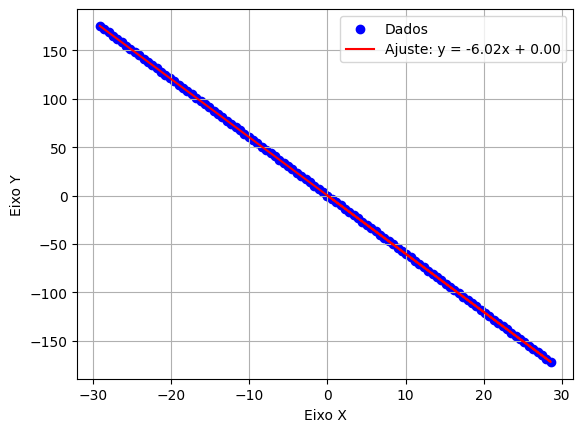

slope -6.020809578859529
dslope 0.00021400623749953445
len(ttime) 105
l+l2 106
l2 2
ttime [-29.121371428554994, -28.561371428557322, -28.00137142855965, -27.44137142856198, -26.881371428564307, -26.321371428552084, -25.761371428554412, -25.20137142855674, -24.640371428555227, -24.080371428557555, -23.520371428559883, -22.960371428562212, -22.400371428549988, -21.840371428552317, -21.280371428554645, -20.720371428556973, -20.1603714285593, -19.60037142856163, -19.040371428563958, -18.480371428551734, -17.920371428554063, -17.36037142855639, -16.80037142855872, -16.240371428561048, -15.680371428563376, -15.120371428551152, -14.56037142855348, -14.000371428555809, -13.440371428558137, -12.880371428560466, -12.320371428562794, -11.76037142855057, -11.200371428552899, -10.640371428555227, -10.080371428557555, -9.520371428559883, -8.960371428562212, -8.400371428549988, -7.8403714285523165, -7.280371428554645, -6.720371428556973, -6.160371428559301, -5.60037142856163, -5.040371428563958, -4.4

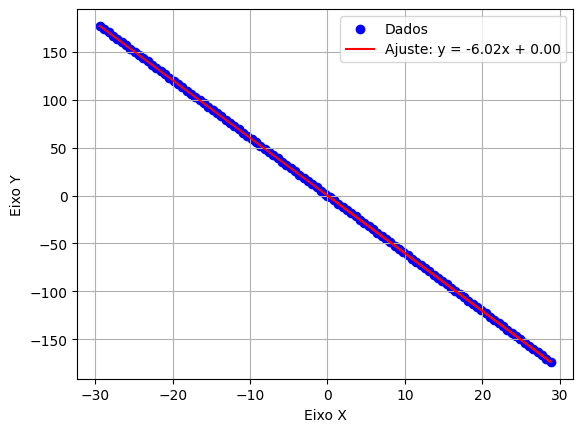

slope -6.019855184063155
dslope 0.00024084866687858073
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401528301881626, -28.841528301883955, -28.28052830188244, -27.720528301870218, -27.160528301872546, -26.600528301874874, -26.040528301877202, -25.48052830187953, -24.92052830188186, -24.360528301884187, -23.800528301871964, -23.240528301874292, -22.68052830187662, -22.12052830187895, -21.560528301881277, -21.000528301883605, -20.44052830187138, -19.88052830187371, -19.32052830187604, -18.760528301878367, -18.200528301880695, -17.640528301883023, -17.0805283018708, -16.520528301873128, -15.960528301875456, -15.400528301877785, -14.840528301880113, -14.280528301882441, -13.720528301870218, -13.160528301872546, -12.600528301874874, -12.040528301877202, -11.48052830187953, -10.920528301881859, -10.360528301884187, -9.800528301871964, -9.240528301874292, -8.68052830187662, -8.120528301878949, -7.560528301881277, -7.000528301883605, -6.440528301871382, -5.88052830187371, -5.320528301876038, -4.7605

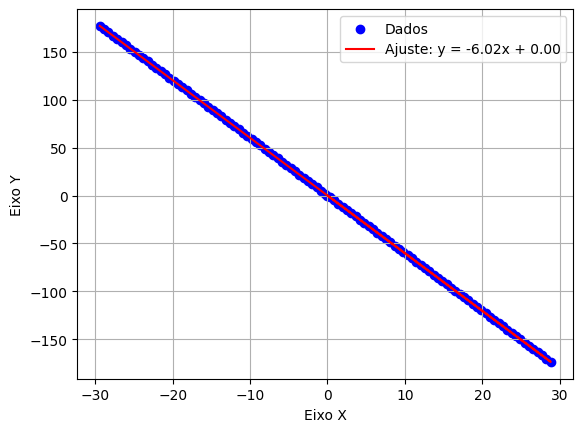

slope -6.020040378645133
dslope 0.0002305100252402102
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400679245285573, -28.8406792452879, -28.28067924529023, -27.72067924529256, -27.160679245294887, -26.600679245297215, -26.04067924528499, -25.48067924528732, -24.920679245289648, -24.360679245291976, -23.800679245294305, -23.240679245296633, -22.68067924528441, -22.120679245286738, -21.560679245289066, -21.000679245291394, -20.440679245293722, -19.88067924529605, -19.32067924529838, -18.760679245286155, -18.200679245288484, -17.640679245290812, -17.08067924529314, -16.52067924529547, -15.960679245297797, -15.400679245285573, -14.840679245287902, -14.28067924529023, -13.720679245292558, -13.160679245294887, -12.600679245297215, -12.040679245284991, -11.48067924528732, -10.920679245289648, -10.360679245291976, -9.800679245294305, -9.240679245296633, -8.68067924528441, -8.120679245286738, -7.560679245289066, -7.000679245291394, -6.4406792452937225, -5.880679245296051, -5.320679245298379, -4.76067

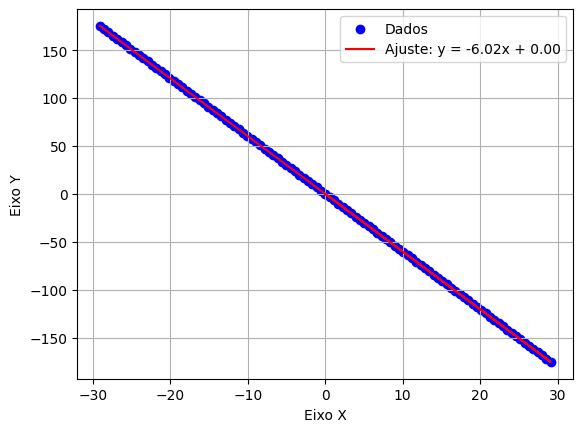

slope -6.020875184735272
dslope 0.00022757942163588606
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120800000004238, -28.560800000006566, -28.000799999994342, -27.44079999999667, -26.880799999999, -26.320800000001327, -25.760800000003655, -25.200800000005984, -24.640800000008312, -24.08079999999609, -23.520799999998417, -22.960800000000745, -22.400800000003073, -21.8408000000054, -21.28080000000773, -20.720799999995506, -20.160799999997835, -19.600800000000163, -19.04080000000249, -18.48080000000482, -17.920800000007148, -17.360799999994924, -16.800799999997253, -16.24079999999958, -15.68080000000191, -15.120800000004238, -14.560800000006566, -14.000799999994342, -13.44079999999667, -12.880799999998999, -12.320800000001327, -11.760800000003655, -11.200800000005984, -10.640800000008312, -10.080799999996088, -9.520799999998417, -8.960800000000745, -8.400800000003073, -7.83980000000156, -7.279800000003888, -6.719800000006217, -6.159799999993993, -5.599799999996321, -5.03979999999865, -4.479800

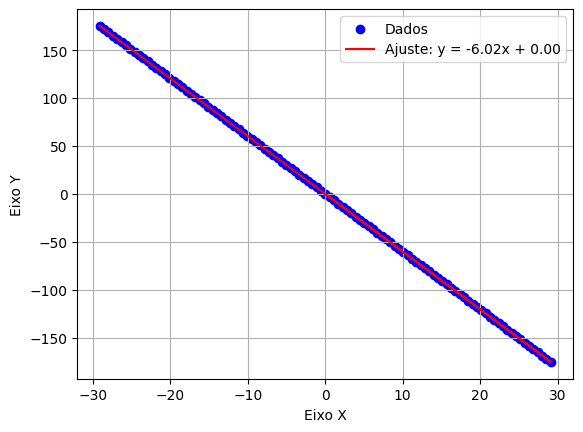

slope -6.021362476373551
dslope 0.0001995362735566232
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120942857145565, -28.560942857147893, -28.00094285715022, -27.44094285715255, -26.880942857154878, -26.320942857142654, -25.760942857144983, -25.20094285714731, -24.64094285714964, -24.080942857151967, -23.520942857154296, -22.960942857142072, -22.4009428571444, -21.84094285714673, -21.280942857149057, -20.720942857151385, -20.160942857153714, -19.60094285714149, -19.04094285714382, -18.480942857146147, -17.920942857148475, -17.360942857150803, -16.80094285715313, -16.24094285715546, -15.680942857143236, -15.120942857145565, -14.560942857147893, -14.000942857150221, -13.44094285715255, -12.880942857154878, -12.319942857153364, -11.759942857155693, -11.19994285714347, -10.639942857145797, -10.079942857148126, -9.519942857150454, -8.959942857152782, -8.39994285715511, -7.839942857142887, -7.279942857145215, -6.719942857147544, -6.159942857149872, -5.5999428571522, -5.039942857154529, -4.47994285

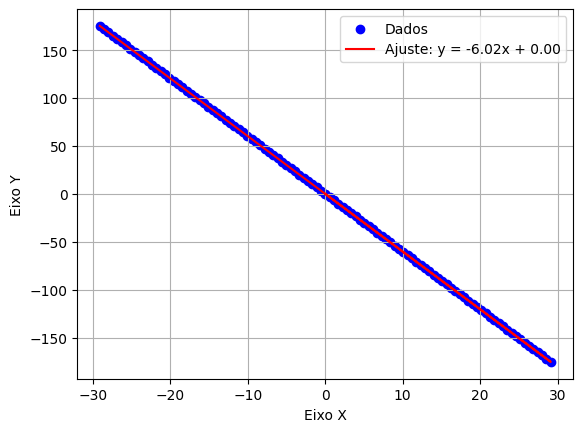

slope -6.021077411480141
dslope 0.00022246455654873395
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12106666667387, -28.561066666661645, -28.001066666663974, -27.441066666666302, -26.88106666666863, -26.32106666667096, -25.761066666673287, -25.201066666661063, -24.64106666666339, -24.08106666666572, -23.521066666668048, -22.961066666670376, -22.401066666672705, -21.841066666675033, -21.28106666666281, -20.721066666665138, -20.161066666667466, -19.601066666669794, -19.041066666672123, -18.48106666667445, -17.921066666662227, -17.361066666664556, -16.801066666666884, -16.241066666669212, -15.680066666667699, -15.120066666670027, -14.560066666672355, -14.000066666674684, -13.44006666666246, -12.880066666664788, -12.320066666667117, -11.760066666669445, -11.200066666671773, -10.640066666674102, -10.080066666661878, -9.520066666664206, -8.960066666666535, -8.400066666668863, -7.840066666671191, -7.28006666667352, -6.720066666661296, -6.160066666663624, -5.600066666665953, -5.040066666668281, -4.

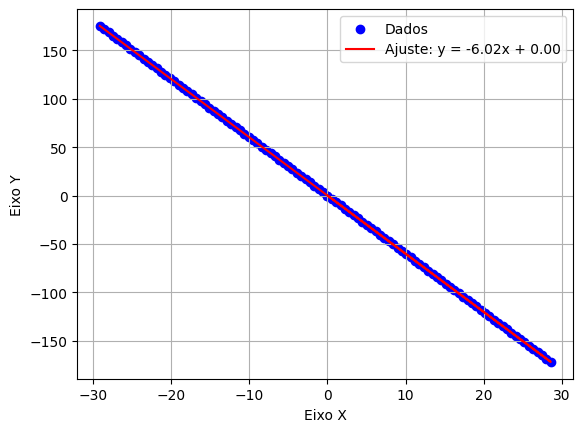

slope -6.020694387219058
dslope 0.0002033355874292739
len(ttime) 105
l+l2 106
l2 2
ttime [-29.121200000008685, -28.561200000011013, -28.00120000001334, -27.44120000001567, -26.881200000003446, -26.321200000005774, -25.761200000008103, -25.20120000001043, -24.64120000001276, -24.081200000015087, -23.521200000002864, -22.961200000005192, -22.40120000000752, -21.84120000000985, -21.281200000012177, -20.721200000014505, -20.16120000000228, -19.60020000001532, -19.040200000003097, -18.480200000005425, -17.920200000007753, -17.36020000001008, -16.80020000001241, -16.240200000014738, -15.680200000002515, -15.120200000004843, -14.560200000007171, -14.0002000000095, -13.440200000011828, -12.880200000014156, -12.320200000001932, -11.76020000000426, -11.200200000006589, -10.640200000008917, -10.080200000011246, -9.520200000013574, -8.960200000015902, -8.400200000003679, -7.840200000006007, -7.280200000008335, -6.720200000010664, -6.160200000012992, -5.60020000001532, -5.040200000003097, -4.480200

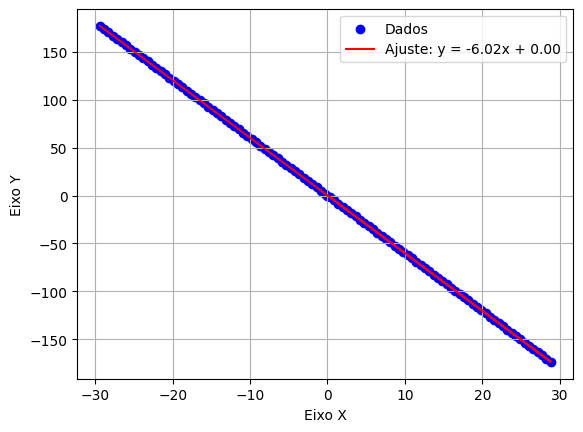

slope -6.020427409383177
dslope 0.00026446280124518406
len(ttime) 106
l+l2 107
l2 2
ttime [-29.40132075471047, -28.841320754698245, -28.281320754700573, -27.7213207547029, -27.16132075470523, -26.601320754707558, -26.041320754709886, -25.481320754697663, -24.92132075469999, -24.36132075470232, -23.801320754704648, -23.240320754703134, -22.680320754705463, -22.12032075470779, -21.56032075471012, -21.000320754697896, -20.440320754700224, -19.880320754702552, -19.32032075470488, -18.76032075470721, -18.200320754709537, -17.640320754697314, -17.080320754699642, -16.52032075470197, -15.960320754704298, -15.400320754706627, -14.840320754708955, -14.280320754711283, -13.72032075469906, -13.160320754701388, -12.600320754703716, -12.040320754706045, -11.480320754708373, -10.920320754710701, -10.360320754698478, -9.800320754700806, -9.240320754703134, -8.680320754705463, -8.120320754707791, -7.560320754710119, -7.000320754697896, -6.440320754700224, -5.880320754702552, -5.3203207547048805, -4.76

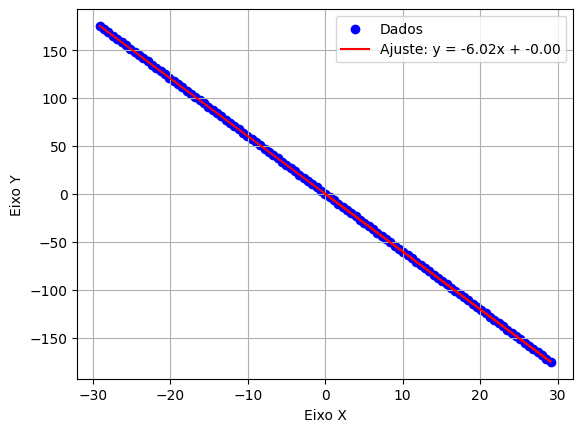

slope -6.020594330892513
dslope 0.00023972080364407353
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121457142871805, -28.561457142874133, -28.00145714287646, -27.44145714287879, -26.880457142877276, -26.320457142865052, -25.76045714286738, -25.20045714286971, -24.640457142872037, -24.080457142874366, -23.520457142876694, -22.96045714286447, -22.4004571428668, -21.840457142869127, -21.280457142871455, -20.720457142873784, -20.160457142876112, -19.60045714287844, -19.040457142866217, -18.480457142868545, -17.920457142870873, -17.3604571428732, -16.80045714287553, -16.240457142877858, -15.680457142865635, -15.120457142867963, -14.560457142870291, -14.00045714287262, -13.440457142874948, -12.880457142877276, -12.320457142865052, -11.76045714286738, -11.200457142869709, -10.640457142872037, -10.080457142874366, -9.520457142876694, -8.96045714286447, -8.400457142866799, -7.840457142869127, -7.280457142871455, -6.720457142873784, -6.160457142876112, -5.60045714287844, -5.040457142866217, -4.480457

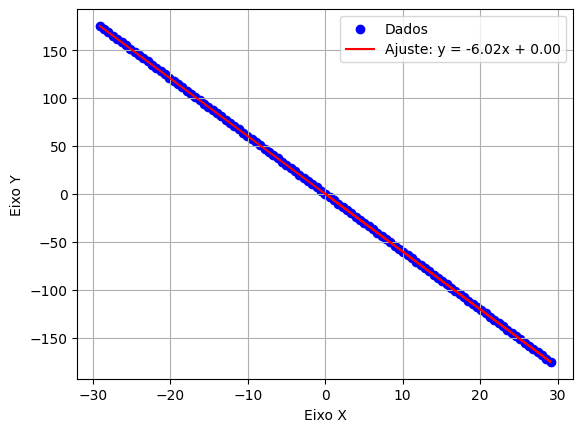

slope -6.020657869870816
dslope 0.00021187121555155962
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120628571443376, -28.560628571445704, -28.00062857143348, -27.44062857143581, -26.880628571438137, -26.320628571440466, -25.760628571442794, -25.200628571445122, -24.6406285714329, -24.080628571435227, -23.520628571437555, -22.960628571439884, -22.400628571442212, -21.84062857144454, -21.280628571432317, -20.720628571434645, -20.160628571436973, -19.6006285714393, -19.04062857144163, -18.480628571443958, -17.920628571431735, -17.360628571434063, -16.80062857143639, -16.24062857143872, -15.680628571441048, -15.120628571443376, -14.560628571445704, -14.00062857143348, -13.44062857143581, -12.880628571438137, -12.320628571440466, -11.760628571442794, -11.200628571445122, -10.640628571432899, -10.080628571435227, -9.520628571437555, -8.960628571439884, -8.400628571442212, -7.84062857144454, -7.280628571432317, -6.720628571434645, -6.160628571436973, -5.600628571439302, -5.04062857144163, -4.48062

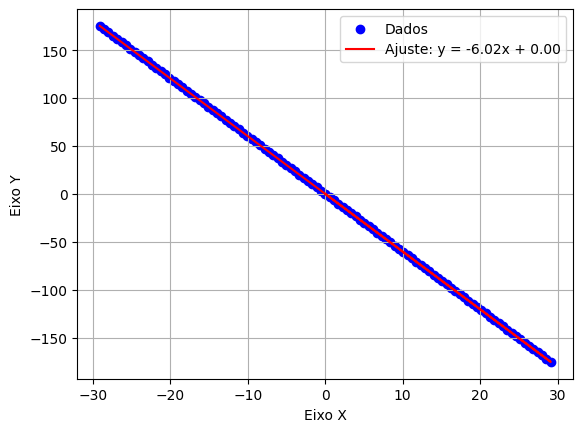

slope -6.020971242102926
dslope 0.00023736932063744864
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12076190476364, -28.560761904765968, -28.000761904768297, -27.440761904770625, -26.8807619047584, -26.32076190476073, -25.760761904763058, -25.200761904765386, -24.640761904767714, -24.080761904770043, -23.52076190475782, -22.960761904760147, -22.400761904762476, -21.840761904764804, -21.280761904767132, -20.72076190476946, -20.16076190477179, -19.600761904759565, -19.040761904761894, -18.480761904764222, -17.92076190476655, -17.36076190476888, -16.800761904771207, -16.240761904758983, -15.680761904761312, -15.12076190476364, -14.560761904765968, -14.000761904768297, -13.440761904770625, -12.880761904758401, -12.32076190476073, -11.760761904763058, -11.200761904765386, -10.640761904767714, -10.080761904770043, -9.52076190475782, -8.960761904760147, -8.400761904762476, -7.840761904764804, -7.280761904767132, -6.719761904765619, -6.159761904767947, -5.599761904770276, -5.039761904758052, -4.479

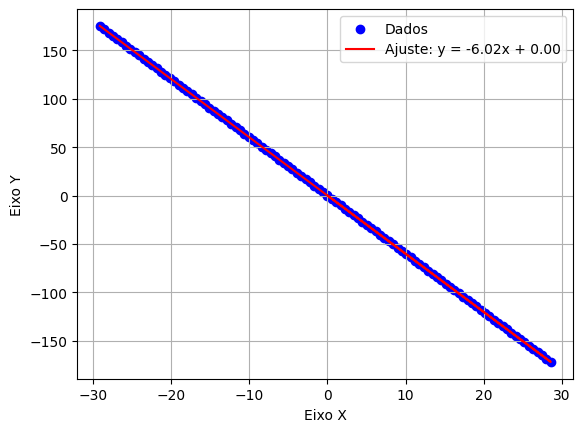

slope -6.020837209438833
dslope 0.00021485655629247053
len(ttime) 105
l+l2 106
l2 2
ttime [-29.120895238083904, -28.560895238086232, -28.00089523808856, -27.44089523809089, -26.880895238093217, -26.320895238095545, -25.760895238097874, -25.20089523808565, -24.640895238087978, -24.080895238090307, -23.520895238092635, -22.960895238094963, -22.40089523809729, -21.840895238085068, -21.280895238087396, -20.720895238089724, -20.160895238092053, -19.60089523809438, -19.04089523809671, -18.480895238084486, -17.920895238086814, -17.360895238089142, -16.80089523809147, -16.2408952380938, -15.680895238096127, -15.120895238083904, -14.560895238086232, -14.00089523808856, -13.440895238090889, -12.880895238093217, -12.320895238095545, -11.760895238097874, -11.20089523808565, -10.639895238084137, -10.079895238086465, -9.519895238088793, -8.959895238091121, -8.39989523809345, -7.839895238095778, -7.279895238098106, -6.719895238085883, -6.159895238088211, -5.599895238090539, -5.039895238092868, -4.479

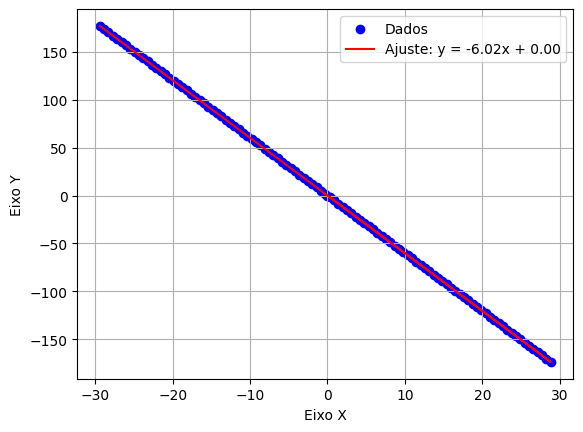

slope -6.020606109671311
dslope 0.0002362849311544839
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401018867909443, -28.84101886791177, -28.2810188679141, -27.721018867916428, -27.161018867904204, -26.601018867906532, -26.04101886790886, -25.48101886791119, -24.921018867913517, -24.361018867915845, -23.801018867903622, -23.24101886790595, -22.68101886790828, -22.121018867910607, -21.561018867912935, -21.001018867915263, -20.44101886790304, -19.881018867905368, -19.321018867907696, -18.761018867910025, -18.201018867912353, -17.64101886791468, -17.08101886791701, -16.521018867904786, -15.961018867907114, -15.401018867909443, -14.841018867911771, -14.280018867910258, -13.720018867912586, -13.160018867914914, -12.600018867917242, -12.040018867905019, -11.480018867907347, -10.920018867909675, -10.360018867912004, -9.800018867914332, -9.24001886791666, -8.680018867904437, -8.120018867906765, -7.560018867909093, -7.000018867911422, -6.44001886791375, -5.880018867916078, -5.320018867903855, -4.7600

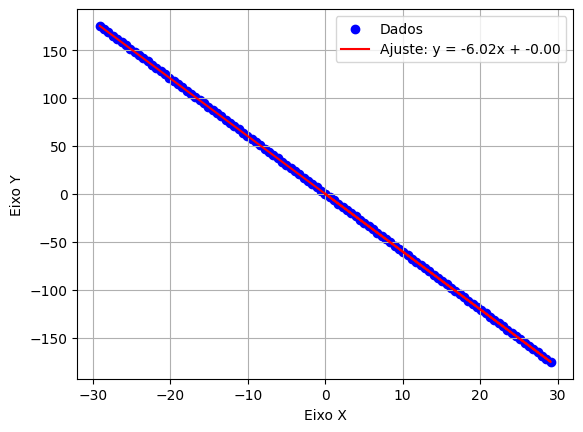

slope -6.0205193601786355
dslope 0.0002407508499084489
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121152380947024, -28.561152380949352, -28.00115238095168, -27.44115238095401, -26.881152380956337, -26.321152380958665, -25.76115238094644, -25.20115238094877, -24.641152380951098, -24.081152380953426, -23.521152380955755, -22.961152380958083, -22.40115238096041, -21.841152380948188, -21.281152380950516, -20.721152380952844, -20.161152380955173, -19.6011523809575, -19.04115238095983, -18.480152380958316, -17.920152380960644, -17.36015238094842, -16.80015238095075, -16.240152380953077, -15.680152380955406, -15.120152380957734, -14.560152380960062, -14.000152380947839, -13.440152380950167, -12.880152380952495, -12.320152380954823, -11.760152380957152, -11.20015238095948, -10.640152380947256, -10.080152380949585, -9.520152380951913, -8.960152380954241, -8.40015238095657, -7.840152380958898, -7.280152380946674, -6.720152380949003, -6.160152380951331, -5.600152380953659, -5.040152380955988, -4.480

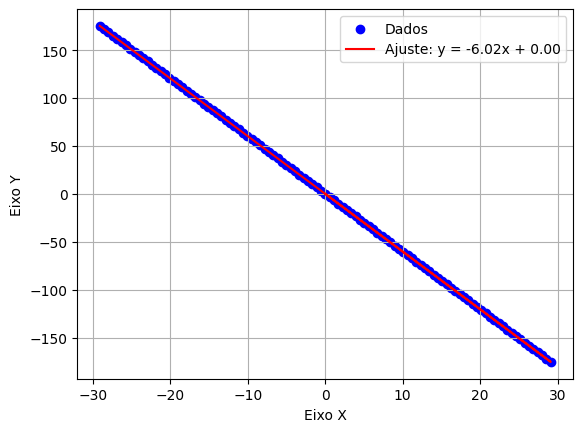

slope -6.020114018845928
dslope 0.00022415733133953974
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12127619048988, -28.561276190492208, -28.001276190494536, -27.441276190482313, -26.88127619048464, -26.32127619048697, -25.761276190489298, -25.201276190491626, -24.641276190493954, -24.08127619048173, -23.52127619048406, -22.961276190486387, -22.401276190488716, -21.840276190487202, -21.28027619048953, -20.72027619049186, -20.160276190494187, -19.600276190481964, -19.040276190484292, -18.48027619048662, -17.92027619048895, -17.360276190491277, -16.800276190493605, -16.24027619048138, -15.68027619048371, -15.120276190486038, -14.560276190488366, -14.000276190490695, -13.440276190493023, -12.8802761904808, -12.320276190483128, -11.760276190485456, -11.200276190487784, -10.640276190490113, -10.080276190492441, -9.52027619049477, -8.960276190482546, -8.400276190484874, -7.840276190487202, -7.280276190489531, -6.720276190491859, -6.160276190494187, -5.600276190481964, -5.040276190484292, -4.48027

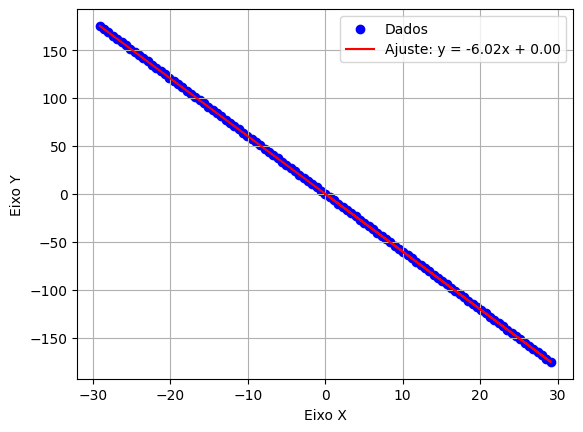

slope -6.0200531782062185
dslope 0.00022141636063481465
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12140952379559, -28.56140952379792, -28.00140952380025, -27.441409523802577, -26.881409523804905, -26.32140952379268, -25.76040952380572, -25.200409523793496, -24.640409523795824, -24.080409523798153, -23.52040952380048, -22.96040952380281, -22.400409523805138, -21.840409523792914, -21.280409523795242, -20.72040952379757, -20.1604095237999, -19.600409523802227, -19.040409523804556, -18.480409523792332, -17.92040952379466, -17.36040952379699, -16.800409523799317, -16.240409523801645, -15.680409523803974, -15.120409523806302, -14.560409523794078, -14.000409523796407, -13.440409523798735, -12.880409523801063, -12.320409523803391, -11.76040952380572, -11.200409523793496, -10.640409523795824, -10.080409523798153, -9.520409523800481, -8.96040952380281, -8.400409523805138, -7.840409523792914, -7.280409523795242, -6.720409523797571, -6.160409523799899, -5.600409523802227, -5.040409523804556, -4.4804

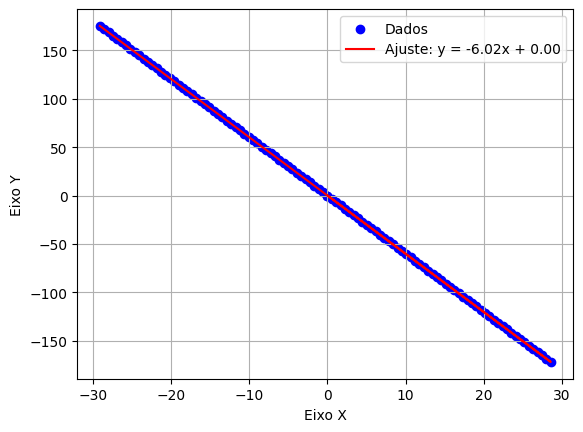

slope -6.020972576779334
dslope 0.0002082170328337973
len(ttime) 105
l+l2 106
l2 2
ttime [-29.120590476188227, -28.560590476190555, -28.000590476192883, -27.44059047618066, -26.880590476182988, -26.320590476185316, -25.760590476187645, -25.200590476189973, -24.6405904761923, -24.08059047619463, -23.520590476182406, -22.960590476184734, -22.400590476187062, -21.84059047618939, -21.28059047619172, -20.720590476194047, -20.160590476181824, -19.600590476184152, -19.04059047618648, -18.48059047618881, -17.920590476191137, -17.360590476193465, -16.80059047618124, -16.24059047618357, -15.680590476185898, -15.120590476188227, -14.560590476190555, -14.000590476192883, -13.44059047618066, -12.880590476182988, -12.320590476185316, -11.760590476187645, -11.200590476189973, -10.640590476192301, -10.08059047619463, -9.520590476182406, -8.960590476184734, -8.400590476187062, -7.840590476189391, -7.280590476191719, -6.720590476194047, -6.160590476181824, -5.600590476184152, -5.04059047618648, -4.48059

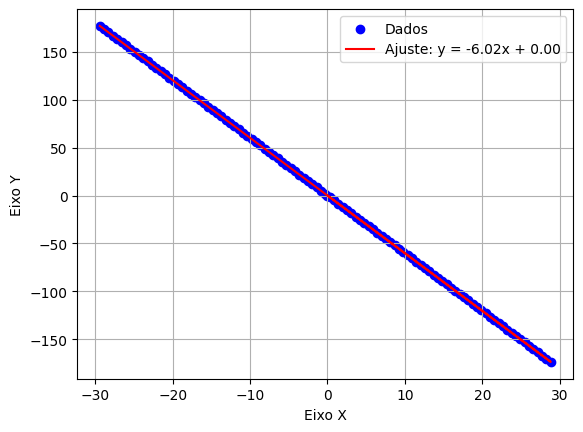

slope -6.0201573622658024
dslope 0.0002329721719748574
len(ttime) 106
l+l2 107
l2 2
ttime [-29.40071698113752, -28.840716981125297, -28.280716981127625, -27.720716981129954, -27.160716981132282, -26.60071698113461, -26.04071698113694, -25.480716981124715, -24.920716981127043, -24.36071698112937, -23.8007169811317, -23.240716981134028, -22.680716981136356, -22.120716981124133, -21.56071698112646, -21.00071698112879, -20.440716981131118, -19.880716981133446, -19.320716981135774, -18.76071698112355, -18.20071698112588, -17.640716981128207, -17.080716981130536, -16.520716981132864, -15.960716981135192, -15.40071698113752, -14.840716981125297, -14.280716981127625, -13.720716981129954, -13.160716981132282, -12.60071698113461, -12.040716981136939, -11.480716981124715, -10.920716981127043, -10.360716981129372, -9.8007169811317, -9.240716981134028, -8.680716981136356, -8.120716981124133, -7.560716981126461, -7.0007169811287895, -6.440716981131118, -5.880716981133446, -5.319716981131933, -4.7597

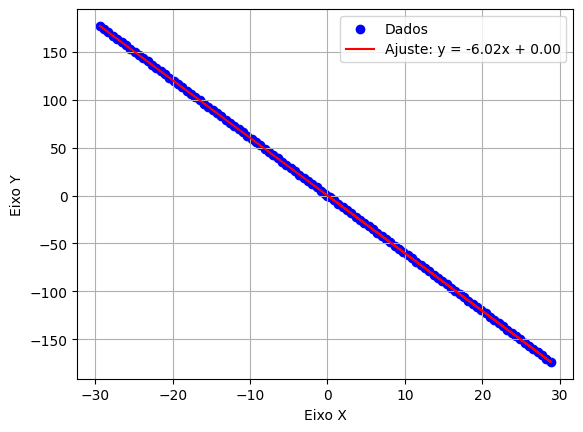

slope -6.020653667980291
dslope 0.00023131782255839117
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400849056604784, -28.840849056607112, -28.28084905660944, -27.720849056597217, -27.160849056599545, -26.600849056601874, -26.040849056604202, -25.48084905660653, -24.92084905660886, -24.360849056596635, -23.800849056598963, -23.24084905660129, -22.68084905660362, -22.120849056605948, -21.560849056608276, -21.000849056610605, -20.44084905659838, -19.88084905660071, -19.320849056603038, -18.760849056605366, -18.200849056607694, -17.640849056610023, -17.0808490565978, -16.520849056600127, -15.960849056602456, -15.400849056604784, -14.840849056607112, -14.28084905660944, -13.720849056597217, -13.160849056599545, -12.600849056601874, -12.040849056604202, -11.48084905660653, -10.920849056608859, -10.360849056596635, -9.800849056598963, -9.23984905659745, -8.679849056599778, -8.119849056602106, -7.559849056604435, -6.999849056606763, -6.439849056609091, -5.879849056596868, -5.319849056599196, -4.759

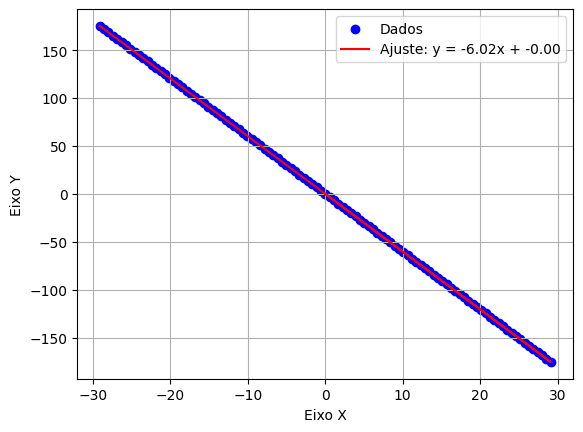

slope -6.020659837079751
dslope 0.00022328971928745829
len(ttime) 106
l+l2 106
l2 1
ttime [-29.1209714285651, -28.560971428567427, -28.000971428569756, -27.440971428572084, -26.880971428574412, -26.32097142857674, -25.760971428564517, -25.200971428566845, -24.640971428569173, -24.0809714285715, -23.52097142857383, -22.96097142857616, -22.400971428563935, -21.840971428566263, -21.28097142856859, -20.72097142857092, -20.160971428573248, -19.600971428575576, -19.040971428563353, -18.48097142856568, -17.92097142856801, -17.360971428570338, -16.800971428572666, -16.240971428574994, -15.68097142856277, -15.120971428565099, -14.560971428567427, -14.000971428569756, -13.440971428572084, -12.87997142857057, -12.319971428572899, -11.759971428575227, -11.199971428563003, -10.639971428565332, -10.07997142856766, -9.519971428569988, -8.959971428572317, -8.399971428574645, -7.839971428576973, -7.27997142856475, -6.719971428567078, -6.159971428569406, -5.599971428571735, -5.039971428574063, -4.479971

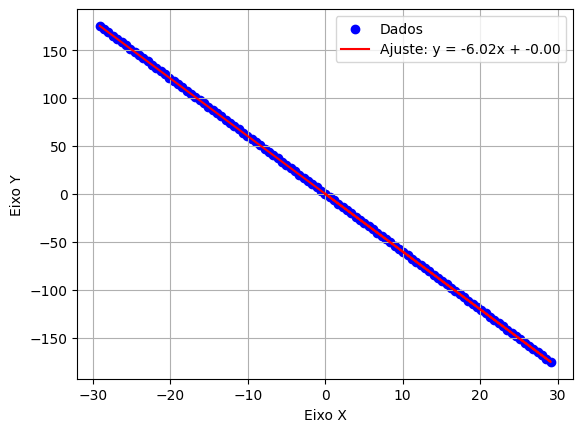

slope -6.021331467723648
dslope 0.0001768528636339018
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121114285720978, -28.561114285723306, -28.001114285711083, -27.44111428571341, -26.88111428571574, -26.321114285718068, -25.761114285720396, -25.201114285722724, -24.6411142857105, -24.08111428571283, -23.521114285715157, -22.961114285717485, -22.401114285719814, -21.841114285722142, -21.28111428570992, -20.721114285712247, -20.161114285714575, -19.601114285716903, -19.04111428571923, -18.48111428572156, -17.92111428572389, -17.360114285722375, -16.80011428571015, -16.24011428571248, -15.680114285714808, -15.120114285717136, -14.560114285719465, -14.000114285721793, -13.440114285724121, -12.880114285711898, -12.320114285714226, -11.760114285716554, -11.200114285718882, -10.64011428572121, -10.080114285723539, -9.520114285711315, -8.960114285713644, -8.400114285715972, -7.8401142857183, -7.280114285720629, -6.720114285722957, -6.160114285710733, -5.600114285713062, -5.04011428571539, -4.4801142

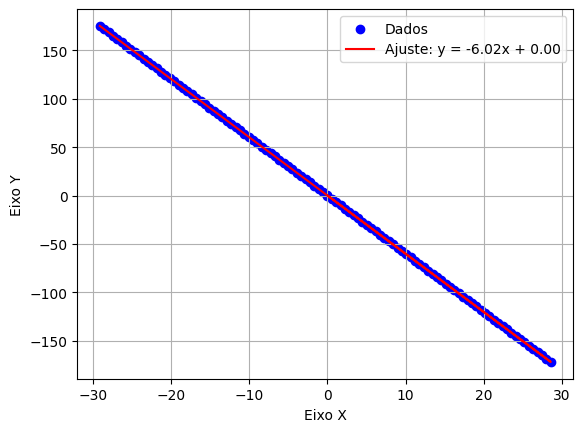

slope -6.021217483763086
dslope 0.00021216794302566562
len(ttime) 105
l+l2 106
l2 2
ttime [-29.12123809522018, -28.561238095222507, -28.001238095224835, -27.441238095227163, -26.88123809522949, -26.321238095217268, -25.761238095219596, -25.201238095221925, -24.641238095224253, -24.08123809522658, -23.52123809522891, -22.961238095216686, -22.401238095219014, -21.841238095221343, -21.28123809522367, -20.720238095222157, -20.160238095224486, -19.600238095226814, -19.040238095229142, -18.48023809521692, -17.920238095219247, -17.360238095221575, -16.800238095223904, -16.240238095226232, -15.68023809522856, -15.120238095216337, -14.560238095218665, -14.000238095220993, -13.440238095223322, -12.88023809522565, -12.320238095227978, -11.760238095215755, -11.200238095218083, -10.640238095220411, -10.08023809522274, -9.520238095225068, -8.960238095227396, -8.400238095215173, -7.840238095217501, -7.280238095219829, -6.720238095222157, -6.160238095224486, -5.600238095226814, -5.040238095229142, -4.

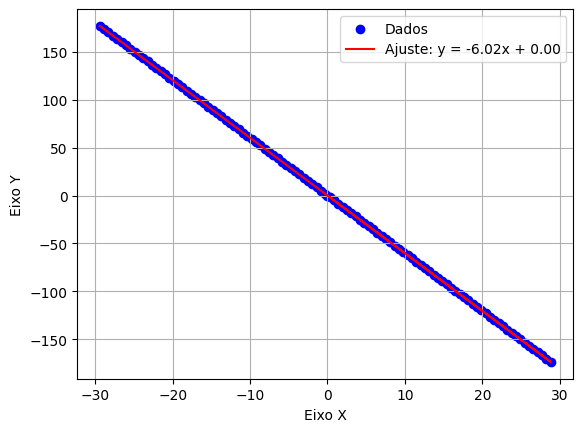

slope -6.0212806887027
dslope 0.00023888639620559294
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401367924539954, -28.841367924542283, -28.28136792453006, -27.721367924532387, -27.161367924534716, -26.601367924537044, -26.041367924539372, -25.4813679245417, -24.920367924540187, -24.360367924542516, -23.800367924530292, -23.24036792453262, -22.68036792453495, -22.120367924537277, -21.560367924539605, -21.000367924541933, -20.44036792452971, -19.880367924532038, -19.320367924534366, -18.760367924536695, -18.200367924539023, -17.64036792454135, -17.080367924529128, -16.520367924531456, -15.960367924533784, -15.400367924536113, -14.840367924538441, -14.28036792454077, -13.720367924528546, -13.160367924530874, -12.600367924533202, -12.04036792453553, -11.480367924537859, -10.920367924540187, -10.360367924542516, -9.800367924530292, -9.24036792453262, -8.680367924534949, -8.120367924537277, -7.560367924539605, -7.0003679245419335, -6.44036792452971, -5.880367924532038, -5.3203679245343665, -4.76

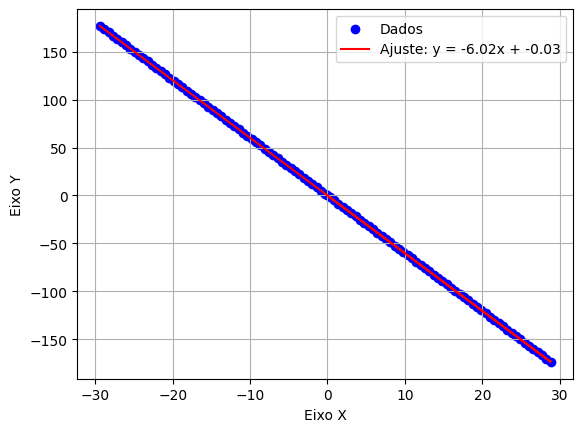

slope -6.021817440175109
dslope 0.0002522866708602022
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401528301881626, -28.841528301883955, -28.28052830188244, -27.72052830188477, -27.160528301887098, -26.600528301889426, -26.040528301877202, -25.48052830187953, -24.92052830188186, -24.360528301884187, -23.800528301886516, -23.240528301888844, -22.68052830187662, -22.12052830187895, -21.560528301881277, -21.000528301883605, -20.440528301885934, -19.880528301888262, -19.32052830189059, -18.760528301878367, -18.200528301880695, -17.640528301883023, -17.08052830188535, -16.52052830188768, -15.960528301890008, -15.400528301877785, -14.840528301880113, -14.280528301882441, -13.72052830188477, -13.160528301887098, -12.600528301889426, -12.040528301877202, -11.48052830187953, -10.920528301881859, -10.360528301884187, -9.800528301886516, -9.240528301888844, -8.68052830187662, -8.120528301878949, -7.560528301881277, -7.000528301883605, -6.440528301885934, -5.880528301888262, -5.32052830189059, -4.76052

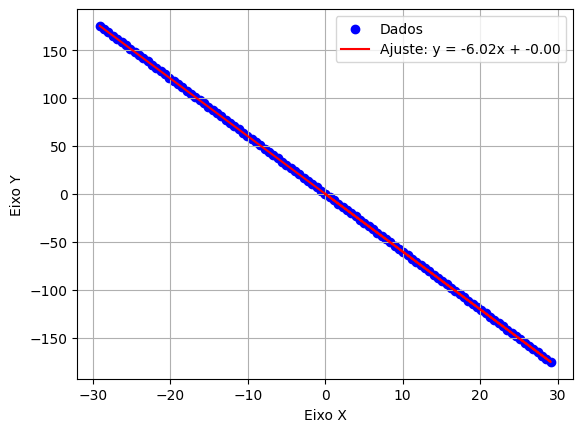

slope -6.021768015960176
dslope 0.0002099359872999512
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120666666683974, -28.560666666686302, -28.00066666667408, -27.440666666676407, -26.880666666678735, -26.320666666681063, -25.76066666668339, -25.20066666668572, -24.64066666668805, -24.080666666675825, -23.520666666678153, -22.96066666668048, -22.40066666668281, -21.840666666685138, -21.280666666687466, -20.720666666675243, -20.16066666667757, -19.6006666666799, -19.040666666682228, -18.480666666684556, -17.920666666686884, -17.36066666667466, -16.80066666667699, -16.240666666679317, -15.680666666681645, -15.120666666683974, -14.560666666686302, -14.000666666674078, -13.440666666676407, -12.880666666678735, -12.320666666681063, -11.760666666683392, -11.20066666668572, -10.640666666688048, -10.080666666675825, -9.520666666678153, -8.960666666680481, -8.40066666668281, -7.840666666685138, -7.280666666687466, -6.720666666675243, -6.160666666677571, -5.600666666679899, -5.0406666666822275, -4.4806

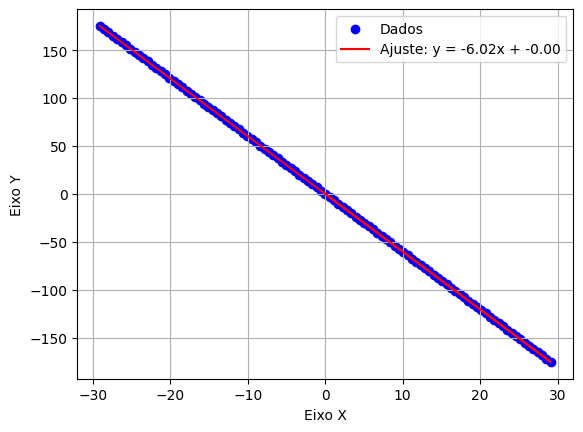

slope -6.021059784816945
dslope 0.0001880945499326402
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120799999989686, -28.560799999992014, -28.000799999994342, -27.44079999999667, -26.880799999999, -26.320799999986775, -25.760799999989104, -25.200799999991432, -24.64079999999376, -24.08079999999609, -23.520799999998417, -22.960799999986193, -22.40079999998852, -21.84079999999085, -21.280799999993178, -20.720799999995506, -20.160799999997835, -19.60079999998561, -19.04079999998794, -18.480799999990268, -17.920799999992596, -17.360799999994924, -16.800799999997253, -16.24079999999958, -15.680799999987357, -15.120799999989686, -14.560799999992014, -14.000799999994342, -13.44079999999667, -12.880799999998999, -12.320799999986775, -11.760799999989104, -11.200799999991432, -10.64079999999376, -10.080799999996088, -9.520799999998417, -8.960799999986193, -8.400799999988521, -7.839799999987008, -7.279799999989336, -6.719799999991665, -6.159799999993993, -5.599799999996321, -5.03979999999865, -4.479799

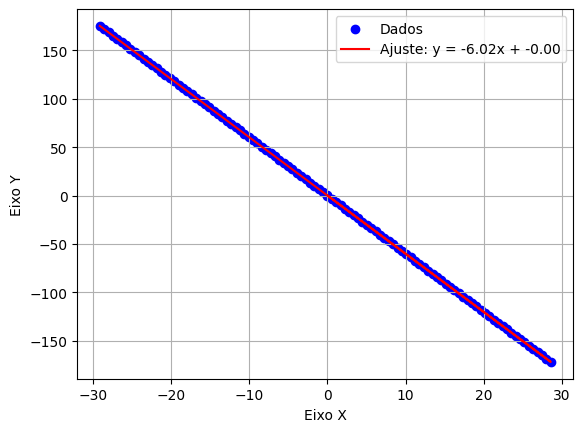

slope -6.020586137890271
dslope 0.0002230068439676028
len(ttime) 105
l+l2 106
l2 2
ttime [-29.120933333353605, -28.56093333334138, -28.00093333334371, -27.440933333346038, -26.880933333348366, -26.320933333350695, -25.760933333353023, -25.2009333333408, -24.640933333343128, -24.080933333345456, -23.520933333347784, -22.960933333350113, -22.40093333335244, -21.84093333335477, -21.280933333342546, -20.720933333344874, -20.160933333347202, -19.60093333334953, -19.04093333335186, -18.480933333354187, -17.920933333341964, -17.360933333344292, -16.80093333334662, -16.24093333334895, -15.680933333351277, -15.120933333353605, -14.560933333341382, -14.00093333334371, -13.440933333346038, -12.880933333348366, -12.320933333350695, -11.759933333349181, -11.19993333335151, -10.639933333353838, -10.079933333341614, -9.519933333343943, -8.959933333346271, -8.3999333333486, -7.839933333350928, -7.279933333353256, -6.719933333341032, -6.159933333343361, -5.599933333345689, -5.039933333348017, -4.479933

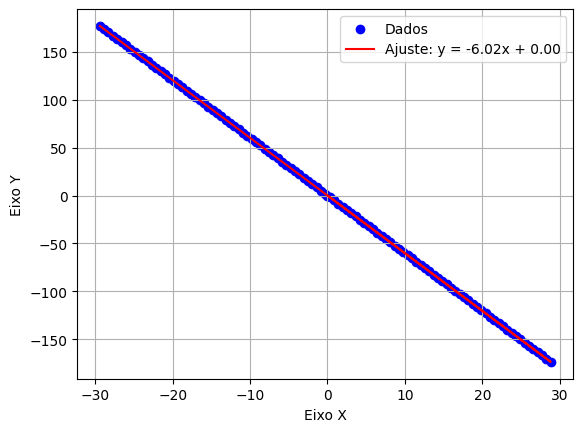

slope -6.020167194343717
dslope 0.00024027592378697113
len(ttime) 106
l+l2 107
l2 2
ttime [-29.40105660377594, -28.84105660377827, -28.2810566037806, -27.721056603782927, -27.161056603785255, -26.60105660377303, -26.04105660377536, -25.481056603777688, -24.921056603780016, -24.361056603782345, -23.801056603784673, -23.24105660377245, -22.681056603774778, -22.121056603777106, -21.561056603779434, -21.001056603781763, -20.44105660378409, -19.881056603771867, -19.321056603774196, -18.761056603776524, -18.201056603778852, -17.64105660378118, -17.08105660378351, -16.521056603771285, -15.961056603773613, -15.4000566037721, -14.840056603774428, -14.280056603776757, -13.720056603779085, -13.160056603781413, -12.600056603783742, -12.040056603771518, -11.480056603773846, -10.920056603776175, -10.360056603778503, -9.800056603780831, -9.24005660378316, -8.680056603785488, -8.120056603773264, -7.5600566037755925, -7.000056603777921, -6.440056603780249, -5.880056603782577, -5.320056603784906, -4.760

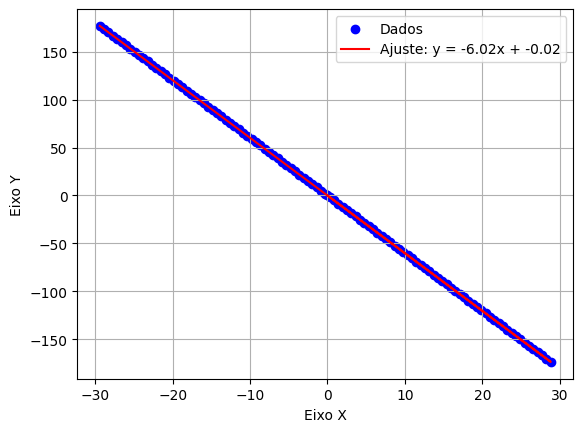

slope -6.021276384104849
dslope 0.0002349763850592185
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401188679257757, -28.841188679245533, -28.28118867924786, -27.72118867925019, -27.16118867925252, -26.601188679254847, -26.041188679257175, -25.48118867924495, -24.92118867924728, -24.361188679249608, -23.801188679251936, -23.241188679254265, -22.681188679256593, -22.12118867925892, -21.561188679246698, -21.001188679249026, -20.441188679251354, -19.881188679253682, -19.32018867925217, -18.760188679254497, -18.200188679256826, -17.640188679244602, -17.08018867924693, -16.52018867924926, -15.960188679251587, -15.400188679253915, -14.840188679256244, -14.280188679258572, -13.720188679246348, -13.160188679248677, -12.600188679251005, -12.040188679253333, -11.480188679255662, -10.92018867925799, -10.360188679245766, -9.800188679248095, -9.240188679250423, -8.680188679252751, -8.12018867925508, -7.560188679257408, -7.000188679245184, -6.4401886792475125, -5.880188679249841, -5.320188679252169, -4.76

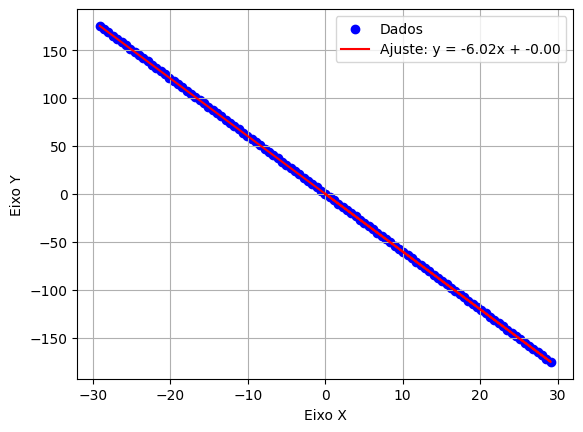

slope -6.02059199197368
dslope 0.00022380676831983636
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121323809522437, -28.561323809524765, -28.001323809527094, -27.441323809529422, -26.8813238095172, -26.321323809519527, -25.761323809521855, -25.201323809524183, -24.64132380952651, -24.08132380952884, -23.520323809527326, -22.960323809515103, -22.40032380951743, -21.84032380951976, -21.280323809522088, -20.720323809524416, -20.160323809526744, -19.600323809529073, -19.04032380951685, -18.480323809519177, -17.920323809521506, -17.360323809523834, -16.800323809526162, -16.24032380952849, -15.680323809516267, -15.120323809518595, -14.560323809520924, -14.000323809523252, -13.44032380952558, -12.880323809527908, -12.320323809515685, -11.760323809518013, -11.200323809520341, -10.64032380952267, -10.080323809524998, -9.520323809527326, -8.960323809515103, -8.400323809517431, -7.840323809519759, -7.280323809522088, -6.720323809524416, -6.160323809526744, -5.600323809529073, -5.040323809516849, -4.48

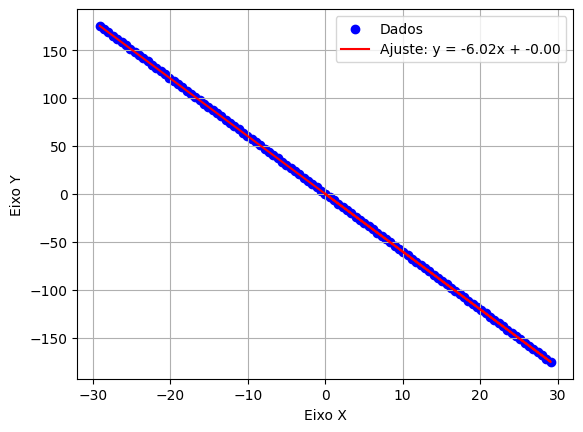

slope -6.020029989647247
dslope 0.00022005480985920386
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121466666663764, -28.561466666666092, -28.00146666666842, -27.44146666667075, -26.880466666669236, -26.320466666671564, -25.760466666673892, -25.20046666667622, -24.640466666663997, -24.080466666666325, -23.520466666668653, -22.960466666670982, -22.40046666667331, -21.84046666667564, -21.280466666663415, -20.720466666665743, -20.16046666666807, -19.6004666666704, -19.040466666672728, -18.480466666675056, -17.920466666662833, -17.36046666666516, -16.80046666666749, -16.240466666669818, -15.680466666672146, -15.120466666674474, -14.560466666676803, -14.000466666664579, -13.440466666666907, -12.880466666669236, -12.320466666671564, -11.760466666673892, -11.20046666667622, -10.640466666663997, -10.080466666666325, -9.520466666668653, -8.960466666670982, -8.40046666667331, -7.840466666675638, -7.280466666663415, -6.720466666665743, -6.160466666668071, -5.6004666666704, -5.040466666672728, -4.48046

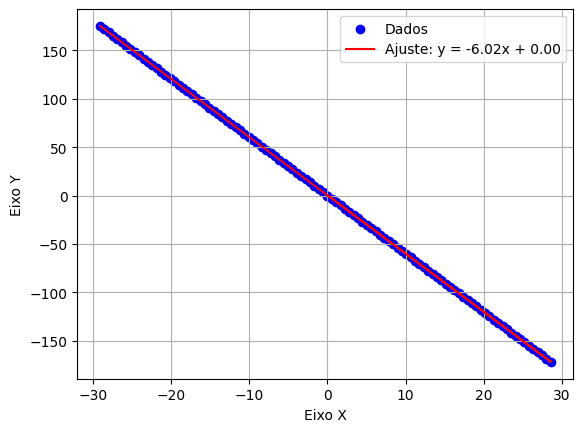

slope -6.019884148862069
dslope 0.0002067065466136507
len(ttime) 105
l+l2 106
l2 2
ttime [-29.120628571428824, -28.560628571431153, -28.00062857143348, -27.44062857143581, -26.880628571423586, -26.320628571425914, -25.760628571428242, -25.20062857143057, -24.6406285714329, -24.080628571435227, -23.520628571423003, -22.96062857142533, -22.40062857142766, -21.84062857142999, -21.280628571432317, -20.720628571434645, -20.160628571436973, -19.60062857142475, -19.040628571427078, -18.480628571429406, -17.920628571431735, -17.360628571434063, -16.80062857143639, -16.240628571424168, -15.680628571426496, -15.120628571428824, -14.560628571431153, -14.00062857143348, -13.44062857143581, -12.880628571423586, -12.320628571425914, -11.760628571428242, -11.20062857143057, -10.640628571432899, -10.080628571435227, -9.520628571423003, -8.960628571425332, -8.40062857142766, -7.840628571429988, -7.280628571432317, -6.720628571434645, -6.160628571436973, -5.60062857142475, -5.040628571427078, -4.4806285

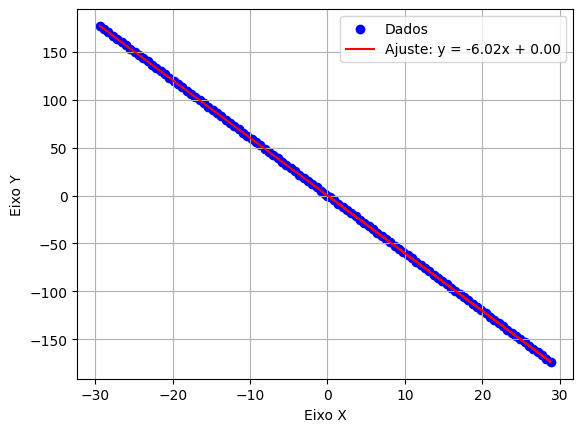

slope -6.020090669744034
dslope 0.00027171779933851133
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400754716989468, -28.840754716977244, -28.280754716979573, -27.7207547169819, -27.16075471698423, -26.600754716986557, -26.040754716988886, -25.480754716991214, -24.92075471697899, -24.36075471698132, -23.800754716983647, -23.240754716985975, -22.680754716988304, -22.120754716990632, -21.56075471697841, -21.000754716980737, -20.440754716983065, -19.880754716985393, -19.32075471698772, -18.76075471699005, -18.200754716977826, -17.640754716980155, -17.080754716982483, -16.52075471698481, -15.96075471698714, -15.400754716989468, -14.840754716977244, -14.280754716979573, -13.7207547169819, -13.16075471698423, -12.600754716986557, -12.040754716988886, -11.480754716991214, -10.92075471697899, -10.360754716981319, -9.800754716983647, -9.240754716985975, -8.680754716988304, -8.120754716990632, -7.560754716978408, -7.000754716980737, -6.439754716979223, -5.879754716981552, -5.31975471698388, -4.759754

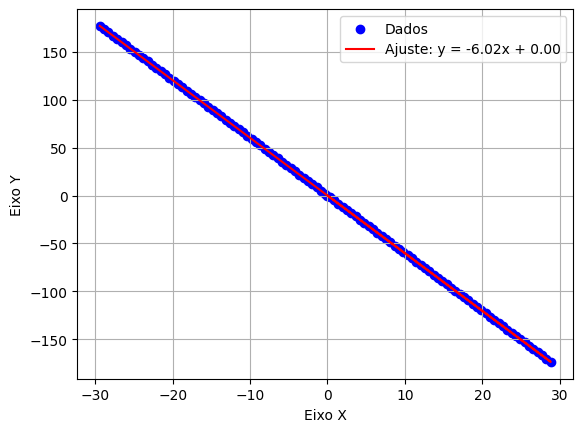

slope -6.020049749152886
dslope 0.00024753418404769065
len(ttime) 106
l+l2 107
l2 2
ttime [-29.40088679245673, -28.84088679245906, -28.280886792461388, -27.720886792463716, -27.160886792451493, -26.60088679245382, -26.04088679245615, -25.480886792458477, -24.920886792460806, -24.360886792463134, -23.80088679245091, -23.24088679245324, -22.680886792455567, -22.120886792457895, -21.560886792460224, -21.000886792462552, -20.44088679245033, -19.880886792452657, -19.320886792454985, -18.760886792457313, -18.20088679245964, -17.64088679246197, -17.080886792464298, -16.520886792452075, -15.960886792454403, -15.400886792456731, -14.84088679245906, -14.280886792461388, -13.720886792463716, -13.160886792451493, -12.60088679245382, -12.04088679245615, -11.480886792458477, -10.920886792460806, -10.359886792459292, -9.79988679246162, -9.239886792463949, -8.679886792451725, -8.119886792454054, -7.559886792456382, -6.99988679245871, -6.439886792461039, -5.879886792463367, -5.319886792451143, -4.75988

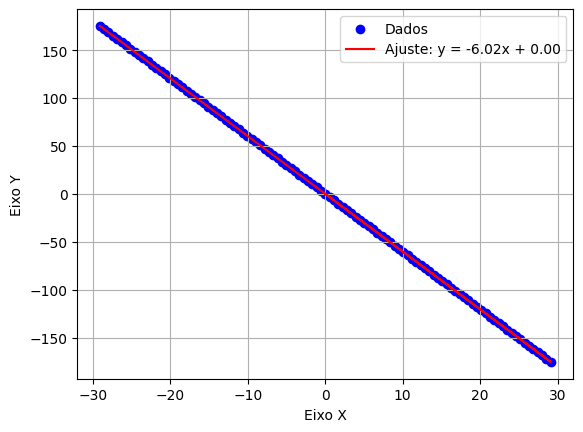

slope -6.020052709722759
dslope 0.0002507982728965511
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121009523805697, -28.561009523808025, -28.001009523810353, -27.44100952381268, -26.88100952381501, -26.321009523817338, -25.761009523805114, -25.201009523807443, -24.64100952380977, -24.0810095238121, -23.521009523814428, -22.961009523816756, -22.401009523819084, -21.84100952380686, -21.28100952380919, -20.721009523811517, -20.161009523813846, -19.601009523816174, -19.041009523818502, -18.48100952380628, -17.921009523808607, -17.361009523810935, -16.801009523813264, -16.241009523815592, -15.68100952381792, -15.121009523805697, -14.561009523808025, -14.000009523806511, -13.44000952380884, -12.880009523811168, -12.320009523813496, -11.760009523815825, -11.200009523818153, -10.64000952380593, -10.080009523808258, -9.520009523810586, -8.960009523812914, -8.400009523815243, -7.840009523817571, -7.280009523805347, -6.720009523807676, -6.160009523810004, -5.600009523812332, -5.0400095238146605, -4.48

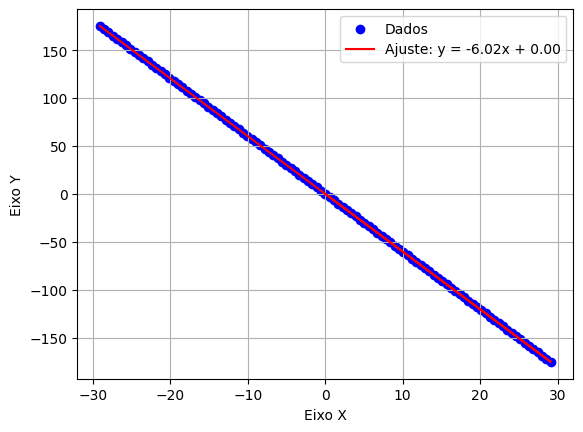

slope -6.020059357839713
dslope 0.0002086148901044248
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121142857155064, -28.561142857157392, -28.00114285715972, -27.441142857147497, -26.881142857149825, -26.321142857152154, -25.761142857154482, -25.20114285715681, -24.64114285715914, -24.081142857146915, -23.521142857149243, -22.96114285715157, -22.4011428571539, -21.84114285715623, -21.281142857158557, -20.721142857146333, -20.16114285714866, -19.60114285715099, -19.041142857153318, -18.481142857155646, -17.920142857154133, -17.36014285715646, -16.80014285715879, -16.240142857146566, -15.680142857148894, -15.120142857151222, -14.56014285715355, -14.000142857155879, -13.440142857158207, -12.880142857145984, -12.320142857148312, -11.76014285715064, -11.200142857152969, -10.640142857155297, -10.080142857157625, -9.520142857159954, -8.96014285714773, -8.400142857150058, -7.840142857152387, -7.280142857154715, -6.720142857157043, -6.1601428571593715, -5.600142857147148, -5.040142857149476, -4.48014

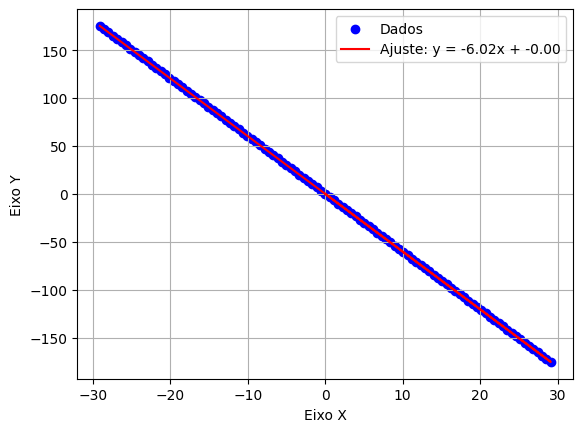

slope -6.021045164030763
dslope 0.00021042726744576964
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121276190475328, -28.561276190477656, -28.001276190479985, -27.441276190482313, -26.88127619048464, -26.321276190472418, -25.761276190474746, -25.201276190477074, -24.641276190479402, -24.08127619048173, -23.52127619048406, -22.961276190486387, -22.401276190474164, -21.84027619047265, -21.28027619047498, -20.720276190477307, -20.160276190479635, -19.600276190481964, -19.040276190484292, -18.48027619047207, -17.920276190474397, -17.360276190476725, -16.800276190479053, -16.24027619048138, -15.68027619048371, -15.120276190486038, -14.560276190473814, -14.000276190476143, -13.440276190478471, -12.8802761904808, -12.320276190483128, -11.760276190485456, -11.200276190473232, -10.64027619047556, -10.080276190477889, -9.520276190480217, -8.960276190482546, -8.400276190484874, -7.84027619047265, -7.280276190474979, -6.720276190477307, -6.160276190479635, -5.600276190481964, -5.040276190484292, -4.480

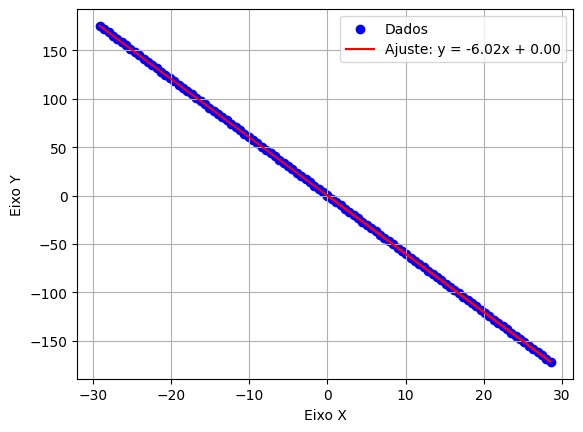

slope -6.020987657834319
dslope 0.00022213306370830278
len(ttime) 105
l+l2 106
l2 2
ttime [-29.121409523810144, -28.561409523812472, -28.00140952380025, -27.441409523802577, -26.881409523804905, -26.321409523807233, -25.76040952380572, -25.200409523808048, -24.640409523810376, -24.080409523812705, -23.52040952380048, -22.96040952380281, -22.400409523805138, -21.840409523807466, -21.280409523809794, -20.720409523812123, -20.1604095237999, -19.600409523802227, -19.040409523804556, -18.480409523806884, -17.920409523809212, -17.36040952381154, -16.800409523799317, -16.240409523801645, -15.680409523803974, -15.120409523806302, -14.56040952380863, -14.000409523810958, -13.440409523798735, -12.880409523801063, -12.320409523803391, -11.76040952380572, -11.200409523808048, -10.640409523810376, -10.080409523812705, -9.520409523800481, -8.96040952380281, -8.400409523805138, -7.840409523807466, -7.280409523809794, -6.720409523812123, -6.160409523799899, -5.600409523802227, -5.040409523804556, -4.4

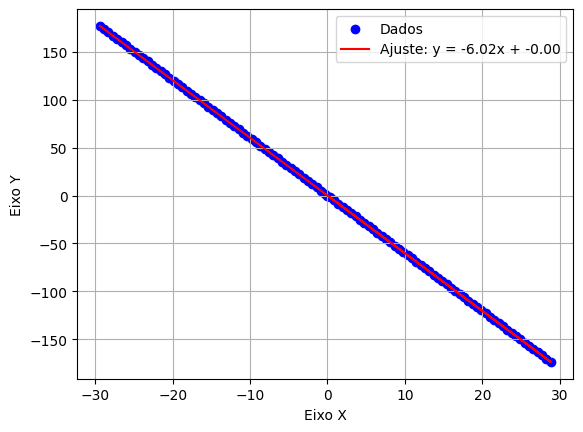

slope -6.020961803277109
dslope 0.0002526776445298893
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400584905670257, -28.840584905658034, -28.280584905660362, -27.72058490566269, -27.16058490566502, -26.600584905667347, -26.040584905669675, -25.48058490565745, -24.92058490565978, -24.360584905662108, -23.800584905664437, -23.240584905666765, -22.680584905669093, -22.12058490565687, -21.560584905659198, -21.000584905661526, -20.440584905663854, -19.880584905666183, -19.32058490566851, -18.760584905656287, -18.200584905658616, -17.640584905660944, -17.080584905663272, -16.5205849056656, -15.960584905667929, -15.400584905670257, -14.840584905658034, -14.280584905660362, -13.72058490566269, -13.160584905665019, -12.600584905667347, -12.040584905669675, -11.480584905657452, -10.92058490565978, -10.360584905662108, -9.800584905664437, -9.240584905666765, -8.680584905669093, -8.12058490565687, -7.560584905659198, -7.000584905661526, -6.440584905663854, -5.880584905666183, -5.320584905668511, -4.760

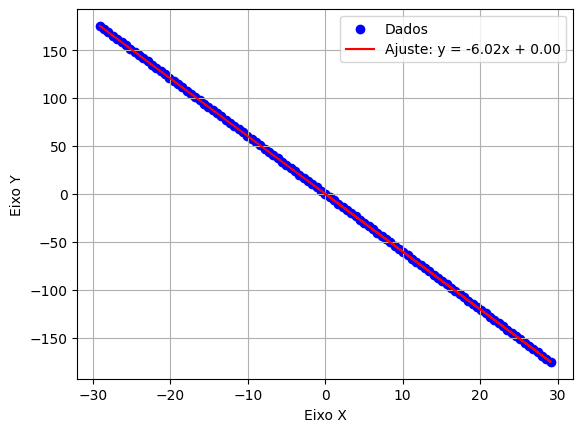

slope -6.021239947188403
dslope 0.00023653895888589474
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120704761895468, -28.560704761897796, -28.000704761900124, -27.4407047618879, -26.88070476189023, -26.320704761892557, -25.760704761894885, -25.200704761897214, -24.640704761899542, -24.08070476188732, -23.520704761889647, -22.960704761891975, -22.400704761894303, -21.84070476189663, -21.28070476189896, -20.72070476190129, -20.160704761889065, -19.600704761891393, -19.04070476189372, -18.48070476189605, -17.920704761898378, -17.360704761900706, -16.800704761888483, -16.24070476189081, -15.68070476189314, -15.120704761895468, -14.560704761897796, -14.000704761900124, -13.4407047618879, -12.880704761890229, -12.320704761892557, -11.760704761894885, -11.200704761897214, -10.640704761899542, -10.080704761887318, -9.520704761889647, -8.960704761891975, -8.400704761894303, -7.840704761896632, -7.28070476189896, -6.720704761901288, -6.160704761889065, -5.600704761891393, -5.03970476188988, -4.479704

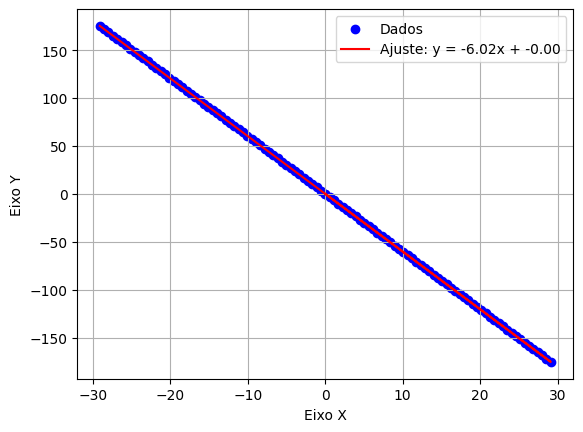

slope -6.020366974592687
dslope 0.00019654247138553446
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120838095244835, -28.560838095247163, -28.00083809524949, -27.44083809525182, -26.88083809525415, -26.320838095256477, -25.760838095244253, -25.20083809524658, -24.64083809524891, -24.080838095251238, -23.520838095253566, -22.960838095255895, -22.40083809524367, -21.840838095246, -21.280838095248328, -20.720838095250656, -20.160838095252984, -19.600838095255313, -19.04083809524309, -18.480838095245417, -17.920838095247746, -17.360838095250074, -16.800838095252402, -16.24083809525473, -15.680838095242507, -15.120838095244835, -14.560838095247163, -14.000838095249492, -13.44083809525182, -12.880838095254148, -12.320838095256477, -11.760838095244253, -11.200838095246581, -10.64083809524891, -10.080838095251238, -9.520838095253566, -8.959838095252053, -8.399838095254381, -7.8398380952567095, -7.279838095244486, -6.719838095246814, -6.1598380952491425, -5.599838095251471, -5.039838095253799, -4.47

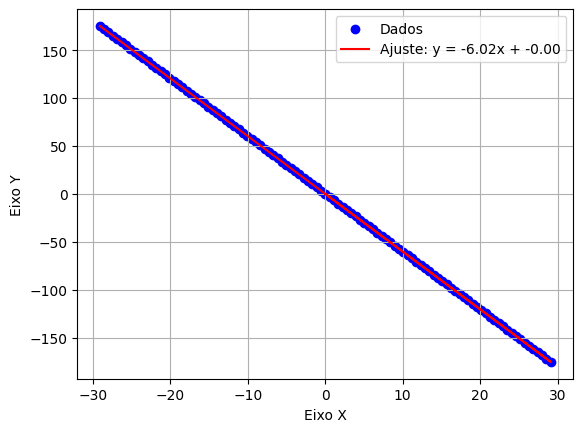

slope -6.020907351997853
dslope 0.000220164560431013
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12097142857965, -28.56097142858198, -28.000971428569756, -27.440971428572084, -26.880971428574412, -26.32097142857674, -25.76097142857907, -25.200971428581397, -24.640971428569173, -24.0809714285715, -23.52097142857383, -22.96097142857616, -22.400971428578487, -21.840971428580815, -21.28097142856859, -20.72097142857092, -20.160971428573248, -19.600971428575576, -19.040971428577905, -18.480971428580233, -17.92097142858256, -17.360971428570338, -16.800971428572666, -16.240971428574994, -15.680971428577323, -15.12097142857965, -14.56097142858198, -14.000971428569756, -13.440971428572084, -12.87997142857057, -12.319971428572899, -11.759971428575227, -11.199971428577555, -10.639971428579884, -10.079971428582212, -9.519971428569988, -8.959971428572317, -8.399971428574645, -7.839971428576973, -7.279971428579302, -6.71997142858163, -6.159971428569406, -5.599971428571735, -5.039971428574063, -4.47997142

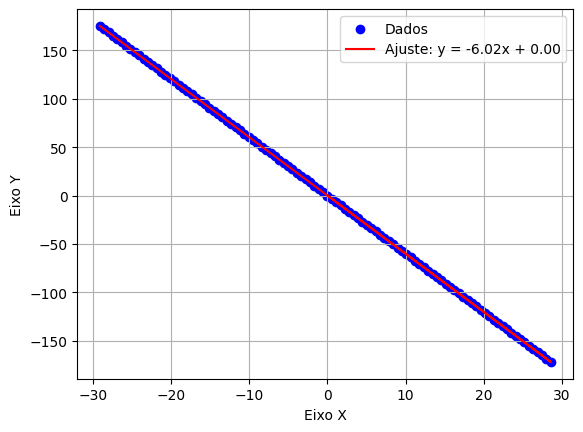

slope -6.020693201920287
dslope 0.00022196556443487462
len(ttime) 105
l+l2 106
l2 2
ttime [-29.121104761899915, -28.561104761902243, -28.00110476190457, -27.4411047619069, -26.881104761909228, -26.321104761897004, -25.761104761899333, -25.20110476190166, -24.64110476190399, -24.081104761906317, -23.521104761908646, -22.961104761896422, -22.40110476189875, -21.84110476190108, -21.281104761903407, -20.721104761905735, -20.161104761908064, -19.60110476189584, -19.04110476189817, -18.481104761900497, -17.921104761902825, -17.361104761905153, -16.80010476190364, -16.240104761905968, -15.680104761908296, -15.120104761896073, -14.560104761898401, -14.00010476190073, -13.440104761903058, -12.880104761905386, -12.320104761907714, -11.76010476189549, -11.20010476189782, -10.640104761900147, -10.080104761902476, -9.520104761904804, -8.960104761907132, -8.400104761894909, -7.840104761897237, -7.280104761899565, -6.720104761901894, -6.160104761904222, -5.60010476190655, -5.040104761908879, -4.48010

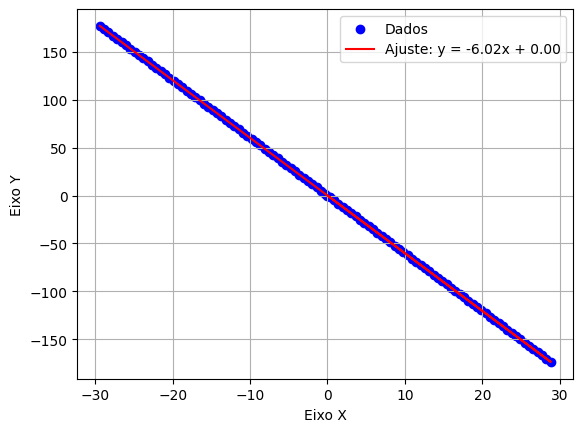

slope -6.0208043750593365
dslope 0.00023516069130186148
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401226415109704, -28.841226415112033, -28.28122641509981, -27.721226415102137, -27.161226415104466, -26.601226415106794, -26.041226415109122, -25.48122641511145, -24.921226415099227, -24.361226415101555, -23.801226415103883, -23.241226415106212, -22.68122641510854, -22.12122641511087, -21.561226415098645, -21.001226415100973, -20.44022641509946, -19.880226415101788, -19.320226415104116, -18.760226415106445, -18.200226415108773, -17.6402264151111, -17.080226415098878, -16.520226415101206, -15.960226415103534, -15.400226415105863, -14.84022641510819, -14.28022641511052, -13.720226415098296, -13.160226415100624, -12.600226415102952, -12.04022641510528, -11.480226415107609, -10.920226415109937, -10.360226415112265, -9.800226415100042, -9.24022641510237, -8.680226415104698, -8.120226415107027, -7.560226415109355, -7.000226415111683, -6.44022641509946, -5.880226415101788, -5.320226415104116, -4.76

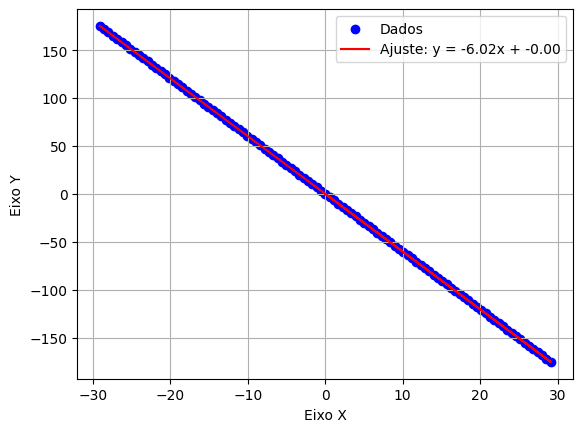

slope -6.020497125393882
dslope 0.00025226468123516884
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12135238094197, -28.5613523809443, -28.001352380946628, -27.441352380948956, -26.881352380936733, -26.32135238093906, -25.76135238094139, -25.201352380943717, -24.641352380946046, -24.080352380944532, -23.52035238094686, -22.96035238094919, -22.400352380936965, -21.840352380939294, -21.280352380941622, -20.72035238094395, -20.16035238094628, -19.600352380948607, -19.040352380950935, -18.48035238093871, -17.92035238094104, -17.360352380943368, -16.800352380945696, -16.240352380948025, -15.680352380950353, -15.12035238093813, -14.560352380940458, -14.000352380942786, -13.440352380945114, -12.880352380947443, -12.320352380949771, -11.760352380937547, -11.200352380939876, -10.640352380942204, -10.080352380944532, -9.52035238094686, -8.960352380949189, -8.400352380936965, -7.840352380939294, -7.280352380941622, -6.72035238094395, -6.160352380946279, -5.600352380948607, -5.040352380950935, -4.48035

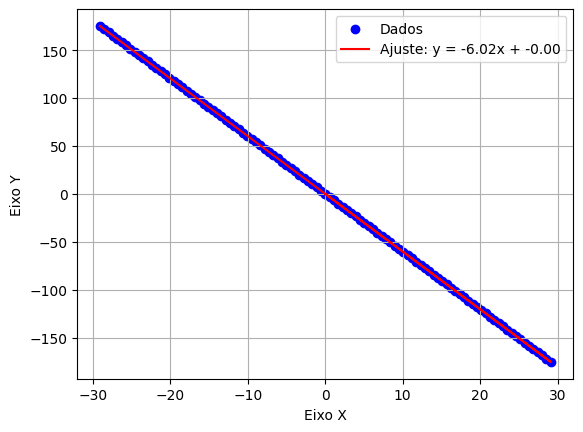

slope -6.020212188689838
dslope 0.0002505220105894763
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121523809517385, -28.56052380951587, -28.000523809503647, -27.440523809505976, -26.880523809508304, -26.320523809510632, -25.76052380951296, -25.20052380951529, -24.640523809517617, -24.080523809505394, -23.520523809507722, -22.96052380951005, -22.40052380951238, -21.840523809514707, -21.280523809517035, -20.72052380950481, -20.16052380950714, -19.60052380950947, -19.040523809511797, -18.480523809514125, -17.920523809516453, -17.36052380950423, -16.800523809506558, -16.240523809508886, -15.680523809511214, -15.120523809513543, -14.560523809515871, -14.000523809503647, -13.440523809505976, -12.880523809508304, -12.320523809510632, -11.76052380951296, -11.200523809515289, -10.640523809517617, -10.080523809505394, -9.520523809507722, -8.96052380951005, -8.400523809512379, -7.840523809514707, -7.280523809517035, -6.720523809504812, -6.16052380950714, -5.600523809509468, -5.040523809511797, -4.4805

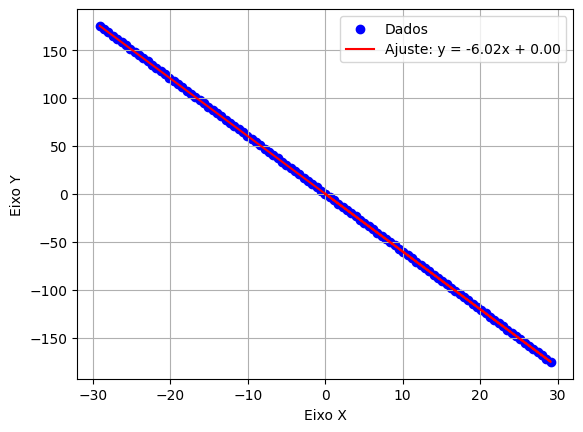

slope -6.021302912001179
dslope 0.00023860375731543247
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120666666669422, -28.56066666667175, -28.00066666667408, -27.440666666676407, -26.880666666678735, -26.32066666666651, -25.76066666666884, -25.200666666671168, -24.640666666673496, -24.080666666675825, -23.520666666678153, -22.96066666666593, -22.400666666668258, -21.840666666670586, -21.280666666672914, -20.720666666675243, -20.16066666667757, -19.600666666665347, -19.040666666667676, -18.480666666670004, -17.920666666672332, -17.36066666667466, -16.80066666667699, -16.240666666679317, -15.680666666667094, -15.120666666669422, -14.56066666667175, -14.000666666674078, -13.440666666676407, -12.880666666678735, -12.320666666666511, -11.76066666666884, -11.200666666671168, -10.640666666673496, -10.080666666675825, -9.520666666678153, -8.96066666666593, -8.400666666668258, -7.840666666670586, -7.280666666672914, -6.720666666675243, -6.160666666677571, -5.600666666665347, -5.040666666667676, -4.48

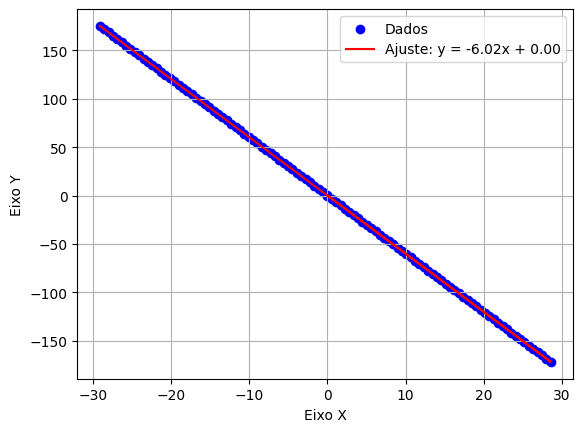

slope -6.021068622091985
dslope 0.00022729042587385506
len(ttime) 105
l+l2 106
l2 2
ttime [-29.12080000001879, -28.560800000006566, -28.000800000008894, -27.440800000011222, -26.88080000001355, -26.32080000001588, -25.760800000018207, -25.200800000005984, -24.640800000008312, -24.08080000001064, -23.52080000001297, -22.960800000015297, -22.400800000017625, -21.840800000019954, -21.28080000000773, -20.72080000001006, -20.160800000012387, -19.600800000014715, -19.040800000017043, -18.48080000001937, -17.920800000007148, -17.360800000009476, -16.800800000011805, -16.240800000014133, -15.680800000016461, -15.12080000001879, -14.560800000006566, -14.000800000008894, -13.440800000011222, -12.88080000001355, -12.320800000015879, -11.760800000018207, -11.200800000005984, -10.640800000008312, -10.08080000001064, -9.520800000012969, -8.960800000015297, -8.400800000017625, -7.839800000016112, -7.27980000001844, -6.719800000006217, -6.159800000008545, -5.599800000010873, -5.0398000000132015, -4.47

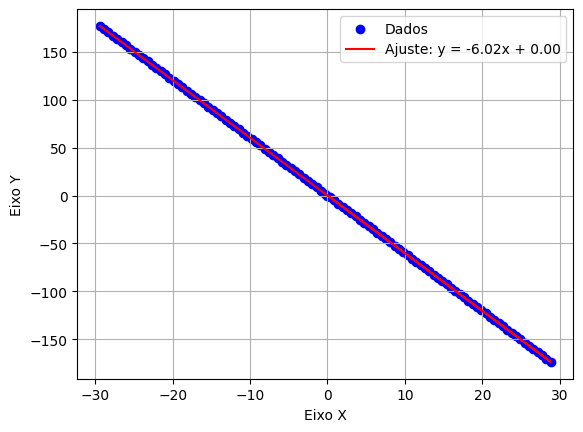

slope -6.021374991179248
dslope 0.00024156774261952565
len(ttime) 106
l+l2 107
l2 2
ttime [-29.400933962257113, -28.84093396225944, -28.28093396226177, -27.7209339622641, -27.160933962266427, -26.600933962254203, -26.04093396225653, -25.48093396225886, -24.920933962261188, -24.360933962263516, -23.800933962265844, -23.24093396225362, -22.68093396225595, -22.120933962258277, -21.560933962260606, -21.000933962262934, -20.440933962265262, -19.88093396225304, -19.320933962255367, -18.760933962257695, -18.200933962260024, -17.640933962262352, -17.08093396226468, -16.520933962252457, -15.960933962254785, -15.400933962257113, -14.840933962259442, -14.28093396226177, -13.720933962264098, -13.160933962266427, -12.600933962254203, -12.040933962256531, -11.479933962255018, -10.919933962257346, -10.359933962259674, -9.799933962262003, -9.239933962264331, -8.67993396226666, -8.119933962254436, -7.559933962256764, -6.999933962259092, -6.439933962261421, -5.879933962263749, -5.319933962266077, -4.759

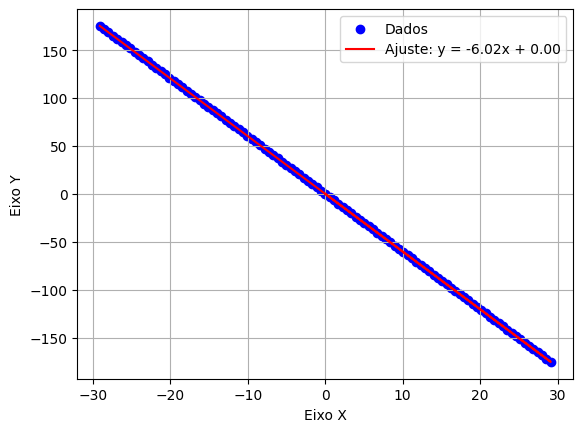

slope -6.020912068486186
dslope 0.00023342876293008135
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121047619046294, -28.56104761903407, -28.0010476190364, -27.441047619038727, -26.881047619041055, -26.321047619043384, -25.761047619045712, -25.20104761903349, -24.641047619035817, -24.081047619038145, -23.521047619040473, -22.9610476190428, -22.40104761904513, -21.84104761904746, -21.281047619035235, -20.721047619037563, -20.16104761903989, -19.60104761904222, -19.041047619044548, -18.481047619046876, -17.921047619034653, -17.36104761903698, -16.80104761903931, -16.241047619041638, -15.681047619043966, -15.120047619042452, -14.56004761904478, -14.000047619047109, -13.440047619034885, -12.880047619037214, -12.320047619039542, -11.76004761904187, -11.200047619044199, -10.640047619046527, -10.080047619034303, -9.520047619036632, -8.96004761903896, -8.400047619041288, -7.840047619043617, -7.280047619045945, -6.720047619033721, -6.16004761903605, -5.600047619038378, -5.040047619040706, -4.4800476

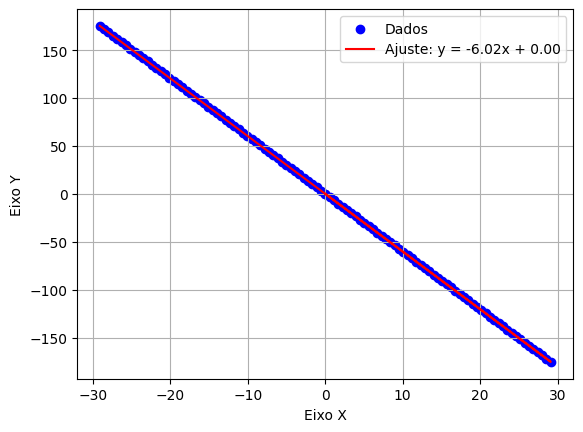

slope -6.0210821665417775
dslope 0.00025389609897260993
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121180952366558, -28.561180952368886, -28.001180952371215, -27.441180952373543, -26.88118095236132, -26.321180952363648, -25.761180952365976, -25.201180952368304, -24.641180952370632, -24.08118095237296, -23.521180952360737, -22.961180952363065, -22.401180952365394, -21.841180952367722, -21.28118095237005, -20.72118095237238, -20.161180952360155, -19.601180952362483, -19.04018095236097, -18.4801809523633, -17.920180952365627, -17.360180952367955, -16.800180952370283, -16.24018095237261, -15.680180952360388, -15.120180952362716, -14.560180952365045, -14.000180952367373, -13.440180952369701, -12.88018095237203, -12.320180952359806, -11.760180952362134, -11.200180952364462, -10.64018095236679, -10.080180952369119, -9.520180952371447, -8.960180952359224, -8.400180952361552, -7.84018095236388, -7.280180952366209, -6.720180952368537, -6.160180952370865, -5.600180952373194, -5.04018095236097, -4.48

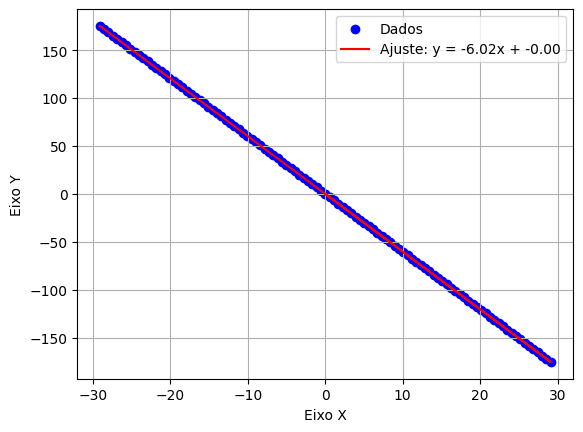

slope -6.021283573399813
dslope 0.00022842424212850517
len(ttime) 106
l+l2 106
l2 1
ttime [-29.121314285701374, -28.561314285703702, -28.00131428570603, -27.44131428570836, -26.881314285710687, -26.321314285713015, -25.76131428570079, -25.20131428570312, -24.641314285705448, -24.081314285707776, -23.521314285710105, -22.96031428570859, -22.40031428571092, -21.840314285713248, -21.280314285701024, -20.720314285703353, -20.16031428570568, -19.60031428570801, -19.040314285710338, -18.480314285712666, -17.920314285700442, -17.36031428570277, -16.8003142857051, -16.240314285707427, -15.680314285709755, -15.120314285712084, -14.560314285714412, -14.000314285702188, -13.440314285704517, -12.880314285706845, -12.320314285709173, -11.760314285711502, -11.20031428571383, -10.640314285701606, -10.080314285703935, -9.520314285706263, -8.960314285708591, -8.40031428571092, -7.840314285713248, -7.280314285701024, -6.720314285703353, -6.160314285705681, -5.600314285708009, -5.040314285710338, -4.4803

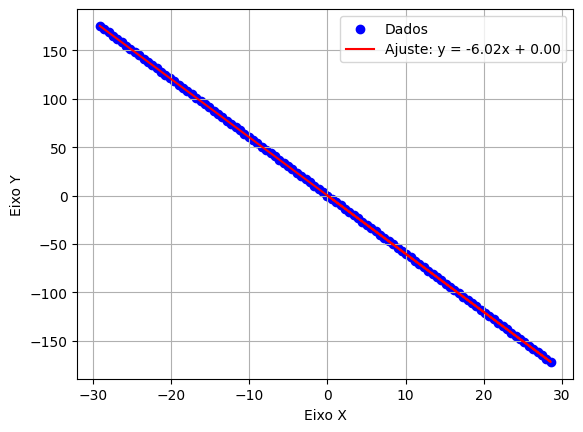

slope -6.0218842060070985
dslope 0.00029631566110738494
len(ttime) 105
l+l2 106
l2 2
ttime [-29.121457142857253, -28.56145714285958, -28.001457142847357, -27.441457142849686, -26.880457142848172, -26.3204571428505, -25.76045714285283, -25.200457142855157, -24.640457142857485, -24.080457142859814, -23.52045714284759, -22.96045714284992, -22.400457142852247, -21.840457142854575, -21.280457142856903, -20.72045714285923, -20.16045714286156, -19.600457142849336, -19.040457142851665, -18.480457142853993, -17.92045714285632, -17.36045714285865, -16.800457142860978, -16.240457142848754, -15.680457142851083, -15.120457142853411, -14.56045714285574, -14.000457142858068, -13.440457142860396, -12.880457142848172, -12.3204571428505, -11.760457142852829, -11.200457142855157, -10.640457142857485, -10.080457142859814, -9.52045714284759, -8.960457142849918, -8.400457142852247, -7.840457142854575, -7.280457142856903, -6.720457142859232, -6.16045714286156, -5.600457142849336, -5.040457142851665, -4.48045

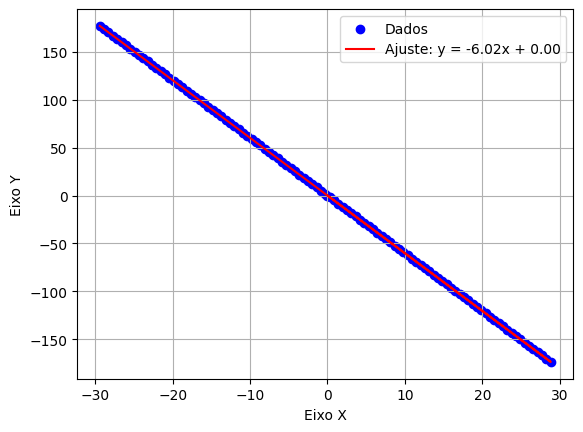

slope -6.019620101882653
dslope 0.00026293910431240253
len(ttime) 106
l+l2 107
l2 2
ttime [-29.40063207547064, -28.840632075458416, -28.280632075460744, -27.720632075463072, -27.1606320754654, -26.60063207546773, -26.040632075470057, -25.480632075472386, -24.920632075460162, -24.36063207546249, -23.80063207546482, -23.240632075467147, -22.680632075469475, -22.120632075471804, -21.56063207545958, -21.00063207546191, -20.440632075464237, -19.880632075466565, -19.320632075468893, -18.76063207547122, -18.200632075458998, -17.640632075461326, -17.080632075463654, -16.520632075465983, -15.960632075468311, -15.40063207547064, -14.840632075458416, -14.280632075460744, -13.720632075463072, -13.1606320754654, -12.600632075467729, -12.040632075470057, -11.480632075472386, -10.920632075460162, -10.36063207546249, -9.800632075464819, -9.240632075467147, -8.680632075469475, -8.120632075471804, -7.56063207545958, -7.000632075461908, -6.4406320754642366, -5.880632075466565, -5.320632075468893, -4.7606

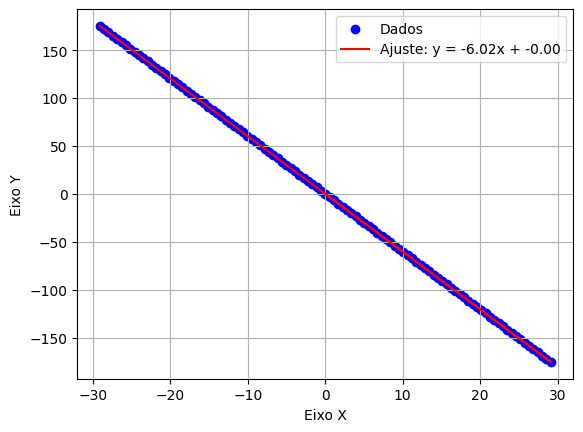

slope -6.020225821802036
dslope 0.00023637111739441963
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12074285716517, -28.560742857167497, -28.000742857169826, -27.440742857172154, -26.88074285715993, -26.32074285716226, -25.760742857164587, -25.200742857166915, -24.640742857169244, -24.080742857171572, -23.520742857159348, -22.960742857161677, -22.400742857164005, -21.840742857166333, -21.28074285716866, -20.72074285717099, -20.160742857158766, -19.600742857161094, -19.040742857163423, -18.48074285716575, -17.92074285716808, -17.360742857170408, -16.800742857172736, -16.240742857160512, -15.68074285716284, -15.120742857165169, -14.560742857167497, -14.000742857169826, -13.440742857172154, -12.88074285715993, -12.320742857162259, -11.760742857164587, -11.200742857166915, -10.640742857169244, -10.080742857171572, -9.520742857159348, -8.960742857161677, -8.400742857164005, -7.840742857166333, -7.280742857168661, -6.72074285717099, -6.159742857169476, -5.599742857171805, -5.039742857159581, -4.4

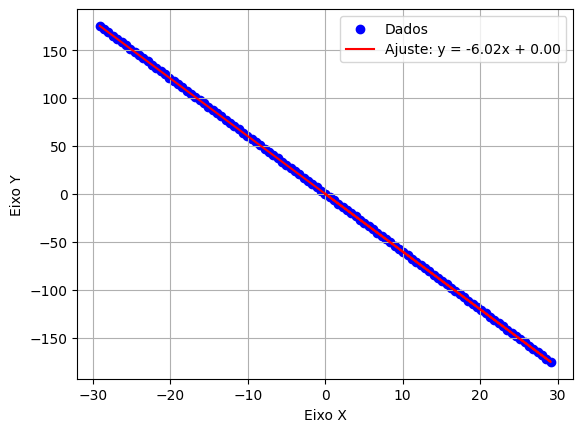

slope -6.0201929973491
dslope 0.00023538597361505854
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12087619047088, -28.56087619047321, -28.000876190475537, -27.440876190477866, -26.880876190480194, -26.320876190482522, -25.7608761904703, -25.200876190472627, -24.640876190474955, -24.080876190477284, -23.520876190479612, -22.96087619048194, -22.40087619048427, -21.840876190472045, -21.280876190474373, -20.7208761904767, -20.16087619047903, -19.600876190481358, -19.040876190483687, -18.480876190471463, -17.92087619047379, -17.36087619047612, -16.800876190478448, -16.240876190480776, -15.680876190483104, -15.12087619047088, -14.56087619047321, -14.000876190475537, -13.440876190477866, -12.880876190480194, -12.320876190482522, -11.760876190470299, -11.200876190472627, -10.640876190474955, -10.079876190473442, -9.51987619047577, -8.959876190478099, -8.399876190480427, -7.839876190482755, -7.279876190470532, -6.71987619047286, -6.159876190475188, -5.5998761904775165, -5.039876190479845, -4.4798761

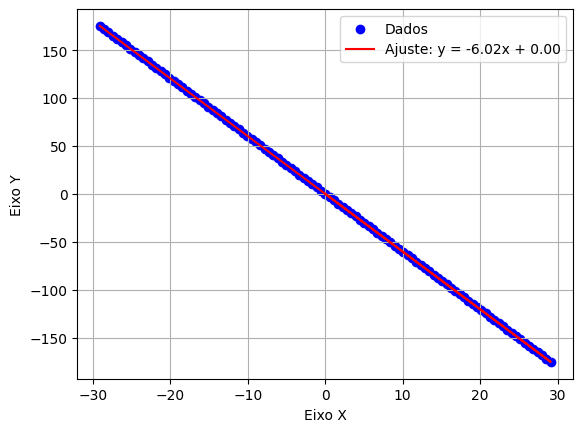

slope -6.020303172847823
dslope 0.00022622888373682995
len(ttime) 106
l+l2 106
l2 1
ttime [-29.12100952382025, -28.561009523822577, -28.001009523824905, -27.44100952381268, -26.88100952381501, -26.321009523817338, -25.761009523819666, -25.201009523821995, -24.641009523824323, -24.0810095238121, -23.521009523814428, -22.961009523816756, -22.401009523819084, -21.841009523821413, -21.28100952382374, -20.721009523811517, -20.161009523813846, -19.601009523816174, -19.041009523818502, -18.48100952382083, -17.92100952382316, -17.361009523825487, -16.801009523813264, -16.241009523815592, -15.68100952381792, -15.121009523820248, -14.561009523822577, -14.000009523821063, -13.440009523823392, -12.880009523811168, -12.320009523813496, -11.760009523815825, -11.200009523818153, -10.640009523820481, -10.08000952382281, -9.520009523825138, -8.960009523812914, -8.400009523815243, -7.840009523817571, -7.280009523819899, -6.7200095238222275, -6.160009523824556, -5.600009523812332, -5.0400095238146605, -4

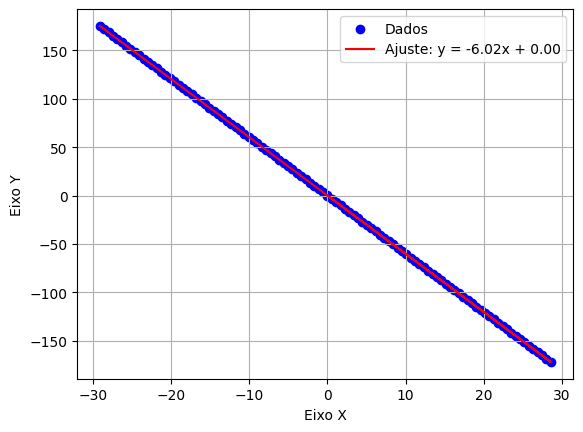

slope -6.0204144236264066
dslope 0.00023531529626931943
len(ttime) 105
l+l2 106
l2 2
ttime [-29.12114285712596, -28.56114285712829, -28.001142857130617, -27.441142857132945, -26.881142857135274, -26.32114285712305, -25.761142857125378, -25.201142857127707, -24.641142857130035, -24.081142857132363, -23.52114285713469, -22.96114285713702, -22.401142857124796, -21.841142857127124, -21.281142857129453, -20.72114285713178, -20.16114285713411, -19.601142857136438, -19.041142857124214, -18.481142857126542, -17.92014285712503, -17.360142857127357, -16.800142857129686, -16.240142857132014, -15.680142857134342, -15.12014285713667, -14.560142857124447, -14.000142857126775, -13.440142857129104, -12.880142857131432, -12.32014285713376, -11.760142857136088, -11.200142857123865, -10.640142857126193, -10.080142857128521, -9.52014285713085, -8.960142857133178, -8.400142857135506, -7.840142857123283, -7.280142857125611, -6.720142857127939, -6.160142857130268, -5.600142857132596, -5.040142857134924, -4.4

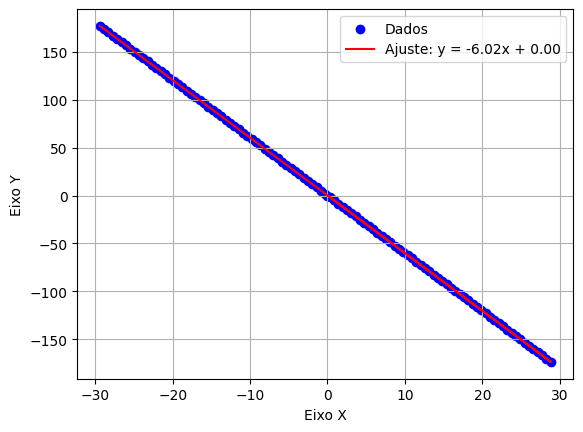

slope -6.019906176699913
dslope 0.00026342207401429645
len(ttime) 106
l+l2 107
l2 2
ttime [-29.4012641509471, -28.841264150949428, -28.281264150951756, -27.721264150939533, -27.16126415094186, -26.60126415094419, -26.041264150946517, -25.481264150948846, -24.921264150951174, -24.36126415093895, -23.80126415094128, -23.241264150943607, -22.681264150945935, -22.121264150948264, -21.56026415094675, -21.00026415094908, -20.440264150951407, -19.880264150939183, -19.32026415094151, -18.76026415094384, -18.20026415094617, -17.640264150948497, -17.080264150950825, -16.5202641509386, -15.96026415094093, -15.400264150943258, -14.840264150945586, -14.280264150947914, -13.720264150950243, -13.16026415093802, -12.600264150940347, -12.040264150942676, -11.480264150945004, -10.920264150947332, -10.36026415094966, -9.800264150951989, -9.240264150939765, -8.680264150942094, -8.120264150944422, -7.56026415094675, -7.000264150949079, -6.440264150951407, -5.880264150939183, -5.320264150941512, -4.76026415

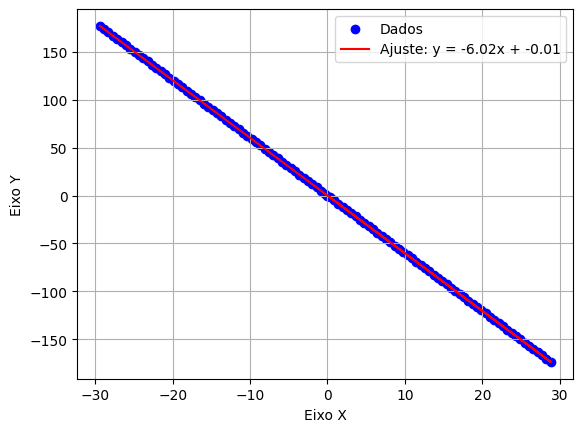

slope -6.020275855301496
dslope 0.0002350575530324792
len(ttime) 106
l+l2 107
l2 2
ttime [-29.401396226414363, -28.84139622641669, -28.28139622641902, -27.721396226421348, -27.161396226423676, -26.601396226411453, -26.04139622641378, -25.480396226412267, -24.920396226414596, -24.360396226416924, -23.800396226419252, -23.24039622642158, -22.68039622642391, -22.120396226411685, -21.560396226414014, -21.000396226416342, -20.44039622641867, -19.880396226421, -19.320396226423327, -18.760396226411103, -18.20039622641343, -17.64039622641576, -17.080396226418088, -16.520396226420416, -15.960396226422745, -15.400396226425073, -14.84039622641285, -14.280396226415178, -13.720396226417506, -13.160396226419834, -12.600396226422163, -12.040396226424491, -11.480396226412267, -10.920396226414596, -10.360396226416924, -9.800396226419252, -9.24039622642158, -8.680396226423909, -8.120396226411685, -7.560396226414014, -7.000396226416342, -6.44039622641867, -5.880396226420999, -5.320396226423327, -4.760396

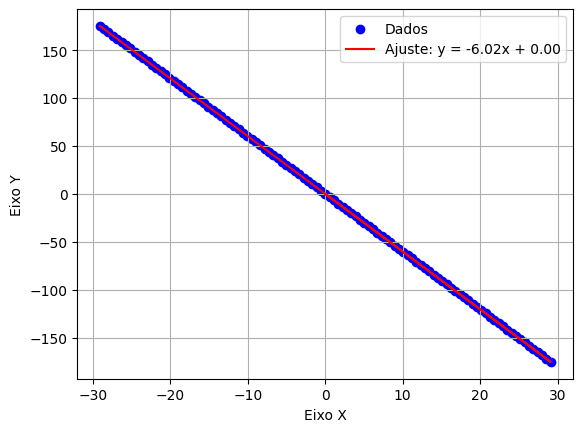

slope -6.020280614170977
dslope 0.00022911372563751102
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120571428560652, -28.56057142856298, -28.00057142856531, -27.440571428553085, -26.880571428555413, -26.32057142855774, -25.76057142856007, -25.200571428562398, -24.640571428564726, -24.080571428552503, -23.52057142855483, -22.96057142855716, -22.400571428559488, -21.840571428561816, -21.280571428564144, -20.720571428566473, -20.16057142855425, -19.600571428556577, -19.040571428558906, -18.480571428561234, -17.920571428563562, -17.36057142856589, -16.800571428553667, -16.240571428555995, -15.680571428558324, -15.120571428560652, -14.56057142856298, -14.000571428565308, -13.440571428553085, -12.880571428555413, -12.320571428557741, -11.76057142856007, -11.200571428562398, -10.640571428564726, -10.080571428552503, -9.520571428554831, -8.96057142855716, -8.400571428559488, -7.840571428561816, -7.280571428564144, -6.720571428566473, -6.160571428554249, -5.600571428556577, -5.040571428558906, -4.48

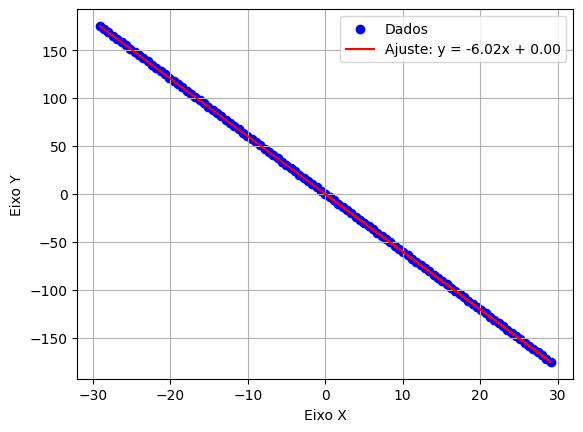

slope -6.020327884103227
dslope 0.00022129241081673566
len(ttime) 106
l+l2 106
l2 1
ttime [-29.120704761880916, -28.560704761883244, -28.000704761885572, -27.4407047618879, -26.88070476189023, -26.320704761892557, -25.760704761880334, -25.200704761882662, -24.64070476188499, -24.08070476188732, -23.520704761889647, -22.960704761891975, -22.40070476187975, -21.84070476188208, -21.280704761884408, -20.720704761886736, -20.160704761889065, -19.600704761891393, -19.04070476187917, -18.480704761881498, -17.920704761883826, -17.360704761886154, -16.800704761888483, -16.24070476189081, -15.680704761878587, -15.120704761880916, -14.560704761883244, -14.000704761885572, -13.4407047618879, -12.880704761890229, -12.320704761892557, -11.760704761880334, -11.200704761882662, -10.64070476188499, -10.080704761887318, -9.520704761889647, -8.960704761891975, -8.400704761879751, -7.84070476188208, -7.280704761884408, -6.720704761886736, -6.160704761889065, -5.600704761891393, -5.03970476188988, -4.47970

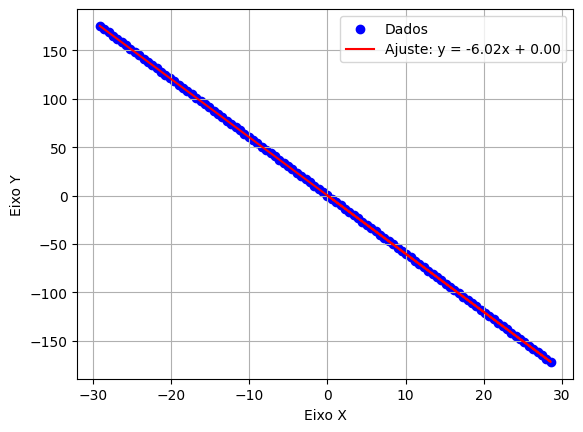

slope -6.020178229820971
dslope 0.00022148412948823468
len(ttime) 105
l+l2 106
l2 2
ttime [-29.120847619036795, -28.560847619039123, -28.0008476190269, -27.440847619029228, -26.880847619031556, -26.320847619033884, -25.760847619036213, -25.20084761903854, -24.640847619026317, -24.080847619028646, -23.520847619030974, -22.960847619033302, -22.40084761903563, -21.84084761903796, -21.280847619025735, -20.720847619028063, -20.160847619030392, -19.60084761903272, -19.04084761903505, -18.480847619037377, -17.920847619039705, -17.36084761902748, -16.80084761902981, -16.240847619032138, -15.680847619034466, -15.120847619036795, -14.560847619039123, -14.0008476190269, -13.440847619029228, -12.880847619031556, -12.320847619033884, -11.760847619036213, -11.20084761903854, -10.640847619026317, -10.080847619028646, -9.520847619030974, -8.95984761902946, -8.399847619031789, -7.839847619034117, -7.279847619036445, -6.719847619038774, -6.15984761902655, -5.599847619028878, -5.039847619031207, -4.47984

IndexError: list index out of range

In [19]:
main()